# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [2]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.api as sm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from statsmodels.stats.stattools import durbin_watson
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Dict, List, Set, Tuple, Optional, Any, Union
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

shape: (5, 38)
┌─────────┬────────────┬───────────┬─────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ id      ┆ date       ┆ client_id ┆ card_id ┆ … ┆ credit_lim ┆ acct_open_ ┆ year_pin_ ┆ card_on_d │
│ ---     ┆ ---        ┆ ---       ┆ ---     ┆   ┆ it         ┆ date       ┆ last_chan ┆ ark_web   │
│ i64     ┆ datetime[n ┆ i64       ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ged       ┆ ---       │
│         ┆ s]         ┆           ┆         ┆   ┆ f64        ┆ str        ┆ ---       ┆ str       │
│         ┆            ┆           ┆         ┆   ┆            ┆            ┆ i64       ┆           │
╞═════════╪════════════╪═══════════╪═════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 7475328 ┆ 2010-01-01 ┆ 561       ┆ 4575    ┆ … ┆ 9100.0     ┆ 09/2005    ┆ 2015      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475329 ┆ 2010-01-01 ┆ 1129      ┆ 102     ┆ … ┆ 14802.0    ┆ 01/2006    ┆ 2008      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475332 ┆ 2010-01-01 ┆ 848       ┆ 3915    ┆ … ┆ 19113.0    ┆ 07/2009    ┆ 2014      ┆ No        │
│         ┆ 00:06:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475333 ┆ 2010-01-01 ┆ 1807      ┆ 165     ┆ … ┆ 89.0       ┆ 01/2008    ┆ 2015      ┆ No        │
│         ┆ 00:07:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475335 ┆ 2010-01-01 ┆ 1684      ┆ 2140    ┆ … ┆ 46.0       ┆ 03/2007    ┆ 2012      ┆ No        │
│         ┆ 00:14:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
└─────────┴────────────┴───────────┴─────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [8]:
# df.to_pandas().describe().to_csv('/content/datasets/summarize.csv')

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

## 1. Pré-processamento de Dados (`process`)

Esta etapa inicial limpa e prepara o DataFrame para as operações de agregação.

- **Conversão Temporal:** A coluna `date` é convertida para o formato `datetime`, permitindo operações baseadas em tempo.
- **Ordenação Cronológica:** Os dados são ordenados pela coluna `date` para garantir a sequência correta dos eventos.
- **Codificação de Variáveis:** Coluna categórica (`use_chip`) foram mapeadas para valores numéricos (`1` para 'Yes'/'Chip Transaction', `0` para 'No'/'Swipe Transaction'/'Online').
- **Tratamento de Nulos:** Valores ausentes são preenchidos com padrões neutros (`zip` com `0`, `errors` com `'No Error'`) para prevenir falhas nos cálculos.

---

## 2. Criação de Features por Agregação Temporal

As features são calculadas para cada intervalo de tempo (`freq`) e armazenadas em um novo DataFrame.

### 2.1 Features Temporais Básicas

Medem o volume e a natureza fundamental das transações.

#### total_transactions
- **Descritivo:** Contagem total de transações na janela de tempo.
- **Lógica de Criação:** Agrupamento por janela de tempo e contagem de IDs de transação.

#### total_amount
- **Descritivo:** Valor monetário total transacionado no período.
- **Lógica de Criação:** Agrupamento por janela de tempo e soma dos valores da coluna `amount`.

#### chip_ratio
- **Descritivo:** Proporção de transações realizadas com chip em relação ao total.
- **Lógica de Criação:** Contagem de transações onde `use_chip == 1` dividida pelo `total_transactions` do período.

### 2.2 Features Comportamentais

Capturam os padrões de atividade e comportamento dos usuários.

#### txn_velocity
- **Descritivo:** Velocidade média das transações, medida em transações por segundo.
- **Lógica de Criação:** `total_transactions` da janela dividido pelo total de segundos da janela.

#### avg_txn_value
- **Descritivo:** Valor monetário médio por transação.
- **Lógica de Criação:** Agrupamento por janela de tempo e cálculo da média da coluna `amount`.

#### geo_dispersion
- **Descritivo:** Medida da dispersão geográfica das transações. Um valor alto indica que as transações estão muito espalhadas.
- **Lógica de Criação:** Para cada janela de tempo, calcula-se a soma do desvio padrão das colunas `latitude` e `longitude`.

#### merchant_entropy
- **Descritivo:** Mede a diversidade (ou imprevisibilidade) dos comércios utilizados. Entropia alta significa alta diversidade.
- **Lógica de Criação:** Calcula-se a contagem de transações por `merchant_id` dentro da janela. Em seguida, a função `entropy` da biblioteca SciPy é aplicada sobre essas contagens para obter um valor único de diversidade para o período.

### 2.3 Features de Risco

Agregam métricas diretamente associadas ao risco inerente das transações.

#### avg_credit_score
- **Descritivo:** Média do score de crédito dos clientes que transacionaram no período.
- **Lógica de Criação:** Agrupamento por janela de tempo e cálculo da média da coluna `credit_score`.

#### error_ratio
- **Descritivo:** Proporção de transações que resultaram em algum tipo de erro.
- **Lógica de Criação:** Contagem de transações onde a coluna `errors` é diferente de `'No Error'`, dividida pelo `total_transactions` do período.

### 2.4 Features Sazonais

Contextualizam a atividade dentro de ciclos temporais conhecidos.

#### hour_of_day, day_of_week
- **Descritivo:** Extrai a hora do dia (0-23) e o dia da semana (0-6) do índice temporal.
- **Lógica de Criação:** Aplicação das propriedades `.index.hour` e `.index.dayofweek` ao DataFrame de features.

#### is_weekend
- **Descritivo:** Variável binária (1/0) que indica se o período ocorre em um fim de semana.
- **Lógica de Criação:** Verifica se `day_of_week` é 5 (Sábado) ou 6 (Domingo).

#### is_holiday
- **Descritivo:** Variável binária (1/0) que indica se o período ocorre em um feriado federal dos EUA.
- **Lógica de Criação:** Utiliza a biblioteca `pandas_market_calendars` para gerar uma lista de feriados e verifica se a data do índice pertence a essa lista.

### 2.5 Features de Mudança

Detectam variações e anomalias em relação ao comportamento recente.

#### txn_volume_change, avg_value_change
- **Descritivo:** Variação percentual do volume de transações e do valor médio em relação ao período anterior.
- **Lógica de Criação:** Aplicação do método `.pct_change()` às colunas `total_transactions` e `avg_txn_value`.

#### velocity_alert
- **Descritivo:** Alerta binário (1/0) que dispara se o volume de transações excede um limiar estatístico dinâmico.
- **Lógica de Criação:** Calcula a média móvel e o desvio padrão móvel de `total_transactions` (janela de 7 dias). O alerta é ativado se o valor atual for maior que `média + 2 * desvio_padrão`.

### 2.6 Features de Rede

Analisam as relações entre as entidades (clientes e cartões).

#### unique_clients, unique_cards
- **Descritivo:** Contagem de clientes e cartões únicos que realizaram transações no período.
- **Lógica de Criação:** Agrupamento por janela de tempo e contagem de valores distintos nas colunas `client_id` e `card_id`.

#### cards_per_client
- **Descritivo:** Razão entre o número de cartões únicos e clientes únicos.
- **Lógica de Criação:** Divisão da feature `unique_cards` por `unique_clients`.

---

## 3. Variável Alvo e Finalização

- **`frauds` (Variável Alvo):**
  - **Descritivo:** A variável que o modelo preditivo irá estimar. Representa a contagem total de transações fraudulentas no período.
  - **Lógica de Criação:** Filtra as transações onde `target == 1`, agrupa por janela de tempo e realiza a contagem.

- **Preenchimento de Valores Nulos:**
  - **Descritivo:** Garante que o DataFrame final não contenha valores ausentes.
  - **Lógica de Criação:** Primeiro, aplica um preenchimento para frente (`method='ffill'`) para propagar a última observação válida. Em seguida, preenche quaisquer valores restantes com `0`.

#### Feature Engineering

##### Base Consolidada

In [9]:
class FraudFeatureEngineer:
    def __init__(self, freq='1H'):
        """
        Inicializa o motor de feature engineering para agregação temporal

        Parâmetros:
        freq (str): Frequência para agregação temporal ('1H', '1D', etc.)
        """
        self.freq = freq
        self.cal = USFederalHolidayCalendar()

    def process(self, df: pd.DataFrame):
        """
        Carrega e pré-processa os dados brutos

        Parâmetros:
        filepath (str): Caminho para o arquivo CSV

        Retorna:
        pd.DataFrame: DataFrame pré-processado
        """

        # Converter coluna de data para datetime
        df['date'] = pd.to_datetime(df['date'])

        # Ordenar por data
        df = df.sort_values('date').reset_index(drop=True)

        # Pré-processar colunas categóricas
        df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0, 'Online': 0})
        df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
        df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

        # Preencher valores ausentes
        df['zip'] = df['zip'].fillna(0)
        df['errors'] = df['errors'].fillna('No Error')

        return df

    def create_time_index(self, df):
        """
        Cria o índice temporal para agregação

        Parâmetros:
        df (pd.DataFrame): DataFrame com dados brutos

        Retorna:
        pd.DatetimeIndex: Índice temporal para agregação
        """
        return pd.date_range(
            start=df['date'].min().floor('H'),
            end=df['date'].max().ceil('H'),
            freq=self.freq
        )

    def add_temporal_features(self, features_df, df):
        """
        Adiciona features temporais básicas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem total de transações por período
        features_df['total_transactions'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()

        # Valor total transacionado por período
        features_df['total_amount'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].sum()

        # Proporção de transações com chip
        chip_count = df[df['use_chip'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['chip_ratio'] = chip_count / features_df['total_transactions']

        return features_df

    def add_behavioral_features(self, features_df, df):
        """
        Adiciona features comportamentais agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Calcular window_size_seconds baseado na frequência configurada
        freq_seconds = pd.Timedelta(self.freq).total_seconds()
        features_df['duration_sec'] = freq_seconds

        # Velocidade de transações (transações por segundo)
        features_df['txn_velocity'] = features_df['total_transactions'] / 3600

        # Valor médio por transação
        features_df['avg_txn_value'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].mean()

        # Dispersão geográfica das transações
        def geographic_dispersion(group):
            if len(group) <= 1:
                return 0
            return np.std(group['latitude']) + np.std(group['longitude'])

        geo_dispersion = df.groupby(
            pd.Grouper(key='date', freq=self.freq)).apply(geographic_dispersion)
        features_df['geo_dispersion'] = geo_dispersion

        # Diversidade de merchants (entropia)
        merchant_counts = df.groupby([pd.Grouper(key='date', freq=self.freq),
                                     'merchant_id'])['id'].count()

        def calculate_entropy(group):
            if len(group) <= 1:
                return 0
            return entropy(group.values)

        merchant_entropy = merchant_counts.groupby(level=0).apply(calculate_entropy)
        features_df['merchant_entropy'] = merchant_entropy

        return features_df

    def add_risk_features(self, features_df, df):
        """
        Adiciona features de risco agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Média de credit score por período
        features_df['avg_credit_score'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['credit_score'].mean()

        # Proporção de transações com erro
        error_count = df[df['errors'] != 'No Error'].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['error_ratio'] = error_count / features_df['total_transactions']

        return features_df

    def add_seasonal_features(self, features_df):
        """
        Adiciona features sazonais e temporais

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Componentes temporais
        features_df['hour_of_day'] = features_df.index.hour
        features_df['day_of_week'] = features_df.index.dayofweek
        features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

        # Feriados
        holidays = self.cal.holidays(
            start=features_df.index.min(),
            end=features_df.index.max()
        )
        features_df['is_holiday'] = features_df.index.normalize().isin(
            [h.date() for h in holidays]
        ).astype(int)

        return features_df

    def add_change_features(self, features_df):
        """
        Adiciona features de mudança comportamental

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Mudanças no volume de transações
        features_df['txn_volume_change'] = features_df['total_transactions'].pct_change()

        # Mudanças no valor médio das transações
        features_df['avg_value_change'] = features_df['avg_txn_value'].pct_change()

        # Alertas de velocidade (mais de 2 desvios padrão da média móvel)
        rolling_mean = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).mean()
        rolling_std = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).std()
        features_df['velocity_alert'] = (
            (features_df['total_transactions'] - rolling_mean) > (2 * rolling_std)
        ).astype(int)

        return features_df

    def add_network_features(self, features_df, df):
        """
        Adiciona features de rede e relacionamento

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Número de clientes únicos por período
        features_df['unique_clients'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['client_id'].nunique()

        # Número de cartões únicos por período
        features_df['unique_cards'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['card_id'].nunique()

        # Razão cartões/clientes (possível indicador de fraude)
        features_df['cards_per_client'] = features_df['unique_cards'] / features_df['unique_clients'].replace(0, 1)

        return features_df

    def add_target_variable(self, features_df, df):
        """
        Adiciona a variável target (contagem de fraudes)

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem de fraudes por período
        fraud_count = df[df['target'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['frauds'] = fraud_count
        features_df['frauds'].fillna(0, inplace=True)

        return features_df

    def engineer_features(self, df: pd.DataFrame):
        """
        Executa todo o pipeline de engenharia de features

        Parâmetros:
        df: DataFrame

        Retorna:
        pd.DataFrame: DataFrame com features agregadas
        """
        # Carregar e pré-processar dados
        print("Carregando e pré-processando dados...")
        df = self.process(df)

        # Criar índice temporal
        print("Criando índice temporal...")
        time_index = self.create_time_index(df)
        features_df = pd.DataFrame(index=time_index)

        # Adicionar features
        print("Adicionando features temporais...")
        features_df = self.add_temporal_features(features_df, df)

        print("Adicionando features comportamentais...")
        features_df = self.add_behavioral_features(features_df, df)

        print("Adicionando features de risco...")
        features_df = self.add_risk_features(features_df, df)

        print("Adicionando features sazonais...")
        features_df = self.add_seasonal_features(features_df)

        print("Adicionando features de mudança...")
        features_df = self.add_change_features(features_df)

        print("Adicionando features de rede...")
        features_df = self.add_network_features(features_df, df)

        print("Adicionando variável target...")
        features_df = self.add_target_variable(features_df, df)

        # Preencher valores NaN
        print("Preenchendo valores ausentes...")
        features_df.fillna(method='ffill', inplace=True)
        features_df.fillna(0, inplace=True)

        print("Feature engineering concluído!")
        return features_df

##### Ajuste

In [10]:
# class FraudFeatureEngineer:
#     def __init__(self, freq='1H'):
#         """
#         Inicializa o motor de feature engineering para agregação temporal

#         Parâmetros:
#         freq (str): Frequência para agregação temporal ('1H', '1D', etc.)
#         """
#         self.freq = freq
#         self.cal = USFederalHolidayCalendar()

#     def process(self, df: pd.DataFrame):
#         """
#         Carrega e pré-processa os dados brutos

#         Parâmetros:
#         filepath (str): Caminho para o arquivo CSV

#         Retorna:
#         pd.DataFrame: DataFrame pré-processado
#         """

#         # Converter coluna de data para datetime
#         df['date'] = pd.to_datetime(df['date'])

#         # Ordenar por data
#         df = df.sort_values('date').reset_index(drop=True)

#         # Pré-processar colunas categóricas
#         df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0, 'Online': 0})
#         df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
#         df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

#         # Preencher valores ausentes
#         df['zip'] = df['zip'].fillna(0)
#         df['errors'] = df['errors'].fillna('No Error')

#         return df

#     def create_time_index(self, df):
#         """
#         Cria o índice temporal para agregação

#         Parâmetros:
#         df (pd.DataFrame): DataFrame com dados brutos

#         Retorna:
#         pd.DatetimeIndex: Índice temporal para agregação
#         """
#         return pd.date_range(
#             start=df['date'].min().floor('H'),
#             end=df['date'].max().ceil('H'),
#             freq=self.freq
#         )

#     def add_temporal_features(self, features_df, df):
#         """
#         Adiciona features temporais básicas

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         df (pd.DataFrame): DataFrame com dados brutos
#         """
#         # Contagem total de transações por período
#         features_df['total_transactions'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['id'].count()

#         # Valor total transacionado por período
#         features_df['total_amount'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['amount'].sum()

#         # Proporção de transações com chip
#         chip_count = df[df['use_chip'] == 1].groupby(
#             pd.Grouper(key='date', freq=self.freq))['id'].count()
#         features_df['chip_ratio'] = chip_count / features_df['total_transactions']

#         return features_df

#     def add_behavioral_features(self, features_df, df):
#         """
#         Adiciona features comportamentais agregadas

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         df (pd.DataFrame): DataFrame com dados brutos
#         """
#         # Calcular window_size_seconds baseado na frequência configurada
#         freq_seconds = pd.Timedelta(self.freq).total_seconds()

#         # Velocidade de transações (transações por segundo)
#         features_df['txn_velocity'] = features_df['total_transactions'] / freq_seconds

#         # Valor médio por transação
#         features_df['avg_txn_value'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['amount'].mean()

#         # Dispersão geográfica das transações
#         def geographic_dispersion(group):
#             if len(group) <= 1:
#                 return 0
#             return np.std(group['latitude']) + np.std(group['longitude'])

#         geo_dispersion = df.groupby(
#             pd.Grouper(key='date', freq=self.freq)).apply(geographic_dispersion)
#         features_df['geo_dispersion'] = geo_dispersion

#         # Diversidade de merchants (entropia)
#         merchant_counts = df.groupby([pd.Grouper(key='date', freq=self.freq),
#                                      'merchant_id'])['id'].count()

#         def calculate_entropy(group):
#             if len(group) <= 1:
#                 return 0
#             return entropy(group.values)

#         merchant_entropy = merchant_counts.groupby(level=0).apply(calculate_entropy)
#         features_df['merchant_entropy'] = merchant_entropy

#         return features_df

#     def add_risk_features(self, features_df, df):
#         """
#         Adiciona features de risco agregadas

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         df (pd.DataFrame): DataFrame com dados brutos
#         """
#         # Média de credit score por período
#         features_df['avg_credit_score'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['credit_score'].mean()

#         # Proporção de transações com erro
#         error_count = df[df['errors'] != 'No Error'].groupby(
#             pd.Grouper(key='date', freq=self.freq))['id'].count()
#         features_df['error_ratio'] = error_count / features_df['total_transactions']

#         return features_df

#     def add_seasonal_features(self, features_df):
#         """
#         Adiciona features sazonais e temporais

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         """
#         # Componentes temporais
#         features_df['hour_of_day'] = features_df.index.hour
#         features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour_of_day'] / 24)
#         features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour_of_day'] / 24)

#         features_df['day_of_week'] = features_df.index.dayofweek
#         features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

#         del features_df['day_of_week']
#         del features_df['hour_of_day']

#         # Feriados
#         holidays = self.cal.holidays(
#             start=features_df.index.min(),
#             end=features_df.index.max()
#         )
#         features_df['is_holiday'] = features_df.index.normalize().isin(
#             [h.date() for h in holidays]
#         ).astype(int)

#         return features_df

#     def add_change_features(self, features_df):
#         """
#         Adiciona features de mudança comportamental

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         """
#         # Mudanças no volume de transações
#         features_df['txn_volume_change'] = features_df['total_transactions'].pct_change()

#         # Mudanças no valor médio das transações
#         features_df['avg_value_change'] = features_df['avg_txn_value'].pct_change()

#         # Alertas de velocidade (mais de 2 desvios padrão da média móvel)
#         rolling_mean = features_df['total_transactions'].rolling(
#             window=24*7, min_periods=1).mean()
#         rolling_std = features_df['total_transactions'].rolling(
#             window=24*7, min_periods=1).std()
#         features_df['velocity_alert'] = (
#             (features_df['total_transactions'] - rolling_mean) > (2 * rolling_std)
#         ).astype(int)

#         return features_df

#     def add_network_features(self, features_df, df):
#         """
#         Adiciona features de rede e relacionamento

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         df (pd.DataFrame): DataFrame com dados brutos
#         """
#         # Número de clientes únicos por período
#         features_df['unique_clients'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['client_id'].nunique()

#         # Número de cartões únicos por período
#         features_df['unique_cards'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['card_id'].nunique()

#         # Razão cartões/clientes (possível indicador de fraude)
#         features_df['cards_per_client'] = features_df['unique_cards'] / features_df['unique_clients'].replace(0, 1)

#         return features_df

#     def add_target_variable(self, features_df, df):
#         """
#         Adiciona a variável target (contagem de fraudes)

#         Parâmetros:
#         features_df (pd.DataFrame): DataFrame para armazenar features
#         df (pd.DataFrame): DataFrame com dados brutos
#         """
#         # Contagem de fraudes por período
#         fraud_count = df[df['target'] == 1].groupby(
#             pd.Grouper(key='date', freq=self.freq))['id'].count()
#         features_df['frauds'] = fraud_count
#         features_df['frauds'].fillna(0, inplace=True)

#         return features_df

#     def engineer_features(self, df: pd.DataFrame):
#         """
#         Executa todo o pipeline de engenharia de features

#         Parâmetros:
#         df: DataFrame

#         Retorna:
#         pd.DataFrame: DataFrame com features agregadas
#         """
#         # Carregar e pré-processar dados
#         print("Carregando e pré-processando dados...")
#         df = self.process(df)

#         # Criar índice temporal
#         print("Criando índice temporal...")
#         time_index = self.create_time_index(df)
#         features_df = pd.DataFrame(index=time_index)

#         # Adicionar features
#         print("Adicionando features temporais...")
#         features_df = self.add_temporal_features(features_df, df)

#         print("Adicionando features comportamentais...")
#         features_df = self.add_behavioral_features(features_df, df)

#         print("Adicionando features de risco...")
#         features_df = self.add_risk_features(features_df, df)

#         print("Adicionando features sazonais...")
#         features_df = self.add_seasonal_features(features_df)

#         print("Adicionando features de mudança...")
#         features_df = self.add_change_features(features_df)

#         print("Adicionando features de rede...")
#         features_df = self.add_network_features(features_df, df)

#         print("Adicionando variável target...")
#         features_df = self.add_target_variable(features_df, df)

#         # Preencher valores NaN
#         print("Preenchendo valores ausentes...")
#         features_df.fillna(method='ffill', inplace=True)
#         features_df.fillna(0, inplace=True)

#         print("Feature engineering concluído!")
#         return features_df


##### Maior enriquecimento

In [11]:
# class FraudFeatureEngineer:
#     def __init__(self, freq='1H'):
#         """
#         Inicializa o motor de feature engineering para agregação temporal
#         """
#         self.freq = freq
#         self.cal = USFederalHolidayCalendar()

#     def process(self, df: pd.DataFrame):
#         """
#         Pré-processamento dos dados com codificação adequada de variáveis cíclicas
#         """
#         df = df.copy()
#         df['date'] = pd.to_datetime(df['date'])
#         df = df.sort_values('date').reset_index(drop=True)

#         # Codificação para variáveis binárias (apenas onde faz sentido)
#         df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0, 'Online': 0})
#         df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
#         df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

#         # Preencher valores ausentes
#         df['zip'] = df['zip'].fillna(0)
#         df['errors'] = df['errors'].fillna('No Error')

#         # Variáveis cíclicas serão codificadas posteriormente no processo de agregação
#         # para evitar ponderação arbitrária
#         df['hour'] = df['date'].dt.hour
#         df['day_of_week'] = df['date'].dt.dayofweek

#         return df

#     def encode_cyclic_features(self, features_df):
#         """
#         Codifica variáveis cíclicas usando funções trigonométricas para evitar ponderação arbitrária
#         """
#         # Codificação cíclica para horas do dia
#         features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour_of_day'] / 24)
#         features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour_of_day'] / 24)

#         # Codificação cíclica para dias da semana
#         features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
#         features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

#         # Remover as colunas originais que tinham ponderação arbitrária
#         features_df.drop(['hour_of_day', 'day_of_week'], axis=1, inplace=True)

#         return features_df

#     def create_aggregation_functions(self):
#         """
#         Define funções de agregação robustas para evitar vieses
#         """
#         return {
#             'amount': ['sum', 'mean', 'std', 'skew', 'count'],
#             'use_chip': 'mean',
#             'online_sales': 'mean',
#             'card_has_chip': 'mean',
#             'credit_score': ['mean', 'std', 'count'],
#             # 'errors': lambda x: (x != 'No Error').mean(),
#             'client_id': ['nunique'],
#             'card_id': ['nunique'],
#             'merchant_id': ['nunique'],
#             'zip': ['nunique'],
#             'id': 'count'
#         }

#     def calculate_entropy(self, series):
#         """Calcula entropia de forma robusta"""
#         counts = series.value_counts()
#         return entropy(counts) if len(counts) > 1 else 0

#     def add_temporal_features(self, features_df, df):
#         """
#         Adiciona features temporais com decomposição cíclica
#         """
#         # Features básicas de agregação
#         agg_funcs = self.create_aggregation_functions()
#         aggregated = df.groupby(pd.Grouper(key='date', freq=self.freq)).agg(agg_funcs)

#         # Corrigir nomes de colunas para agregações múltiplas
#         aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]

#         features_df = pd.concat([features_df, aggregated], axis=1)

#         return features_df

#     def add_behavioral_features(self, features_df, df):
#         """
#         Adiciona features comportamentais com estatísticas robustas
#         """
#         # Velocidade de transações com suavização
#         window_size = pd.Timedelta(self.freq).total_seconds()
#         features_df['txn_velocity'] = features_df['id_count'] / window_size

#         # Razão de valores atípicos usando IQR (mais robusto que z-score)
#         def outlier_ratio(group):
#             if len(group) < 4:  # Mínimo de observações para IQR
#                 return 0
#             Q1 = group.quantile(0.25)
#             Q3 = group.quantile(0.75)
#             IQR = Q3 - Q1
#             if IQR == 0:  # Evitar divisão por zero
#                 return 0
#             return ((group < (Q1 - 1.5 * IQR)) | (group > (Q3 + 1.5 * IQR))).mean()

#         features_df['amount_outlier_ratio'] = df.groupby(
#             pd.Grouper(key='date', freq=self.freq))['amount'].apply(outlier_ratio)

#         # Diversidade geográfica (usando entropia em vez de simples contagem)
#         zip_entropy = df.groupby(pd.Grouper(key='date', freq=self.freq))['zip'].apply(self.calculate_entropy)
#         features_df['zip_entropy'] = zip_entropy

#         return features_df

#     def add_seasonal_features(self, features_df):
#         """
#         Adiciona features sazonais com codificação cíclica adequada
#         """
#         # Extrair componentes temporais (serão codificados ciclicamente depois)
#         features_df['hour_of_day'] = features_df.index.hour
#         features_df['day_of_week'] = features_df.index.dayofweek

#         # Feriados (binário - não precisa de codificação especial)
#         holidays = self.cal.holidays(
#             start=features_df.index.min(),
#             end=features_df.index.max()
#         )
#         features_df['is_holiday'] = features_df.index.normalize().isin(
#             [h.date() for h in holidays]
#         ).astype(int)

#         # Aplicar codificação cíclica
#         features_df = self.encode_cyclic_features(features_df)

#         return features_df

#     def add_risk_features(self, features_df, df):
#         """
#         Adiciona features de risco com agregações estatisticamente robustas
#         """
#         # Proporção de transações com erro (mais significativo que contagem absoluta)
#         error_transactions = df[df['errors'] != 'No Error'].groupby(
#             pd.Grouper(key='date', freq=self.freq))['id'].count()
#         features_df['error_ratio'] = error_transactions / features_df['id_count']

#         # Variação do credit score (coeficiente de variação)
#         features_df['credit_score_cv'] = features_df['credit_score_std'] / features_df['credit_score_mean']

#         return features_df

#     def engineer_features(self, df: pd.DataFrame):
#         """
#         Pipeline completo de engenharia de features
#         """
#         # Pré-processamento
#         df = self.process(df)

#         # Criar DataFrame base para features
#         time_index = pd.date_range(
#             start=df['date'].min().floor('H'),
#             end=df['date'].max().ceil('H'),
#             freq=self.freq
#         )
#         features_df = pd.DataFrame(index=time_index)

#         # Adicionar todas as features
#         features_df = self.add_temporal_features(features_df, df)
#         features_df = self.add_behavioral_features(features_df, df)
#         features_df = self.add_seasonal_features(features_df)
#         features_df = self.add_risk_features(features_df, df)

#         # Adicionar variável target
#         fraud_count = df[df['target'] == 1].groupby(
#             pd.Grouper(key='date', freq=self.freq))['id'].count()
#         features_df['frauds'] = fraud_count
#         features_df['frauds'].fillna(0, inplace=True)

#         # Preencher valores ausentes de forma inteligente
#         features_df = features_df.ffill().bfill().fillna(0)

#         return features_df

##### Sugestão GPT

In [12]:
# from __future__ import annotations
# import numpy as np
# import pandas as pd
# from typing import Iterable, Optional, Dict, List
# from scipy.stats import entropy
# from pandas.tseries.holiday import USFederalHolidayCalendar


# class FraudFeatureEngineer:
#     """
#     Engenharia de features temporais para modelagem de contagem (fraudes por janela).

#     Principais pontos:
#     - A granularidade temporal é controlada exclusivamente por `freq` (ex.: '2H', '4H', '6H', '1D', ...).
#     - Se `rolling_multipliers` for None, nenhum recurso de janelas móveis é criado
#       (o bloco de dinâmicas fica desligado).
#     - Evita label encoding arbitrário em categóricas: usa entropia, número de categorias únicas e top-k share.
#     - Só cria features para colunas que existirem no DataFrame.
#     - Cria `transactions` (exposure) e `log_exposure` (para usar como `offset` em GLMs de contagem).

#     Saídas principais:
#       - 'frauds': soma de 1's (alvo por janela)
#       - 'transactions': número de transações por janela (exposure)
#       - 'log_exposure': log(exposure clipado em 1) para uso como offset
#       - Demais features explicativas geradas conforme disponibilidade de colunas
#     """

#     def __init__(
#         self,
#         freq: str = "1H",
#         rolling_multipliers: Optional[Iterable[int]] = None,  # None => desliga rolling
#         topk_cats: int = 3,
#         holiday_calendar: Optional[object] = None,            # ex.: USFederalHolidayCalendar()
#         known_binary_maps: Optional[Dict[str, Dict]] = None,
#         verbose: bool = True,
#     ):
#         self.freq = freq
#         self.rolling_multipliers = (list(rolling_multipliers) if rolling_multipliers else None)
#         self.topk_cats = max(1, int(topk_cats))
#         self.holiday_calendar = holiday_calendar if holiday_calendar else USFederalHolidayCalendar()
#         self.verbose = verbose

#         # Mapeamentos binários opcionais (aplicados apenas se a coluna existir)
#         self.known_binary_maps = known_binary_maps or {
#             "use_chip": {"Chip Transaction": 1, "Swipe Transaction": 0, "Online": 0},
#             "online_sales": {"Yes": 1, "No": 0},
#             "card_has_chip": {"Yes": 1, "No": 0},
#         }

#         self.feature_catalog_: List[str] = []

#     # ----------------------------- utils -----------------------------
#     def _log(self, msg: str):
#         if self.verbose:
#             print(msg)

#     @staticmethod
#     def _safe_div(num: pd.Series, den: pd.Series) -> pd.Series:
#         den = den.replace(0, np.nan)
#         out = num / den
#         return out.fillna(0.0)

#     def _ensure_datetime(self, df: pd.DataFrame) -> pd.DataFrame:
#         df = df.copy()
#         if "date" not in df.columns:
#             raise ValueError("Coluna 'date' não encontrada no DataFrame.")
#         # Converte assumindo UTC e depois ajusta para timezone desejado
#         df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
#         return df

#     def _time_index(self, df: pd.DataFrame) -> pd.DatetimeIndex:
#         start = df["date"].min().floor(self.freq)
#         end = df["date"].max().ceil(self.freq)
#         return pd.date_range(start=start, end=end, freq=self.freq)

#     def _grouper(self) -> Dict:
#         return {"key": "date", "freq": self.freq}

#     def _groupby(self, df: pd.DataFrame):
#         return df.groupby(pd.Grouper(**self._grouper()))

#     def _maybe_map_binaries(self, df: pd.DataFrame) -> pd.DataFrame:
#         df = df.copy()
#         for col, mapper in self.known_binary_maps.items():
#             if col in df.columns:
#                 df[col] = df[col].map(mapper).astype("float64")
#         return df

#     def _holidays_index(self, idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
#         if self.holiday_calendar is None:
#             return pd.DatetimeIndex([], tz=idx.tz)
#         cal = self.holiday_calendar
#         hol = cal.holidays(start=idx.min().normalize(), end=idx.max().normalize())
#         hol = pd.DatetimeIndex(hol)
#         if hol.tz is None:
#             hol = hol.tz_localize(idx.tz)
#         else:
#             hol = hol.tz_convert(idx.tz)
#         return hol.normalize()

#     # ---------------------- feature blocks ----------------------
#     def _temporal_block(self, df: pd.DataFrame, base: pd.DataFrame) -> pd.DataFrame:
#         """Contagens, somas e médias fundamentais por janela."""
#         g = self._groupby(df)

#         # exposure: nº de transações por janela
#         base["transactions"] = g.size()
#         self.feature_catalog_.append("transactions")

#         # alvo (contagem de fraudes por janela)
#         if "target" in df.columns:
#             base["frauds"] = g["target"].sum(min_count=1)
#         else:
#             base["frauds"] = 0.0  # sem alvo declarado

#         # valores monetários
#         if "amount" in df.columns:
#             base["amount_sum"] = g["amount"].sum(min_count=1)
#             base["amount_mean"] = g["amount"].mean()
#             base["amount_std"]  = g["amount"].std()
#             self.feature_catalog_ += ["amount_sum", "amount_mean", "amount_std"]

#         # proporções binárias (sem label encoding)
#         for col in ["use_chip", "online_sales", "card_has_chip"]:
#             if col in df.columns:
#                 num = g[col].sum(min_count=1)
#                 base[f"{col}_ratio"] = self._safe_div(num, base["transactions"])
#                 self.feature_catalog_.append(f"{col}_ratio")

#         # erros operacionais => razão
#         if "errors" in df.columns:
#             err_flag = (df["errors"].fillna("No Error") != "No Error").astype(int)
#             num = self._groupby(df.assign(_err=err_flag))["_err"].sum(min_count=1)
#             base["error_ratio"] = self._safe_div(num, base["transactions"])
#             self.feature_catalog_.append("error_ratio")

#         # rede de atores
#         if "client_id" in df.columns:
#             base["unique_clients"] = g["client_id"].nunique()
#             self.feature_catalog_.append("unique_clients")
#         if "card_id" in df.columns:
#             base["unique_cards"] = g["card_id"].nunique()
#             self.feature_catalog_.append("unique_cards")
#         if "merchant_id" in df.columns:
#             base["unique_merchants"] = g["merchant_id"].nunique()
#             self.feature_catalog_.append("unique_merchants")
#         if {"unique_cards", "unique_clients"}.issubset(base.columns):
#             base["cards_per_client"] = self._safe_div(base["unique_cards"], base["unique_clients"])
#             self.feature_catalog_.append("cards_per_client")

#         # dispersão geográfica
#         if {"latitude", "longitude"}.issubset(df.columns):
#             def geo_disp(gr):
#                 if len(gr) <= 1:
#                     return 0.0
#                 return float(np.nanstd(gr["latitude"]) + np.nanstd(gr["longitude"]))
#             base["geo_dispersion"] = g.apply(geo_disp)
#             self.feature_catalog_.append("geo_dispersion")

#         return base

#     def _diversity_block(self, df: pd.DataFrame, base: pd.DataFrame) -> pd.DataFrame:
#         """Medidas target-agnósticas para categóricas: entropia, #únicas e top-k share."""
#         cat_candidates = [
#             c for c in ["merchant_id", "merchant_city", "merchant_state", "mcc",
#                         "description", "country", "city"]
#             if c in df.columns
#         ]

#         for col in cat_candidates:
#             # counts por (janela, categoria)
#             vc = df.groupby([pd.Grouper(**self._grouper()), col]).size()

#             # entropia por janela
#             def _entropy(counts: pd.Series) -> float:
#                 s = counts.sum()
#                 if s <= 0:
#                     return 0.0
#                 p = (counts / s).values
#                 return float(entropy(p))
#             ent = vc.groupby(level=0).apply(_entropy)
#             base[f"{col}_entropy"] = ent
#             self.feature_catalog_.append(f"{col}_entropy")

#             # nº de categorias únicas
#             nun = df.groupby(pd.Grouper(**self._grouper()))[col].nunique()
#             base[f"{col}_nunique"] = nun
#             self.feature_catalog_.append(f"{col}_nunique")

#             # top-1 e top-k share
#             def top_shares(x: pd.Series, k: int) -> tuple[float, float]:
#                 if len(x) == 0:
#                     return 0.0, 0.0
#                 counts = x.value_counts()
#                 s = counts.sum()
#                 if s == 0:
#                     return 0.0, 0.0
#                 top1 = float(counts.iloc[0] / s)
#                 topk = float(counts.iloc[:k].sum() / s) if k > 1 else top1
#                 return top1, topk

#             t1 = df.groupby(pd.Grouper(**self._grouper()))[col].apply(lambda x: top_shares(x, self.topk_cats)[0])
#             tk = df.groupby(pd.Grouper(**self._grouper()))[col].apply(lambda x: top_shares(x, self.topk_cats)[1])

#             base[f"{col}_top1_share"] = t1
#             self.feature_catalog_.append(f"{col}_top1_share")
#             if self.topk_cats > 1:
#                 base[f"{col}_top{self.topk_cats}_share"] = tk
#                 self.feature_catalog_.append(f"{col}_top{self.topk_cats}_share")

#         return base

#     def _seasonal_block(self, base: pd.DataFrame) -> pd.DataFrame:
#         """Sazonalidade cíclica e calendário."""
#         idx = base.index

#         # hora do dia (cíclico)
#         hour = idx.hour
#         base["hour_sin"] = np.sin(2 * np.pi * hour / 24.0)
#         base["hour_cos"] = np.cos(2 * np.pi * hour / 24.0)
#         self.feature_catalog_ += ["hour_sin", "hour_cos"]

#         # fim de semana
#         dow = idx.dayofweek
#         base["is_weekend"] = pd.Series(dow, index=idx).isin([5, 6]).astype(int)
#         self.feature_catalog_.append("is_weekend")

#         # feriados (opcional)
#         if self.holiday_calendar is not None:
#             hol = self._holidays_index(idx)
#             base["is_holiday"] = idx.normalize().isin(hol).astype(int)
#             self.feature_catalog_.append("is_holiday")

#         return base

#     def _change_block(self, base: pd.DataFrame) -> pd.DataFrame:
#         """
#         Dinâmicas: velocidade sempre disponível; rollings ficam ativos apenas se
#         `rolling_multipliers` for não-nulo.
#         """
#         # velocidade (transações por segundo da janela)
#         seconds = pd.Timedelta(self.freq).total_seconds()
#         if "transactions" in base.columns and seconds > 0:
#             base["txn_velocity"] = base["transactions"] / seconds
#             self.feature_catalog_.append("txn_velocity")

#         # Se o usuário não quer rollings, encerra aqui
#         if not self.rolling_multipliers:
#             return base

#         # Seleção parcimoniosa de colunas para dinâmicas
#         dyn_cols = [c for c in ["transactions", "amount_sum", "unique_merchants", "unique_clients"]
#                     if c in base.columns]

#         for m in self.rolling_multipliers:
#             win = int(max(1, m))  # janelas em múltiplos da freq
#             for c in dyn_cols:
#                 rmean = base[c].rolling(window=win, min_periods=1).mean()
#                 rstd  = base[c].rolling(window=win, min_periods=2).std()

#                 base[f"{c}_rollmean_x{m}"] = rmean
#                 base[f"{c}_rollstd_x{m}"]  = rstd.fillna(0.0)
#                 base[f"{c}_z_x{m}"]        = self._safe_div(base[c] - rmean, rstd.replace(0, np.nan))
#                 base[f"{c}_pctchg_x{m}"]   = base[c].pct_change(periods=win).replace([np.inf, -np.inf], 0.0).fillna(0.0)

#                 self.feature_catalog_ += [
#                     f"{c}_rollmean_x{m}", f"{c}_rollstd_x{m}", f"{c}_z_x{m}", f"{c}_pctchg_x{m}"
#                 ]

#         # Burstiness (Fano) para transactions
#         if "transactions" in base.columns:
#             for m in self.rolling_multipliers:
#                 win = int(max(2, m))
#                 rvar  = base["transactions"].rolling(window=win, min_periods=2).var()
#                 rmean = base["transactions"].rolling(window=win, min_periods=1).mean()
#                 base[f"transactions_fano_x{m}"] = self._safe_div(rvar, rmean)
#                 self.feature_catalog_.append(f"transactions_fano_x{m}")

#         return base

#     # ----------------------------- pipeline -----------------------------
#     def transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         """
#         Executa a engenharia de features por `freq`.
#         Retorna DataFrame indexado por tempo com 'frauds', 'transactions', 'log_exposure' e demais features.
#         """
#         self.feature_catalog_.clear()

#         self._log(">> Validando coluna de datas e timezone...")
#         df = self._ensure_datetime(df)

#         self._log(">> Mapeando variáveis binárias conhecidas (se existirem)...")
#         df = self._maybe_map_binaries(df)

#         self._log(">> Ordenando e criando índice temporal base...")
#         df = df.sort_values("date").reset_index(drop=True)
#         timeline = self._time_index(df)
#         base = pd.DataFrame(index=timeline)

#         self._log(">> Agregações fundamentais...")
#         base = self._temporal_block(df, base)

#         self._log(">> Diversidade/riqueza categórica...")
#         base = self._diversity_block(df, base)

#         self._log(">> Sazonalidade/calendário...")
#         base = self._seasonal_block(base)

#         self._log(">> Dinâmicas (velocidade e, opcionalmente, rollings)...")
#         base = self._change_block(base)

#         self._log(">> Alinhando e preenchendo ausências...")
#         base = base.reindex(timeline)
#         # contagens e uniques com zeros; demais com 0 também por simplicidade
#         count_like = [c for c in base.columns if ("transactions" in c or "unique_" in c or c.startswith("frauds"))]
#         base[count_like] = base[count_like].fillna(0.0)
#         base = base.fillna(0.0)

#         # exposure/offset
#         base["exposure"]     = base["transactions"].clip(lower=0.0)
#         base["log_exposure"] = np.log(base["exposure"].clip(lower=1.0))  # offset para GLM
#         # (não adiciona exposure/log_exposure ao catálogo, pois são metadados para modelagem)

#         self._log(">> Pronto.")
#         return base

#     def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         return self.transform(df)

#     def feature_catalog(self) -> List[str]:
#         """Retorna a lista (sem duplicatas) das features geradas, exceto alvo/exposure."""
#         return list(dict.fromkeys(self.feature_catalog_))



##### Sugestao Gpt5

In [13]:
# from dataclasses import dataclass, field
# from typing import List, Optional, Tuple, Dict
# from scipy.stats import entropy
# from pandas.tseries.holiday import USFederalHolidayCalendar

# @dataclass
# class FraudFeatureEngineer:
#     '''Classe para gerar atributos agregados por janelas de tempo a partir de um DataFrame transacional.'''
#     freq: str = '1H'
#     topk_cats: int = 3
#     holiday_calendar: Optional[USFederalHolidayCalendar] = field(default_factory=USFederalHolidayCalendar)
#     rolling_multipliers: Optional[List[int]] = field(default=None)
#     verbose: bool = False
#     feature_catalog_: List[str] = field(default_factory=list)

#     def _log(self, message: str):
#         if self.verbose:
#             print(message)

#     def _ensure_datetime(self, df: pd.DataFrame) -> pd.DataFrame:
#         if not np.issubdtype(df['date'].dtype, np.datetime64):
#             df['date'] = pd.to_datetime(df['date'])
#         return df

#     def _time_index(self, df: pd.DataFrame) -> pd.DatetimeIndex:
#         start = df['date'].min().floor(self.freq)
#         end   = df['date'].max().ceil(self.freq)
#         return pd.date_range(start=start, end=end, freq=self.freq)

#     def _safe_div(self, a: pd.Series, b: pd.Series) -> pd.Series:
#         return a.divide(b.replace(0, np.nan)).fillna(0.0)

#     def _holidays_index(self, idx: pd.DatetimeIndex) -> List[pd.Timestamp]:
#         if self.holiday_calendar is None:
#             return []
#         hol = self.holiday_calendar.holidays(start=idx.min(), end=idx.max())
#         return list(hol.normalize())

#     def _temporal_block(self, df: pd.DataFrame, base: pd.DataFrame) -> pd.DataFrame:
#         g = df.groupby(pd.Grouper(key='date', freq=self.freq))
#         base['transactions'] = g.size()
#         self.feature_catalog_.append('transactions')
#         base['frauds'] = g['target'].sum(min_count=1).fillna(0.0)
#         base['amount_sum']  = g['amount'].sum(min_count=1)
#         base['amount_mean'] = g['amount'].mean()
#         base['amount_std']  = g['amount'].std()
#         self.feature_catalog_ += ['amount_sum','amount_mean','amount_std']
#         for col, name in [('use_chip','use_chip_ratio'),('online_sales','online_sales_ratio'),('card_has_chip','card_has_chip_ratio')]:
#             if col in df.columns:
#                 num = g[col].sum(min_count=1)
#                 base[name] = self._safe_div(num, base['transactions'])
#                 self.feature_catalog_.append(name)
#         if 'errors' in df.columns:
#             err_flag = (df['errors'].fillna('No Error') != 'No Error').astype(int)
#             num_err = df.assign(_err=err_flag).groupby(pd.Grouper(key='date', freq=self.freq))['_err'].sum(min_count=1)
#             base['error_ratio'] = self._safe_div(num_err, base['transactions'])
#             self.feature_catalog_.append('error_ratio')
#         for id_col, feat_name in [('client_id','unique_clients'),('card_id','unique_cards'),('merchant_id','unique_merchants')]:
#             if id_col in df.columns:
#                 base[feat_name] = g[id_col].nunique()
#                 self.feature_catalog_.append(feat_name)
#         if {'unique_cards','unique_clients'}.issubset(base.columns):
#             base['cards_per_client'] = self._safe_div(base['unique_cards'], base['unique_clients'])
#             self.feature_catalog_.append('cards_per_client')
#         if {'latitude','longitude'}.issubset(df.columns):
#             def geo_disp(gr: pd.DataFrame) -> float:
#                 if len(gr) <= 1:
#                     return 0.0
#                 return float(np.nanstd(gr['latitude']) + np.nanstd(gr['longitude']))
#             base['geo_dispersion'] = g.apply(geo_disp)
#             self.feature_catalog_.append('geo_dispersion')
#         return base

#     def _diversity_block(self, df: pd.DataFrame, base: pd.DataFrame) -> pd.DataFrame:
#         cat_cols = [c for c in ['merchant_id','merchant_city','merchant_state','mcc','description','country','city'] if c in df.columns]
#         for col in cat_cols:
#             vc = df.groupby([pd.Grouper(key='date', freq=self.freq), col]).size()
#             def _entropy(counts: pd.Series) -> float:
#                 s = counts.sum()
#                 if s <= 0:
#                     return 0.0
#                 p = (counts / s).values
#                 return float(entropy(p))
#             ent = vc.groupby(level=0).apply(_entropy)
#             base[f"{col}_entropy"] = ent
#             self.feature_catalog_.append(f"{col}_entropy")
#             g = df.groupby(pd.Grouper(key='date', freq=self.freq))
#             base[f"{col}_nunique"] = g[col].nunique()
#             self.feature_catalog_.append(f"{col}_nunique")
#             def _top_shares(x: pd.Series, k: int) -> Tuple[float,float]:
#                 if len(x) == 0:
#                     return (0.0,0.0)
#                 counts = x.value_counts()
#                 s = counts.sum()
#                 if s == 0:
#                     return (0.0,0.0)
#                 top1 = float(counts.iloc[0] / s)
#                 topk = float(counts.iloc[:k].sum() / s) if k > 1 else top1
#                 return (top1, topk)
#             g2 = df.groupby(pd.Grouper(key='date', freq=self.freq))
#             top1 = g2[col].apply(lambda x: _top_shares(x, self.topk_cats)[0])
#             topk = g2[col].apply(lambda x: _top_shares(x, self.topk_cats)[1])
#             base[f"{col}_top1_share"] = top1
#             self.feature_catalog_.append(f"{col}_top1_share")
#             if self.topk_cats > 1:
#                 base[f"{col}_top{self.topk_cats}_share"] = topk
#                 self.feature_catalog_.append(f"{col}_top{self.topk_cats}_share")
#         return base

#     def _seasonal_block(self, base: pd.DataFrame) -> pd.DataFrame:
#         idx = base.index
#         hour = idx.hour
#         base['hour_sin'] = np.sin(2 * np.pi * hour / 24.0)
#         base['hour_cos'] = np.cos(2 * np.pi * hour / 24.0)
#         self.feature_catalog_ += ['hour_sin','hour_cos']
#         dow = idx.dayofweek
#         base['is_weekend'] = pd.Series(dow, index=idx).isin([5,6]).astype(int)
#         self.feature_catalog_.append('is_weekend')
#         if self.holiday_calendar is not None:
#             hol_dates = self._holidays_index(idx)
#             base['is_holiday'] = idx.normalize().isin(hol_dates).astype(int)
#             self.feature_catalog_.append('is_holiday')
#         return base

#     def _change_block(self, base: pd.DataFrame) -> pd.DataFrame:
#         seconds = pd.Timedelta(self.freq).total_seconds()
#         if 'transactions' in base.columns and seconds > 0:
#             base['txn_velocity'] = base['transactions'] / seconds
#             self.feature_catalog_.append('txn_velocity')
#         if not self.rolling_multipliers:
#             return base
#         dyn_cols = [c for c in ['transactions','amount_sum','unique_merchants','unique_clients'] if c in base.columns]
#         for m in self.rolling_multipliers:
#             win = int(max(1, m))
#             for c in dyn_cols:
#                 rmean = base[c].rolling(window=win, min_periods=1).mean()
#                 rstd  = base[c].rolling(window=win, min_periods=2).std()
#                 base[f'{c}_rollmean_x{m}'] = rmean
#                 base[f'{c}_rollstd_x{m}']  = rstd.fillna(0.0)
#                 base[f'{c}_z_x{m}']        = self._safe_div(base[c] - rmean, rstd.replace(0, np.nan))
#                 base[f'{c}_pctchg_x{m}']   = base[c].pct_change(periods=win).replace([np.inf,-np.inf],0.0).fillna(0.0)
#                 self.feature_catalog_ += [f'{c}_rollmean_x{m}',f'{c}_rollstd_x{m}',f'{c}_z_x{m}',f'{c}_pctchg_x{m}']
#             if 'transactions' in base.columns and win >= 2:
#                 rvar  = base['transactions'].rolling(window=win, min_periods=2).var()
#                 rmean = base['transactions'].rolling(window=win, min_periods=1).mean()
#                 base[f'transactions_fano_x{m}'] = self._safe_div(rvar, rmean)
#                 self.feature_catalog_.append(f'transactions_fano_x{m}')
#         return base

#     def transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         self.feature_catalog_.clear()
#         df = self._ensure_datetime(df)
#         df = df.sort_values('date').reset_index(drop=True)
#         timeline = self._time_index(df)
#         base = pd.DataFrame(index=timeline)
#         base = self._temporal_block(df, base)
#         base = self._diversity_block(df, base)
#         base = self._seasonal_block(base)
#         base = self._change_block(base)
#         base = base.reindex(timeline)
#         count_like = [c for c in base.columns if (c.startswith('frauds') or c.startswith('transactions') or c.startswith('unique_'))]
#         base[count_like] = base[count_like].fillna(0.0)
#         base = base.fillna(0.0)
#         base['exposure'] = base['transactions'].clip(lower=0.0)
#         base['log_exposure'] = np.log(base['exposure'].clip(lower=1.0))
#         return base

#     def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
#         return self.transform(df)

#     def feature_catalog(self) -> List[str]:
#         return list(dict.fromkeys(self.feature_catalog_))


### Modelagem Baseline

O script abaixo modela quatro tipos de modelos de contagem:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [14]:
# class BaselineCoutingModel:
#   def __init__(self, df: pd.DataFrame, window: str, offset=None):
#     self.df = df
#     self.models= []
#     self.window = window
#     self.offset = offset

#     self.model_name_map = {
#         'Poisson': self._plot_poisson_dist,
#         'Binomial': self._plot_neg_binomial_dist,
#         'Zip': self._plot_zip_dist,
#         'Zimb': self._plot_zinb_dist,
#     }


#   def train_poisson(self):
#     if self.offset is not None:
#         model = smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson(), offset=self.offset)
#     else:
#         model = smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson())
#     return model.fit(disp=False, maxiter=1000)

#   def train_binomial(self):
#     if self.offset is not None:
#         model = sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df, offset=self.offset)
#     else:
#         model = sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df)

#     return model.fit(disp=False, maxiter=1000)

#   def train_zip(self):
#     if self.offset is not None:
#         model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df, offset=self.offset)
#     else:
#         model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df)

#     return model.fit(disp=False, maxiter=1000)

#   def train_zimb(self):
#     if self.offset is not None:
#         model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df)
#     else:
#         model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df)

#     return model.fit(maxiter=1000, disp=False)

#   def train(self):
#     models = {'Poisson': self.train_poisson,
#               'Binomial Negativa': self.train_binomial,
#               'ZIP': self.train_zip,
#               'ZINB': self.train_zimb}

#     for model_name, action in models.items():
#       print(f'Training BASELINE {model_name} with window {self.window}')
#       try:
#         model = action()
#         self.models.append(dict(name=model_name, model=model))
#       except Exception as e:
#         print(f"Error training {model_name}: {str(e)}")
#     print('Baseline Models Trained')

#   def get_report(self) -> pd.DataFrame:

#     metrics = []
#     for model in self.models:
#       model_name = model.get('name')
#       model_trained = model.get('model')
#       rmse_resid = np.sqrt(np.mean(model_trained.resid_pearson**2))
#       outliers = np.sum(np.abs(model_trained.resid_pearson) > 2)
#       metric = dict(window=self.window, model_name=model_name, LLF=model_trained.llf, BIC=model_trained.bic, AIC=model_trained.aic, Converged=model_trained.converged)
#       if hasattr(model_trained, 'prsquared'):
#         metric['PseudoR2'] = model_trained.prsquared
#       elif hasattr(model_trained, 'pseudo_rsquared'):
#          metric['PseudoR2'] = model_trained.pseudo_rsquared()
#       else:
#          metric['PseudoR2'] = 0.0
#       metric['RMSE_Pearson'] = rmse_resid
#       metric['Outliers'] = outliers
#       metrics.append(metric)
#     return pd.DataFrame(metrics)

#   def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
#     """
#     Plota a distribuição observada vs. as distribuições teóricas dos modelos treinados.
#     """
#     if not self.models:
#         print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
#         return

#     y = self.df[target_col]
#     max_fraudes = int(y.max())
#     bins = np.arange(0, max_fraudes + 2)
#     total_obs = len(y)

#     plt.style.use('seaborn-v0_8-whitegrid')
#     plt.figure(figsize=fig_size)

#     ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', alpha=0.6, label='Observado')

#     plot_map = {
#         'Poisson': self._plot_poisson_dist,
#         'Binomial Negativa': self._plot_neg_binomial_dist,
#         'ZIP': self._plot_zip_dist,
#         'ZINB': self._plot_zinb_dist
#     }

#     for model_info in self.models:
#         model_name = model_info['name']
#         model_trained = model_info['model']

#         if model_name in plot_map:
#             plot_map[model_name](ax, model_trained, bins, total_obs)

#     ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
#     ax.set_xlabel('Fraudes', fontsize=12)
#     ax.set_ylabel('Frequência', fontsize=12)
#     ax.legend(fontsize=12)
#     ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
#     plt.tight_layout()
#     plt.show()

#   def _plot_poisson_dist(self, ax, model, bins, total_obs):
#     lambda_poisson = np.exp(model.params['Intercept'])
#     poisson_freq = poisson.pmf(bins[:-1], lambda_poisson) * total_obs
#     ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

#   def _plot_neg_binomial_dist(self, ax, model, bins, total_obs):
#     mu_negbin = np.exp(model.params['Intercept'])
#     alpha_negbin = model.params.get('alpha', getattr(model, 'scale', None))
#     if alpha_negbin is None: return

#     n = 1 / alpha_negbin
#     p = n / (n + mu_negbin)
#     negbin_freq = nbinom.pmf(bins[:-1], n=n, p=p) * total_obs
#     ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)

#   def _plot_zip_dist(self, ax, model, bins, total_obs):
#     lambda_zip = np.exp(model.params['Intercept'])
#     pi_zip = 1 / (1 + np.exp(-model.params['inflate_const']))

#     zip_pmf = (1 - pi_zip) * poisson.pmf(bins[:-1], lambda_zip)
#     zip_pmf[0] = pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)
#     zip_freq = zip_pmf * total_obs
#     ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)

#   def _plot_zinb_dist(self, ax, model, bins, total_obs):
#     mu_zinb = np.exp(model.params['Intercept'])
#     alpha_zinb = model.params['alpha']
#     pi_zinb = 1 / (1 + np.exp(-model.params['inflate_const']))

#     n = 1 / alpha_zinb
#     p = n / (n + mu_zinb)

#     zinb_pmf = (1 - pi_zinb) * nbinom.pmf(bins[:-1], n=n, p=p)
#     zinb_pmf[0] = pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n, p=p)
#     zinb_freq = zinb_pmf * total_obs
#     ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)

In [15]:
class BaselineCoutingModel:
    def __init__(self, df: pd.DataFrame, window: str, offset=None):
        self.df = df
        self.models = []
        self.window = window
        self.offset = offset

        self.model_name_map = {
            'Poisson': self._plot_poisson_dist,
            'Binomial Negativa': self._plot_neg_binomial_dist,
            'ZIP': self._plot_zip_dist,
            'ZINB': self._plot_zinb_dist,
        }

    # --------- helpers ---------
    def _offset_log(self):
        if self.offset is None:
            return None
        off = np.asarray(self.offset, dtype=float)

        if np.any(~np.isfinite(off)) or np.any(off <= 0):
            raise ValueError("Offset/exposição precisa ser positiva e finita.")

        # Se parecer que veio em segundos, converte para horas (opcional; comente se já vier em horas)
        # Heurística simples: valores muito grandes provavelmente são segundos
        # if np.nanmedian(off) > 100:  # típico de segundos
        #     off = off / 3600.0

        return np.log(off)

    @staticmethod
    def _get_intercept(params: pd.Series):
        """Recupera intercepto como 'Intercept' ou 'const' de forma robusta."""
        if 'Intercept' in params.index:
            return params['Intercept']
        if 'const' in params.index:
            return params['const']
        # fallback: primeiro coeficiente
        return params.iloc[0]

    # --------- treino ---------
    def train_poisson(self):
        offset_log = self._offset_log()
        model = smf.glm('frauds ~ 1', data=self.df,
                        family=sm.families.Poisson(),
                        offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_binomial(self):
        offset_log = self._offset_log()
        model = sm.NegativeBinomial.from_formula("frauds ~ 1",
                                                 data=self.df,
                                                 offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_zip(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1",
                                                    data=self.df,
                                                    offset=offset_log,
                                                    inflation='logit')
        return model.fit(method="bfgs", maxiter=1000, disp=False)

    def train_zimb(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1",
                                                              data=self.df,
                                                              offset=offset_log,
                                                              inflation='logit')
        return model.fit(method="bfgs", maxiter=2000, disp=False)

    def train(self):
        models = {
            'Poisson': self.train_poisson,
            'Binomial Negativa': self.train_binomial,
            'ZIP': self.train_zip,
            'ZINB': self.train_zimb
        }
        for model_name, action in models.items():
            print(f'Training BASELINE {model_name} with window {self.window}')
            try:
                model = action()
                self.models.append(dict(name=model_name, model=model))
            except Exception as e:
                print(f"Error training {model_name}: {str(e)}")
        print('Baseline Models Trained')

    def _get_exposures(self):
      """Retorna None (sem offset), escalar (exposição constante) ou array (exposição por janela)."""
      off_log = self._offset_log()
      if off_log is None:
          return None
      expv = np.asarray(np.exp(off_log))
      # escalar se todas iguais
      if expv.ndim == 0 or (expv.ndim == 1 and np.allclose(expv, expv[0])):
          return float(np.mean(expv))
      return expv  # heterogêneo

    def _mix_pmf_poisson(self, k_vec, rate, exposures):
        """PMF de Poisson: sem offset -> μ=rate; com offset -> μ=rate*T (constante) ou mixture (T_i)."""
        if exposures is None:
            mu = rate
            return poisson.pmf(k_vec, mu)
        if np.isscalar(exposures):
            mu = rate * exposures
            return poisson.pmf(k_vec, mu)
        # mixture
        mu_i = rate * exposures
        return np.mean([poisson.pmf(k_vec, m) for m in mu_i], axis=0)

    def _mix_pmf_nbinom(self, k_vec, mu_base, alpha, exposures):
        """NB2: Var = μ + α μ^2. Converte para (n, p) e faz PMF ou mistura se T_i variar."""
        if exposures is None:
            mu = mu_base
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        if np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        # mixture
        n = 1.0 / alpha
        mu_i = mu_base * exposures
        pmfs = []
        for m in mu_i:
            p = n / (n + m)
            pmfs.append(nbinom.pmf(k_vec, n=n, p=p))
        return np.mean(pmfs, axis=0)

    def get_report(self) -> pd.DataFrame:
        metrics = []
        for model in self.models:
            model_name = model.get('name')
            model_trained = model.get('model')

            # métricas base
            metric = dict(
                window=self.window,
                model_name=model_name,
                LLF=getattr(model_trained, 'llf', np.nan),
                BIC=getattr(model_trained, 'bic', np.nan),
                AIC=getattr(model_trained, 'aic', np.nan),
                Converged=getattr(model_trained, 'converged', True)
            )

            # Pseudo-R2 se disponível
            if hasattr(model_trained, 'prsquared'):
                metric['PseudoR2'] = model_trained.prsquared
            elif hasattr(model_trained, 'pseudo_rsquared'):
                metric['PseudoR2'] = model_trained.pseudo_rsquared()
            else:
                metric['PseudoR2'] = np.nan

            # resíduos (se existirem)
            if hasattr(model_trained, 'resid_pearson'):
                resid = model_trained.resid_pearson
                metric['RMSE_Pearson'] = float(np.sqrt(np.mean(np.square(resid))))
                metric['Outliers'] = int(np.sum(np.abs(resid) > 2))
            else:
                metric['RMSE_Pearson'] = np.nan
                metric['Outliers'] = np.nan

            metrics.append(metric)
        return pd.DataFrame(metrics)

    # --------- plots teóricos ---------
    def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
      if not self.models:
          print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
          return

      y = self.df[target_col]
      max_fraudes = int(y.max())
      bins = np.arange(0, max_fraudes + 2)
      total_obs = len(y)

      plt.style.use('seaborn-v0_8-whitegrid')
      plt.figure(figsize=fig_size)
      ax = sns.histplot(y, bins=bins, stat='count', discrete=True,
                        color='skyblue', alpha=0.6, label='Observado')

      plot_map = self.model_name_map
      # NEW: obter exposições a partir do offset (None, escalar ou vetor)
      exposures = self._get_exposures()

      for model_info in self.models:
          model_name = model_info['name']
          model_trained = model_info['model']
          if model_name in plot_map:
              plot_map[model_name](ax, model_trained, bins, total_obs, exposures)

      ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
      ax.set_xlabel('Fraudes', fontsize=12)
      ax.set_ylabel('Frequência', fontsize=12)
      ax.legend(fontsize=12)
      ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
      plt.tight_layout()
      plt.show()

    def _plot_poisson_dist(self, ax, model, bins, total_obs, exposures=None):
        intercept = self._get_intercept(model.params)
        rate = np.exp(intercept)  # taxa por unidade (com offset) ou μ por janela (sem offset)
        pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='red',
                label=(f'Poisson (λ={ (rate * exposures):.2f})' if np.isscalar(exposures) else
                      f'Poisson (rate={rate:.4g}/unit)'), linewidth=2, markersize=4)

    def _plot_neg_binomial_dist(self, ax, model, bins, total_obs, exposures=None):
      intercept = self._get_intercept(model.params)
      mu_base = np.exp(intercept)  # taxa por unidade (com offset) ou μ por janela (sem offset)
      alpha = model.params.get('alpha', getattr(model, 'scale', None))
      if alpha is None:
          return
      pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
      # legenda amigável
      if exposures is None:
          mu_lbl = mu_base
      elif np.isscalar(exposures):
          mu_lbl = mu_base * exposures
      else:
          mu_lbl = mu_base * np.mean(exposures)
      ax.plot(bins[:-1], pmf * total_obs, 'o-', color='green',
              label=f'Binomial Negativa (μ≈{mu_lbl:.2f}, α={alpha:.2f})',
              linewidth=2, markersize=4)

    def _plot_zip_dist(self, ax, model, bins, total_obs, exposures=None):
        intercept = self._get_intercept(model.params)
        rate = np.exp(intercept)
        pi = 1 / (1 + np.exp(-model.params.get('inflate_const')))
        base_pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        pmf = (1 - pi) * base_pmf
        # ajustar o zero inflado
        # para o ponto k=0, precisamos do pmf(0); calculamos separado:
        if exposures is None:
            mu0 = rate
            p0 = poisson.pmf(0, mu0)
        elif np.isscalar(exposures):
            mu0 = rate * exposures
            p0 = poisson.pmf(0, mu0)
        else:
            p0 = np.mean([poisson.pmf(0, rate * t) for t in exposures])
        pmf[0] = pi + (1 - pi) * p0

        # legenda
        if exposures is None:
            lam_lbl = rate
        elif np.isscalar(exposures):
            lam_lbl = rate * exposures
        else:
            lam_lbl = rate * np.mean(exposures)

        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='purple',
                label=f'ZIP (λ≈{lam_lbl:.2f}, π={pi:.2f})', linewidth=2, markersize=4)

    def _plot_zinb_dist(self, ax, model, bins, total_obs, exposures=None):
      intercept = self._get_intercept(model.params)
      mu_base = np.exp(intercept)
      alpha = model.params['alpha']
      pi = 1 / (1 + np.exp(-model.params.get('inflate_const')))
      base_pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
      pmf = (1 - pi) * base_pmf

      # p0 para NB
      if exposures is None:
          n = 1.0 / alpha
          p = n / (n + mu_base)
          p0 = nbinom.pmf(0, n=n, p=p)
          mu_lbl = mu_base
      elif np.isscalar(exposures):
          mu = mu_base * exposures
          n = 1.0 / alpha
          p = n / (n + mu)
          p0 = nbinom.pmf(0, n=n, p=p)
          mu_lbl = mu
      else:
          n = 1.0 / alpha
          p0 = np.mean([nbinom.pmf(0, n=n, p=n/(n + mu_base*t)) for t in exposures])
          mu_lbl = mu_base * np.mean(exposures)

      pmf[0] = pi + (1 - pi) * p0

      ax.plot(bins[:-1], pmf * total_obs, 'o-', color='darkblue',
              label=f'ZINB (μ≈{mu_lbl:.2f}, α={alpha:.2f}, π={pi:.2f})',
              linewidth=2, markersize=4)


### Testes estatisticos para comparação de modelos

#### Teste para comparar modelos com base no LLF

In [16]:
# def lrtest(modelos):
#     modelo_1 = modelos[0]
#     llk_1 = modelo_1.llnull
#     llk_2 = modelo_1.llf

#     if len(modelos)>1:
#         llk_1 = modelo_1.llf
#         llk_2 = modelos[1].llf
#     LR_statistic = -2*(llk_1-llk_2)
#     p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

#     print("Likelihood Ratio Test:")
#     print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
#     print(f"p-value: {p_val:.3f}")
#     print("")
#     print("==================Result======================== \n")
#     if p_val <= 0.05:
#         print("H1: Different models, favoring the one with the highest Log-Likelihood")
#     else:
#         print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Teste de Voung para validação de inflação de zeros

In [17]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de auto-correlação

In [18]:
def validar_autocorrelacao_ljung_box(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
    print("H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).")
    print("Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MENOR que {alpha}.")
        print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MAIOR ou IGUAL a {alpha}.")
        print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste NÃO indica a presença de autocorrelação nos resíduos.")


#### Teste de Cameron & Trivedi para dispersão de um modelo de contagem

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

def diagnosticar_dispersao_ct(modelo_ajustado, y_observado, alpha=0.05, show_message=True):
    """
    Realiza um teste de diagnóstico de Cameron & Trivedi para a especificação da dispersão
    em um modelo de contagem e imprime a interpretação do resultado.

    Para modelos de Poisson/ZIP, o teste serve para detectar a presença de sobredispersão.
    Para modelos Binomial Negativo/ZINB, serve para validar se a sobredispersão
    foi adequadamente capturada.

    Referência:
    Cameron, A. C., & Trivedi, P. K. (2013). Regression analysis of count data.

    Args:
        modelo_ajustado: Objeto de modelo ajustado da biblioteca statsmodels.
        y_observado: Valores reais da variável dependente.
        alpha (float): Nível de significância para o teste de hipótese. Padrão é 0.05.

    Returns:
        dict: Um dicionário com a estatística-t e o p-valor do teste.
    """
    try:
        mu = modelo_ajustado.predict()
        y = np.asarray(y_observado)

        y_aux = (y - mu)**2 - mu

        X_aux = (mu**2).reshape(-1, 1)
        X_aux_com_constante = sm.add_constant(X_aux, prepend=False)

        modelo_auxiliar = sm.OLS(y_aux, X_aux_com_constante).fit()

        t_stat = modelo_auxiliar.tvalues[0]
        p_valor = modelo_auxiliar.pvalues[0]

        if show_message:
          print("--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---")
          print(f"P-valor do teste: {p_valor:.4f}")


          if p_valor < alpha:
              print(f"Resultado (α = {alpha}): Hipótese nula rejeitada.")
              print("Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).")
          else:
              print(f"Resultado (α = {alpha}): Falha em rejeitar a hipótese nula.")
              print("Conclusão: O pressuposto de dispersão do modelo é considerado adequado.")
          print("-------------------------------------------------------------")

        return {'estatistica_t': t_stat, 'p_valor': p_valor}

    except Exception as e:
        print(f"Ocorreu um erro ao executar o teste: {e}")
        return {'estatistica_t': np.nan, 'p_valor': np.nan}

### Gráficos Auxiliares

#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [20]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

#### Plot dos modelos com base no llf

In [21]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correlação

In [22]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Resíduos')
  axes[0].grid(True)

  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Resíduos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

### Algoritmo Stepwise para modelos de inflação de zeros

#### SimpleStepwiseZeroInflated

In [23]:
class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-8,
                 convergence_patience=5,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 shuffle_features=False,
                 shuffle_random_state=None,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        shuffle_features : bool, default=False
            Se deve embaralhar as features antes de iniciar o stepwise

        shuffle_random_state : int, default=None
            Semente para embaralhamento das features

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose
        self.shuffle_features = shuffle_features
        self.shuffle_random_state = shuffle_random_state

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

        self._iteration_models_history = []

    def _save_iteration_final_model(self, exog_features: List[str], inf_features: List[str],
                                   iteration: int, improvement: float|None = None, result = None, has_offset=False) -> None:
        """
        Salva informações do modelo final de cada iteração stepwise.

        Parameters:
        -----------
        result : statsmodels result
            Objeto resultado do modelo final da iteração
        exog_features : List[str]
            Features finais do componente exógeno
        inf_features : List[str]
            Features finais do componente inflacionado
        iteration : int
            Número da iteração stepwise
        improvement : float, optional
            Melhoria obtida nesta iteração
        """
        try:
            # Calcular Pseudo R²
            null_llf = getattr(result, 'llnull', None) if result else None
            model_llf = result.llf if result else None

            if null_llf is not None:
                pseudo_r2 = 1 - (model_llf / null_llf)
            else:
                pseudo_r2 = None

            iteration_model_info = {
                'iteration': iteration,
                'improvement': improvement,
                'exog_features': exog_features.copy() if exog_features else [],
                'inf_features': inf_features.copy() if inf_features else [],
                'n_exog_features': len(exog_features) if exog_features else 0,
                'n_inf_features': len(inf_features) if inf_features else 0,
                'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
                'has_offset': has_offset,
                'metrics': {
                    'llf': float(model_llf) if model_llf else None,
                    'aic': float(result.aic) if result else None,
                    'bic': float(result.bic) if result else None,
                    'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
                },
                'n_params': len(result.params) if result else None,
                'converged': result.converged if result else False,
                'timestamp': None
            }

            self._iteration_models_history.append(iteration_model_info)

        except Exception as e:
            print(f"   ⚠ Error saving iteration model info: {str(e)[:50]}...")

    def build_custom_model_from_features(self, X, y, exog_features=None, inf_features=None, offset=None):
        """
        Constrói um modelo customizado baseado em features específicas.
        Útil para reconstruir modelos baseados no histórico de iterações.

        Parameters:
        -----------
        X : pd.DataFrame
            Dados de entrada
        y : array-like
            Variável target
        exog_features : list, optional
            Lista de features para o componente exógeno
        inf_features : list, optional
            Lista de features para o componente inflacionado

        Returns:
        --------
        result : statsmodels result ou None
            Modelo ajustado ou None se falhar
        """
        if exog_features is None:
            exog_features = []
        if inf_features is None:
            inf_features = []

        if not exog_features and not inf_features:
            # Modelo baseline
            return self._fit_baseline_model(X, y, offset)

        return self._fit_model(X, y, exog_features, inf_features, offset)

    def get_iteration_models_history(self):
        """
        Retorna histórico dos modelos finais de cada iteração stepwise.

        Returns:
        --------
        list : Lista de dicionários com informações de cada modelo final de iteração
            Cada entrada contém:
            - iteration: Iteração stepwise
            - action: Ação realizada ('added_feature', 'removed_feature', 'no_change', 'initial_model')
            - improvement: Melhoria obtida nesta iteração
            - exog_features: Lista de features do componente exógeno
            - inf_features: Lista de features do componente inflacionado
            - metrics: Dict com LLF, AIC, BIC, Pseudo R²
            - n_params: Número de parâmetros
        """
        if not hasattr(self, '_iteration_models_history'):
            return []

        return self._iteration_models_history.copy()


    def _shuffle_feature_order(self, feature_names: List[str]) -> List[str]:
        """
        Embaralha a ordem das features para reduzir viés na seleção stepwise.

        Parameters:
        -----------
        feature_names : List[str]
            Lista com nomes das features originais

        Returns:
        --------
        List[str] : Lista com features embaralhadas
        """
        if not self.shuffle_features:
            return feature_names

        # Configurar gerador de números aleatórios
        if self.shuffle_random_state is not None:
            if isinstance(self.shuffle_random_state, int):
                np.random.seed(self.shuffle_random_state)
            else:
                # Assumir que é uma instância de RandomState
                np.random.set_state(self.shuffle_random_state.get_state())

        # Criar cópia e embaralhar
        shuffled_features = feature_names.copy()
        np.random.shuffle(shuffled_features)

        if self.verbose and self.shuffle_features:
            print(f"Features embaralhadas (seed: {self.shuffle_random_state})")
            original_order = ', '.join(feature_names[:3]) + ('...' if len(feature_names) > 3 else '')
            shuffled_order = ', '.join(shuffled_features[:3]) + ('...' if len(shuffled_features) > 3 else '')
            print(f"  Original: {original_order}")
            print(f"  Shuffled: {shuffled_order}")

        return shuffled_features


    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str], offset=None) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            use_offset = offset is not None

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation, offset=offset if use_offset else None)

            _params_fit = dict(
                maxiter=self.max_fit_iterations,
                method=self.method,
                cov_type=self.cov_type,
                disp=False,
                full_output=True,
            )

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**_params_fit)

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            # Primeira verificação: propriedade 'converged' direta no resultado
            if hasattr(result, 'converged'):
                if not result.converged:
                    if self.verbose:
                        print("   Model did not converge (result.converged)")
                    return False

            # Segunda verificação: propriedade 'converged' em mle_retvals
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge (mle_retvals.converged)")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str], offset=None) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float, offset=None) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray, offset=None) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const, offset=offset if offset is not None else None)

            _fit_parameters = dict(maxiter=1000, disp=False)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(**_fit_parameters)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y, offset=None):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # Inicialização
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        # Embaralhar features se necessário
        available_features = self._shuffle_feature_order(available_features)

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y, offset)
        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf, offset)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion, offset
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf, offset)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Salvar modelo final da iteração
                if total_selected > 0:
                    final_result = self._fit_model(X, y, selected_exog, selected_inf, offset)
                    self._save_iteration_final_model(
                        exog_features=selected_exog,
                        inf_features=selected_inf,
                        iteration=iteration + 1,
                        improvement=best_criterion,
                        result=final_result
                    )

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf, offset)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y, offset)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray, offset=None):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const, offset=offset if offset is not None else None)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            # Primeira verificação: propriedade 'converged' direta no resultado
            if hasattr(result, 'converged'):
                if not result.converged:
                    if self.verbose:
                        print("   Model did not converge (result.converged)")
                    return False

            # Segunda verificação: propriedade 'converged' em mle_retvals
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge (mle_retvals.converged)")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

#### RandomFeatureSelector

In [24]:
class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator: StepwiseZeroInflated, n_estimators=10, max_features=0.8, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y, offset=None):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            model = clone(self.estimator)
            model.fit(X_subset, y, offset)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)

        return self

    @property
    def models(self):
      return self.models_

    def predict(self, X):
      pass

    def predict_proba(self, X):
      pass

## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

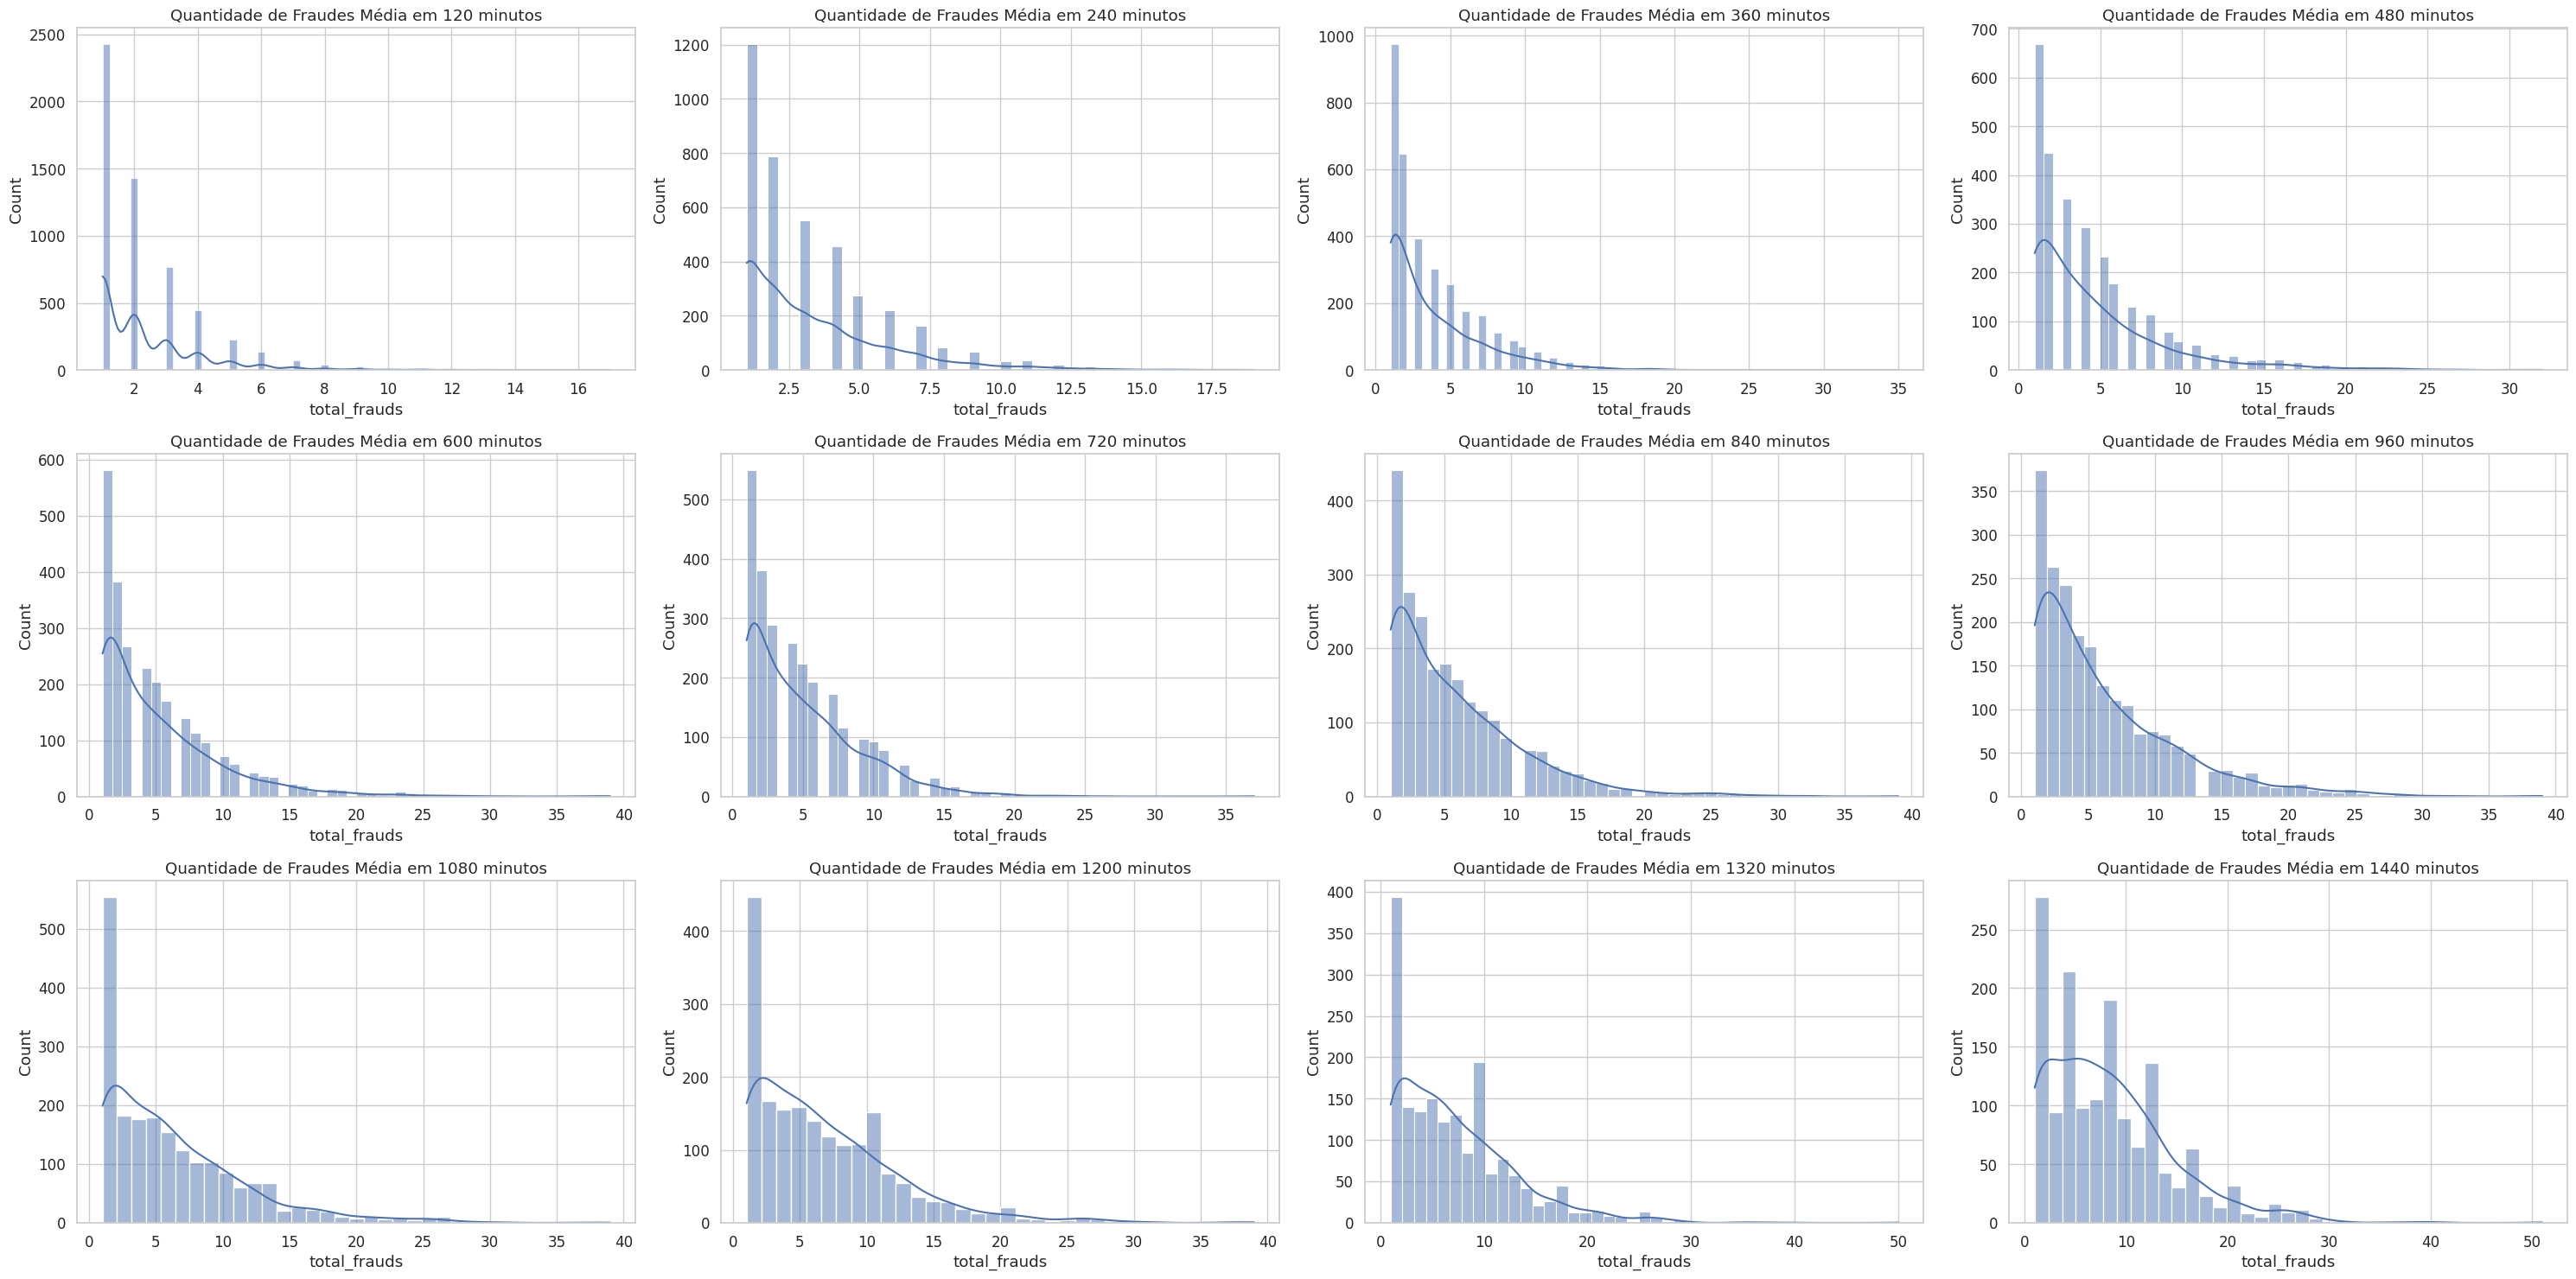

In [25]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [26]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):

  feature_engineering = FraudFeatureEngineer(freq=f'{minute}T')
  df_train = feature_engineering.engineer_features(df.to_pandas())

  builder = BaselineCoutingModel(df_train, f'{minute}m', offset=np.log(df_train['duration_sec'] / 3600))
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/12 [00:00<?, ?it/s]

Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!
Training BASELINE Poisson with window 120m
Training BASELINE Binomial Negativa with window 120m
Training BASELINE ZIP with window 120m
Training BASELINE ZINB with window 120m
Baseline Models Trained
Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!
Training BASELINE Poisson with window 240m
Training BASELINE Binomial

In [27]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=False)
df_report.reset_index(drop=True, inplace=True)
df_report

window         model_name           LLF            BIC           AIC  \
0   1440m  Binomial Negativa  -7375.230552   14766.834033  14754.461104   
1   1320m               ZINB  -7814.074430   15652.968870  15634.148860   
2   1320m  Binomial Negativa  -8032.226120   16080.998914  16068.452241   
3   1200m               ZINB  -8272.790206   16570.686492  16551.580413   
4   1200m  Binomial Negativa  -8482.600837   16981.939060  16969.201673   
5   1440m                ZIP  -8654.593059   17325.559048  17313.186119   
6   1080m               ZINB  -8841.880661   17709.183553  17689.761322   
7   1080m  Binomial Negativa  -9008.839827   18034.627808  18021.679654   
8    960m               ZINB  -9331.161138   18688.097507  18668.322276   
9    960m  Binomial Negativa  -9456.677230   18930.537949  18917.354461   
10  1320m                ZIP  -9466.387063   18949.320800  18936.774126   
11  1200m                ZIP  -9914.607507   19845.952401  19833.215015   
12   840m               ZINB  -9924.798410   19875.772854  19855.596819   
13   840m  Binomial Negativa -10059.176834   20135.804357  20122.353667   
14  1080m                ZIP -10653.247914   21323.443981  21310.495827   
15   720m               ZINB -11214.848314   22456.335046  22435.696629   
16   720m  Binomial Negativa -11392.129872   22802.018690  22788.259745   
17   960m                ZIP -11438.067262   22893.318011  22880.134524   
18   600m  Binomial Negativa -11720.489715   23459.102878  23444.979429   
19   840m                ZIP -11987.970261   23993.391212  23979.940522   
20   720m                ZIP -12557.963793   25133.686530  25119.927586   
21   480m               ZINB -12889.274117   25806.402907  25784.548233   
22   480m  Binomial Negativa -13003.331815   26025.233412  26010.663630   
23   600m                ZIP -13613.005337   27244.134123  27230.010674   
24   480m                ZIP -14829.150952   29676.871686  29662.301904   
25   360m               ZINB -15182.174560   30393.066769  30370.349119   
26   360m  Binomial Negativa -15278.935165   30577.015430  30561.870330   
27   360m                ZIP -16726.133031   33471.411161  33456.266061   
28  1320m            Poisson -17019.180282   -4594.214654  34040.360564   
29  1440m            Poisson -17147.225232    -732.397416  34296.450464   
30  1200m            Poisson -17654.395563   -7256.111791  35310.791126   
31   240m  Binomial Negativa -18326.590286   36673.136556  36657.180572   
32  1080m            Poisson -18488.289934  -10426.383053  36978.579869   
33   240m                ZIP -19060.382600   38140.721184  38124.765200   
34   960m            Poisson -19912.276693  -13436.164987  39826.553386   
35   720m            Poisson -20784.394004  -30506.331445  41570.788007   
36   840m            Poisson -21107.751371  -18756.464215  42217.502742   
37   600m            Poisson -24094.193406  -37902.607411  48190.386812   
38   120m               ZINB -25468.582681   50969.178709  50943.165362   
39   120m  Binomial Negativa -25579.940191   51181.222614  51163.880382   
40   480m            Poisson -26024.003242  -56560.489898  52050.006485   
41   120m                ZIP -26065.679492   52152.701216  52135.358984   
42   360m            Poisson -27662.365506  -91994.940001  55326.731011   
43   240m            Poisson -30836.832927 -164435.475778  61675.665853   
44   120m            Poisson -36279.864649 -401620.478195  72561.729298   
45   240m               ZINB           NaN            NaN           NaN   
46   600m               ZINB           NaN            NaN           NaN   
47  1440m               ZINB           NaN            NaN           NaN   

    Converged      PseudoR2  RMSE_Pearson  Outliers  
0        True  8.086132e-11      0.720857        91  
1        True  3.929479e-11      0.981212       179  
2        True  8.153811e-11      0.765593        94  
3        True  1.215060e-10      0.980268       200  
4        True  6.983425e-11      0.773576       134  
5  

In [28]:
df_report_filter = df_report[df_report.LLF.notna()].groupby('window').agg(count=('window', 'count'), llf=('LLF', 'median'))
df_report_filter.query('count == 4', inplace=True)
df_report_filter.sort_values(by=['llf'], ascending=False, inplace=True)
df_report_filter.reset_index(inplace=True)
df_report_filter

window  count           llf
0  1320m      4  -8749.306592
1  1200m      4  -9198.604172
2  1080m      4  -9831.043870
3   960m      4 -10447.372246
4   840m      4 -11023.573547
5   720m      4 -11975.046833
6   480m      4 -13916.241384
7   360m      4 -16002.534098
8   120m      4 -25822.809842

### Seleção da melhor janela de tempo

In [29]:
selected_builder = list(filter(lambda x: x.window == df_report_filter.loc[0, 'window'], builders))[0]
selected_builder.get_report()

window         model_name           LLF           BIC           AIC  \
0  1320m            Poisson -17019.180282  -4594.214654  34040.360564   
1  1320m  Binomial Negativa  -8032.226120  16080.998914  16068.452241   
2  1320m                ZIP  -9466.387063  18949.320800  18936.774126   
3  1320m               ZINB  -7814.074430  15652.968870  15634.148860   

   Converged      PseudoR2  RMSE_Pearson  Outliers  
0       True  1.887379e-15      2.923676       809  
1       True  8.153811e-11      0.765593        94  
2       True  5.847700e-11      1.307860       350  
3       True  3.929479e-11      0.981212       179

In [30]:
selected_builder.df.head()

total_transactions  total_amount  chip_ratio  \
2010-01-01 00:00:00                2074      92904.03         0.0   
2010-01-01 22:00:00                1776      92892.85         0.0   
2010-01-02 20:00:00                1963      94943.47         0.0   
2010-01-03 18:00:00                1940      92607.88         0.0   
2010-01-04 16:00:00                1846      92506.13         0.0   

                     duration_sec  txn_velocity  avg_txn_value  \
2010-01-01 00:00:00       79200.0      0.576111      44.794614   
2010-01-01 22:00:00       79200.0      0.493333      52.304533   
2010-01-02 20:00:00       79200.0      0.545278      48.366516   
2010-01-03 18:00:00       79200.0      0.538889      47.736021   
2010-01-04 16:00:00       79200.0      0.512778      50.111663   

                     geo_dispersion  merchant_entropy  avg_credit_score  \
2010-01-01 00:00:00       21.218228          5.347912        714.264224   
2010-01-01 22:00:00       20.926476          5.446203        712.390203   
2010-01-02 20:00:00       21.587203          5.430923        716.460520   
2010-01-03 18:00:00       21.610378          5.396481        714.252577   
2010-01-04 16:00:00       20.453615          5.427792        710.826652   

                     error_ratio  ...  day_of_week  is_weekend  is_holiday  \
2010-01-01 00:00:00     0.014465  ...            4           0           1   
2010-01-01 22:00:00     0.016329  ...            4           0           1   
2010-01-02 20:00:00     0.012736  ...            5           1           0   
2010-01-03 18:00:00     0.016495  ...            6           1           0   
2010-01-04 16:00:00     0.010834  ...            0           0           0   

                     txn_volume_change  avg_value_change  velocity_alert  \
2010-01-01 00:00:00           0.000000          0.000000               0   
2010-01-01 22:00:00          -0.143684          0.167652               0   
2010-01-02 20:00:00           0.105293         -0.075290               0   
2010-01-03 18:00:00          -0.011717         -0.013036               0   
2010-01-04 16:00:00          -0.048454          0.049766               0   

                     unique_clients  unique_cards  cards_per_client  frauds  
2010-01-01 00:00:00             859          1227          1.428405     0.0  
2010-01-01 22:00:00             825          1121          1.358788     1.0  
2010-01-02 20:00:00             853          1189          1.393904     0.0  
2010-01-03 18:00:00             873          1205          1.380298     1.0  
2010-01-04 16:00:00             842          1168          1.387173     3.0  

[5 rows x 21 columns]

#### Visualização da distribuição observada dos eventos X modelo dummy

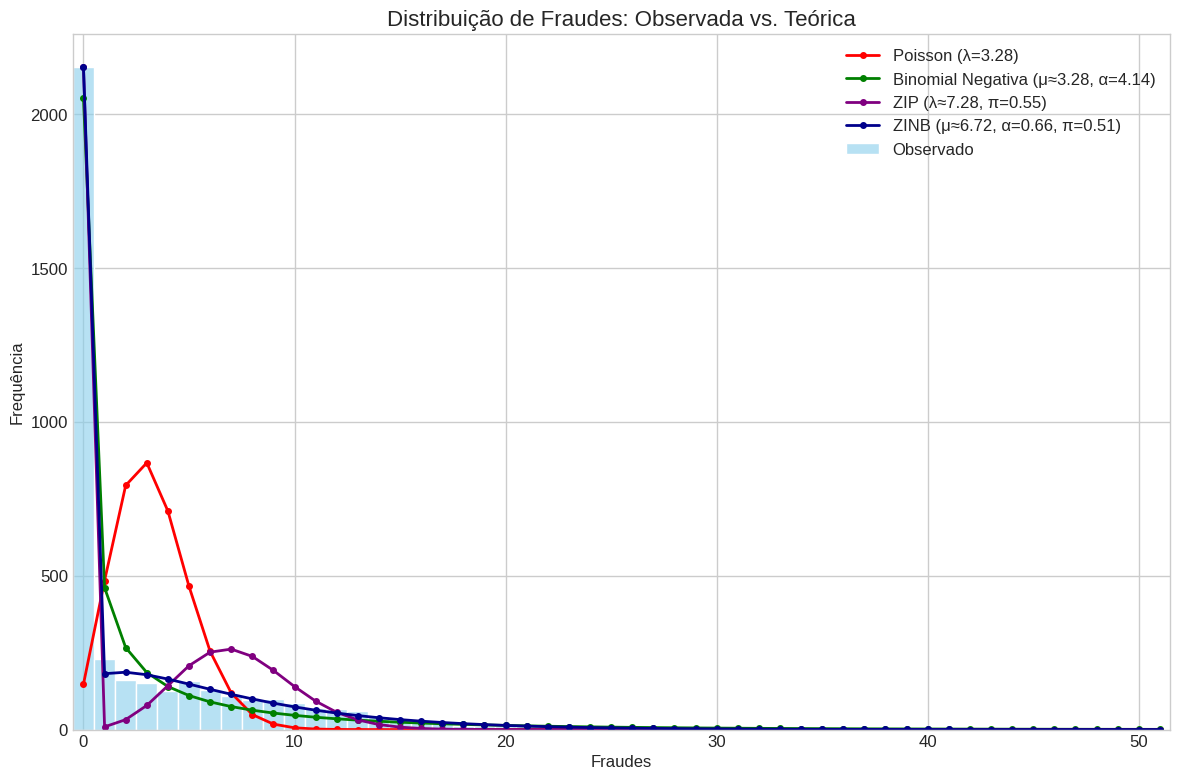

In [31]:
selected_builder.plot_theoretical_distributions()

In [32]:
selected_builder.df.head()

total_transactions  total_amount  chip_ratio  \
2010-01-01 00:00:00                2074      92904.03         0.0   
2010-01-01 22:00:00                1776      92892.85         0.0   
2010-01-02 20:00:00                1963      94943.47         0.0   
2010-01-03 18:00:00                1940      92607.88         0.0   
2010-01-04 16:00:00                1846      92506.13         0.0   

                     duration_sec  txn_velocity  avg_txn_value  \
2010-01-01 00:00:00       79200.0      0.576111      44.794614   
2010-01-01 22:00:00       79200.0      0.493333      52.304533   
2010-01-02 20:00:00       79200.0      0.545278      48.366516   
2010-01-03 18:00:00       79200.0      0.538889      47.736021   
2010-01-04 16:00:00       79200.0      0.512778      50.111663   

                     geo_dispersion  merchant_entropy  avg_credit_score  \
2010-01-01 00:00:00       21.218228          5.347912        714.264224   
2010-01-01 22:00:00       20.926476          5.446203        712.390203   
2010-01-02 20:00:00       21.587203          5.430923        716.460520   
2010-01-03 18:00:00       21.610378          5.396481        714.252577   
2010-01-04 16:00:00       20.453615          5.427792        710.826652   

                     error_ratio  ...  day_of_week  is_weekend  is_holiday  \
2010-01-01 00:00:00     0.014465  ...            4           0           1   
2010-01-01 22:00:00     0.016329  ...            4           0           1   
2010-01-02 20:00:00     0.012736  ...            5           1           0   
2010-01-03 18:00:00     0.016495  ...            6           1           0   
2010-01-04 16:00:00     0.010834  ...            0           0           0   

                     txn_volume_change  avg_value_change  velocity_alert  \
2010-01-01 00:00:00           0.000000          0.000000               0   
2010-01-01 22:00:00          -0.143684          0.167652               0   
2010-01-02 20:00:00           0.105293         -0.075290               0   
2010-01-03 18:00:00          -0.011717         -0.013036               0   
2010-01-04 16:00:00          -0.048454          0.049766               0   

                     unique_clients  unique_cards  cards_per_client  frauds  
2010-01-01 00:00:00             859          1227          1.428405     0.0  
2010-01-01 22:00:00             825          1121          1.358788     1.0  
2010-01-02 20:00:00             853          1189          1.393904     0.0  
2010-01-03 18:00:00             873          1205          1.380298     1.0  
2010-01-04 16:00:00             842          1168          1.387173     3.0  

[5 rows x 21 columns]

In [33]:
selected_builder.df.describe()

total_transactions   total_amount   chip_ratio  duration_sec  \
count         3918.000000    3918.000000  3918.000000        3918.0   
mean          2162.374681  109295.993520     0.346549       79200.0   
std            184.067293    8242.702358     0.352558           0.0   
min             80.000000    6641.420000     0.000000       79200.0   
25%           2034.250000  103871.902500     0.000000       79200.0   
50%           2162.000000  109096.760000     0.000000       79200.0   
75%           2295.750000  114692.650000     0.705070       79200.0   
max           2616.000000  136957.770000     0.734658       79200.0   

       txn_velocity  avg_txn_value  geo_dispersion  merchant_entropy  \
count   3918.000000    3918.000000     3918.000000       3918.000000   
mean       0.600660      50.688209       21.348138          5.515102   
std        0.051130       3.121235        0.300847          0.070386   
min        0.022222      40.017571       20.377970          3.991962   
25%        0.565069      48.437788       21.150057          5.470431   
50%        0.600556      50.300103       21.337290          5.510964   
75%        0.637708      52.798466       21.547944          5.558044   
max        0.726667      83.017750       22.571104          5.741147   

       avg_credit_score  error_ratio  ...  day_of_week   is_weekend  \
count       3918.000000  3918.000000  ...  3918.000000  3918.000000   
mean         714.107944     0.015993  ...     3.000766     0.285860   
std            1.389136     0.002788  ...     2.000191     0.451881   
min          708.837862     0.006323  ...     0.000000     0.000000   
25%          713.170399     0.014074  ...     1.000000     0.000000   
50%          714.131208     0.015873  ...     3.000000     0.000000   
75%          715.033008     0.017803  ...     5.000000     1.000000   
max          718.976524     0.027778  ...     6.000000     1.000000   

        is_holiday  txn_volume_change  avg_value_change  velocity_alert  \
count  3918.000000        3918.000000       3918.000000     3918.000000   
mean      0.028076           0.009845          0.002711        0.006126   
std       0.165210           0.447971          0.072862        0.078036   
min       0.000000          -0.958333         -0.361683        0.000000   
25%       0.000000          -0.036720         -0.040939        0.000000   
50%       0.000000          -0.003616          0.003554        0.000000   
75%       0.000000           0.038934          0.046638        0.000000   
max       1.000000          27.412500          0.647093        1.000000   

       unique_clients  unique_cards  cards_per_client       frauds  
count     3918.000000   3918.000000       3918.000000  3918.000000  
mean       941.621491   1409.708014          1.495187     3.277693  
std         44.058284    104.462481          0.048589     5.293815  
min         74.000000     78.000000          1.054054     0.000000  
25%        917.000000   1344.000000          1.465129     0.000000  
50%        947.000000   1419.000000          1.498418     0.000000  
75%        972.000000   1482.000000          1.529588     5.000000  
max       1027.000000   1642.000000          1.615540    51.000000  

[8 rows x 21 columns]

#### Correlação dos dados no dataframe da janela selecionada

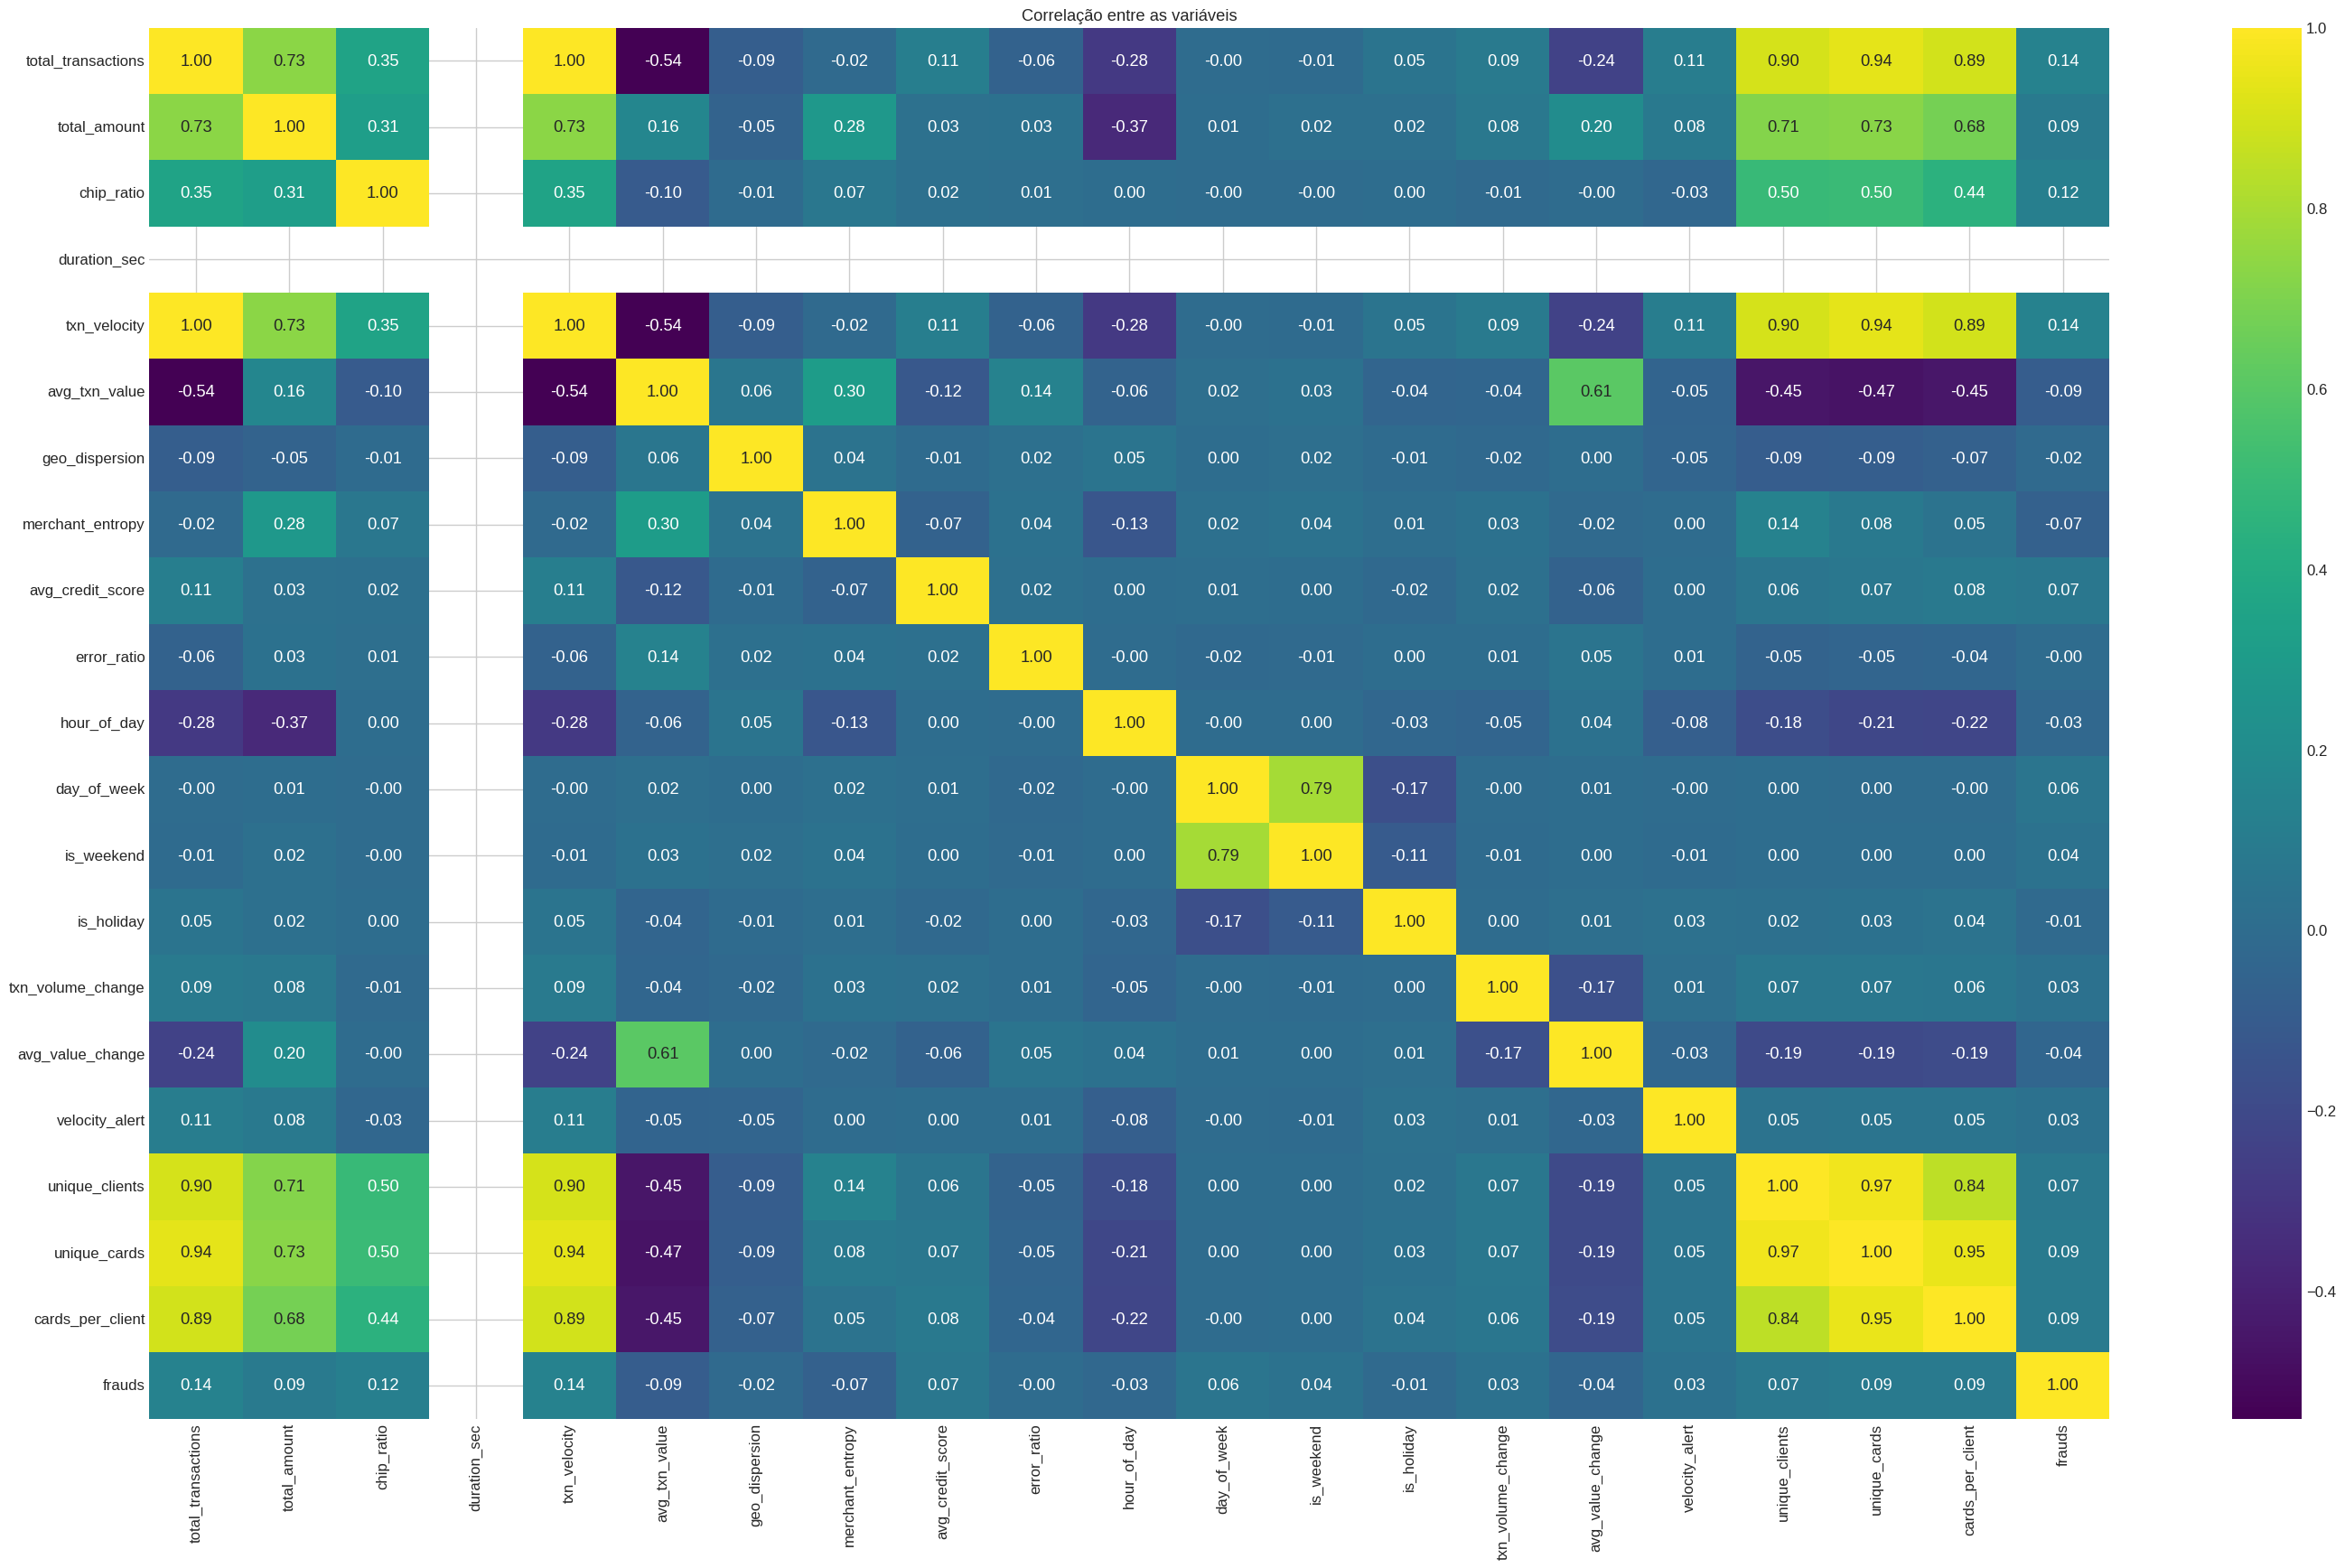

In [34]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

#### Correlação do dataframe após removação de variaveis com alta correlação

In [ ]:
# feature_engineering = FraudFeatureEngineer(freq=selected_builder.window.replace('m', 'T'))
# df_train = feature_engineering.engineer_features(df.to_pandas())

In [ ]:
# selected_builder = BaselineCoutingModel(df_train, selected_builder.window)
# selected_builder.train()

## Modelagem

### **Métricas de Avaliação de Modelos: LLF, AIC e BIC**

Estas métricas são usadas para avaliar e comparar modelos estatísticos, buscando um equilíbrio entre o bom ajuste aos dados e a simplicidade do modelo.

---

### **1. LLF (Log-Likelihood Function / Função de Log-Verossimilhança)**

Mede o quão bem o modelo se ajusta aos dados observados.

* **Foco:** Apenas na qualidade do ajuste.
* **Interpretação:** Quanto **maior** o valor, melhor o modelo explica os dados.
* **Limitação:** Não penaliza a complexidade. Modelos mais complexos quase sempre terão uma LLF maior.

---

### **2. AIC (Akaike Information Criterion / Critério de Informação de Akaike)**

Busca um equilíbrio entre a qualidade do ajuste (LLF) e a complexidade do modelo (número de parâmetros).

* **Fórmula:**
    $$ \text{AIC} = 2k - 2 \ln(\hat{L}) $$
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o melhor modelo para previsões.
* **Interpretação:** O modelo com o **menor** valor de AIC é preferível.

---

### **3. BIC (Bayesian Information Criterion / Critério de Informação Bayesiano)**

Similar ao AIC, mas aplica uma penalidade mais rigorosa à complexidade, especialmente para grandes volumes de dados.

* **Fórmula:**
    $$ \text{BIC} = \ln(n)k - 2 \ln(\hat{L}) $$
    * $n$: número de observações (tamanho da amostra).
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o modelo mais provável de ser o "verdadeiro" gerador dos dados.
* **Interpretação:** O modelo com o **menor** valor de BIC é preferível. Geralmente, seleciona modelos mais simples que o AIC.

---

### **Tabela Resumo**

| Métrica | Foco Principal | Interpretação |
| :--- | :--- | :--- |
| **LLF** | Qualidade do ajuste | Quanto **maior**, melhor |
| **AIC** | Equilíbrio (Ajuste vs. Complexidade) | Quanto **menor**, melhor |
| **BIC** | Equilíbrio (com maior penalidade à complexidade) | Quanto **menor**, melhor |

In [35]:
X = selected_builder.df.copy()
y = X['frauds']

In [36]:
X.describe().T

count           mean          std           min  \
total_transactions  3918.0    2162.374681   184.067293     80.000000   
total_amount        3918.0  109295.993520  8242.702358   6641.420000   
chip_ratio          3918.0       0.346549     0.352558      0.000000   
duration_sec        3918.0   79200.000000     0.000000  79200.000000   
txn_velocity        3918.0       0.600660     0.051130      0.022222   
avg_txn_value       3918.0      50.688209     3.121235     40.017571   
geo_dispersion      3918.0      21.348138     0.300847     20.377970   
merchant_entropy    3918.0       5.515102     0.070386      3.991962   
avg_credit_score    3918.0     714.107944     1.389136    708.837862   
error_ratio         3918.0       0.015993     0.002788      0.006323   
hour_of_day         3918.0      11.006126     6.907202      0.000000   
day_of_week         3918.0       3.000766     2.000191      0.000000   
is_weekend          3918.0       0.285860     0.451881      0.000000   
is_holiday          3918.0       0.028076     0.165210      0.000000   
txn_volume_change   3918.0       0.009845     0.447971     -0.958333   
avg_value_change    3918.0       0.002711     0.072862     -0.361683   
velocity_alert      3918.0       0.006126     0.078036      0.000000   
unique_clients      3918.0     941.621491    44.058284     74.000000   
unique_cards        3918.0    1409.708014   104.462481     78.000000   
cards_per_client    3918.0       1.495187     0.048589      1.054054   
frauds              3918.0       3.277693     5.293815      0.000000   

                              25%            50%            75%            max  
total_transactions    2034.250000    2162.000000    2295.750000    2616.000000  
total_amount        103871.902500  109096.760000  114692.650000  136957.770000  
chip_ratio               0.000000       0.000000       0.705070       0.734658  
duration_sec         79200.000000   79200.000000   79200.000000   79200.000000  
txn_velocity             0.565069       0.600556       0.637708       0.726667  
avg_txn_value           48.437788      50.300103      52.798466      83.017750  
geo_dispersion          21.150057      21.337290      21.547944      22.571104  
merchant_entropy         5.470431       5.510964       5.558044       5.741147  
avg_credit_score       713.170399     714.131208     715.033008     718.976524  
error_ratio              0.014074       0.015873       0.017803       0.027778  
hour_of_day              6.000000      12.000000      18.000000      22.000000  
day_of_week              1.000000       3.000000       5.000000       6.000000  
is_weekend               0.000000       0.000000       1.000000       1.000000  
is_holiday               0.000000       0.000000       0.000000       1.000000  
txn_volume_change       -0.036720      -0.003616       0.038934      27.412500  
avg_value_change        -0.040939       0.003554       0.046638       0.647093  
velocity_alert           0.000000       0.000000       0.000000       1.000000  
unique_clients         917.000000     947.000000     972.000000    1027.000000  
unique_cards          1344.000000    1419.000000    1482.000000    1642.000000  
cards_per_client         1.465129       1.498418       1.529588       1.615540  
frauds                   0.000000       0.000000       5.000000      51.000000

In [37]:
y.value_counts()

frauds
0.0     2154
1.0      228
2.0      160
5.0      159
3.0      152
6.0      129
4.0      127
7.0      108
9.0      100
8.0       97
10.0      85
11.0      69
12.0      67
13.0      59
14.0      45
15.0      32
17.0      27
16.0      26
19.0      13
18.0      12
20.0      11
21.0      11
25.0       9
23.0       7
22.0       7
29.0       4
26.0       4
27.0       4
28.0       3
24.0       3
30.0       2
40.0       1
51.0       1
39.0       1
36.0       1
Name: count, dtype: int64

### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [38]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [39]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds', 'duration_sec']).columns)
formula

'frauds ~ total_transactions + total_amount + chip_ratio + txn_velocity + avg_txn_value + geo_dispersion + merchant_entropy + avg_credit_score + error_ratio + hour_of_day + day_of_week + is_weekend + is_holiday + txn_volume_change + avg_value_change + velocity_alert + unique_clients + unique_cards + cards_per_client'

In [40]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson(), offset=np.log(X['duration_sec'] / 3600)).fit()

In [41]:
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3899
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15643.
Date:                Tue, 26 Aug 2025   Deviance:                       25061.
Time:                        13:31:19   Pearson chi2:                 3.02e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5045
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.2757      7.253      2.382      0.017       3.059      31.492
total_transactions    -0.0009      0.001     -1.047      0.295      -0.003       0.001
total_amount           0.0001   1.58e-05      9.238      0.000       0.000       0.000
chip_ratio             1.1149      0.037     30.301      0.000       1.043       1.187
txn_velocity       -2.468e-07   2.36e-07     -1.047      0.295   -7.09e-07    2.15e-07
avg_txn_value         -0.3091      0.034     -9.059      0.000      -0.376      -0.242
geo_dispersion        -0.0682      0.030     -2.265      0.024      -0.127      -0.009
merchant_entropy      -0.3097      0.166     -1.864      0.062      -0.635       0.016
avg_credit_score       0.0374      0.007      5.709      0.000       0.025       0.050
error_ratio            4.4477      3.265      1.362      0.173      -1.952      10.847
hour_of_day            0.0092      0.001      6.573      0.000       0.006       0.012
day_of_week            0.0591      0.007      7.905      0.000       0.044       0.074
is_weekend            -0.0616      0.032     -1.939      0.053      -0.124       0.001
is_holiday            -0.1283      0.058     -2.216      0.027      -0.242      -0.015
txn_volume_change      0.0310      0.012      2.516      0.012       0.007       0.055
avg_value_change      -0.0879      0.167     -0.528      0.598      -0.414       0.239
velocity_alert        -0.0872      0.089     -0.980      0.327      -0.262       0.087
unique_clients        -0.0319      0.004     -7.526      0.000      -0.040      -0.024
unique_cards           0.0085      0.003      2.840      0.005       0.003       0.014
cards_per_client     -15.9282      2.792     -5.705      0.000     -21.400     -10.456
======================================================================================
"""

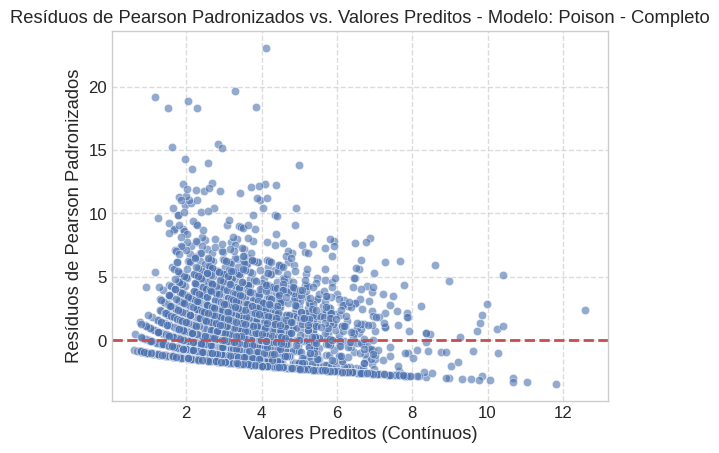

In [42]:
overdisp_plot(modelo_poisson, 'Poison - Completo')

In [43]:
diagnosticar_dispersao_ct(modelo_poisson, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(8.009818296772462),
 'p_valor': np.float64(1.5018707974205035e-15)}

O gráfico acima demonstra como o modelo tem dificuldade para prever os valores. O um padrão de funil no dados demonstra que o presuposto de equidispersão não foi atendido, e a variância dos resíduos não é constante em relação à média prevista, sendo muito maior para contagens baixas.

In [44]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.070     
Dependent Variable:     ystar            AIC:                         35543.2778
Date:                   2025-08-26 13:31 BIC:                         35549.5511
No. Observations:       3918             Log-Likelihood:              -17771.   
Df Model:               1                F-statistic:                 296.7     
Df Residuals:           3917             Prob (F-statistic):          3.81e-64  
R-squared (uncentered): 0.070            Scale:                       509.62    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.7091         0.0992       17.2243       0.0000       1.5145       1.9036
--

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [45]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('txn_volume_change') + Q('avg_value_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('avg_value_change')" with p-value equal to 0.597585258942948 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('txn_volume_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type..

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3905
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15649.
Date:                Tue, 26 Aug 2025   Deviance:                       25072.
Time:                        13:31:28   Pearson chi2:                 3.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5032
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 15.0819      5.185      2.909      0.004       4.920      25.243
Q('total_amount')          0.0001    3.1e-06     41.824      0.000       0.000       0.000
Q('chip_ratio')            1.1192      0.036     30.738      0.000       1.048       1.191
Q('avg_txn_value')        -0.2771      0.006    -42.731      0.000      -0.290      -0.264
Q('geo_dispersion')       -0.0702      0.030     -2.341      0.019      -0.129      -0.011
Q('avg_credit_score')      0.0376      0.007      5.750      0.000       0.025       0.050
Q('hour_of_day')           0.0095      0.001      6.900      0.000       0.007       0.012
Q('day_of_week')           0.0472      0.004     10.513      0.000       0.038       0.056
Q('is_holiday')           -0.1405      0.058     -2.440      0.015      -0.253      -0.028
Q('txn_volume_change')     0.0329      0.012      2.746      0.006       0.009       0.056
Q('unique_clients')       -0.0298      0.002    -16.100      0.000      -0.033      -0.026
Q('unique_cards')          0.0069      0.001      5.108      0.000       0.004       0.010
Q('cards_per_client')    -14.5613      1.424    -10.224      0.000     -17.353     -11.770
==========================================================================================
"""

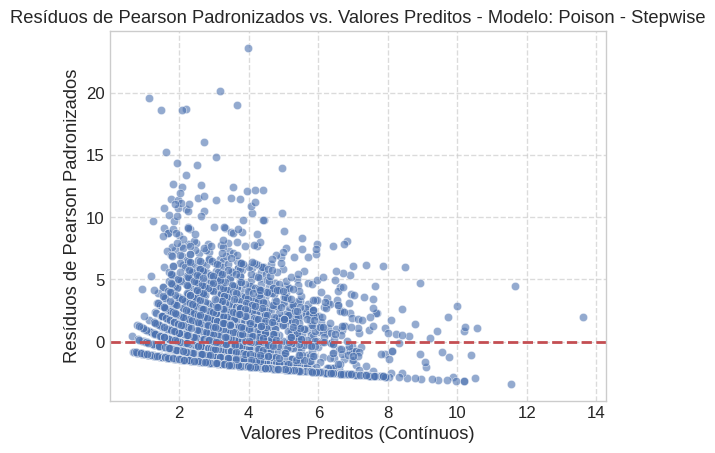

In [46]:
overdisp_plot(modelo_poisson_stepwise, 'Poison - Stepwise')

In [47]:
diagnosticar_dispersao_ct(modelo_poisson_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(7.7098544456056075),
 'p_valor': np.float64(1.5866016173191973e-14)}

O gráfico apresenta o mesmo problema relatado no modelo completo, não atendendo o critério de equidispersão.

In [48]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.067     
Dependent Variable:     ystar            AIC:                         35714.6314
Date:                   2025-08-26 13:31 BIC:                         35720.9047
No. Observations:       3918             Log-Likelihood:              -17856.   
Df Model:               1                F-statistic:                 283.5     
Df Residuals:           3917             Prob (F-statistic):          1.78e-61  
R-squared (uncentered): 0.067            Scale:                       532.40    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.7077         0.1014       16.8378       0.0000       1.5089       1.9066
--

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [49]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

#### Implementação dos modelos

##### Completo

In [50]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial(), offset=np.log(X['duration_sec'] / 3600)).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3899
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8751.4
Date:                Tue, 26 Aug 2025   Deviance:                       7733.2
Time:                        13:31:47   Pearson chi2:                 7.90e+03
No. Iterations:                    53   Pseudo R-squ. (CS):             0.1690
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             32.7419     16.276      2.012      0.044       0.841      64.643
total_transactions    -0.0029      0.002     -1.493      0.135      -0.007       0.001
total_amount           0.0002   3.63e-05      5.270      0.000       0.000       0.000
chip_ratio             1.2629      0.073     17.366      0.000       1.120       1.405
txn_velocity       -8.067e-07    5.4e-07     -1.493      0.135   -1.87e-06    2.52e-07
avg_txn_value         -0.4193      0.078     -5.394      0.000      -0.572      -0.267
geo_dispersion        -0.0861      0.063     -1.367      0.172      -0.210       0.037
merchant_entropy      -0.6937      0.347     -2.001      0.045      -1.373      -0.014
avg_credit_score       0.0473      0.014      3.438      0.001       0.020       0.074
error_ratio            7.6361      6.823      1.119      0.263      -5.737      21.009
hour_of_day            0.0092      0.003      3.044      0.002       0.003       0.015
day_of_week            0.0711      0.016      4.583      0.000       0.041       0.101
is_weekend            -0.0863      0.067     -1.281      0.200      -0.218       0.046
is_holiday            -0.1201      0.117     -1.023      0.307      -0.350       0.110
txn_volume_change      0.0296      0.039      0.751      0.453      -0.048       0.107
avg_value_change       0.5235      0.355      1.473      0.141      -0.173       1.220
velocity_alert        -0.2914      0.234     -1.244      0.214      -0.751       0.168
unique_clients        -0.0478      0.010     -4.855      0.000      -0.067      -0.029
unique_cards           0.0183      0.007      2.648      0.008       0.005       0.032
cards_per_client     -25.3163      6.412     -3.948      0.000     -37.884     -12.749
======================================================================================
"""

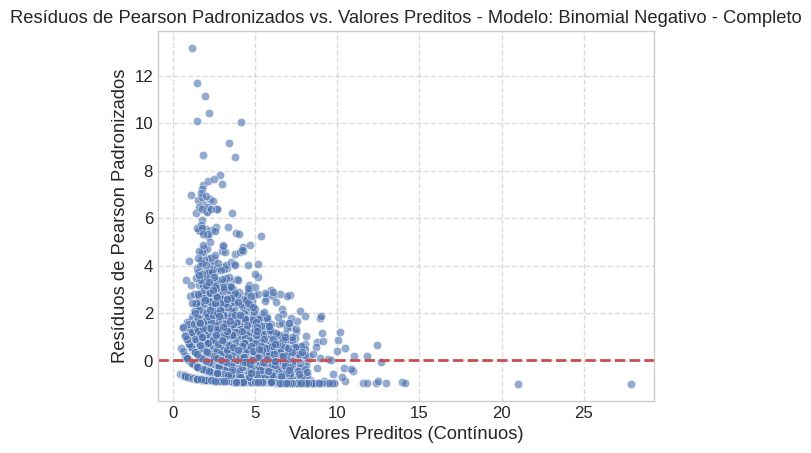

In [51]:
overdisp_plot(modelo_binomial, 'Binomial Negativo - Completo')

In [52]:
diagnosticar_dispersao_ct(modelo_binomial, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(13.709639191787646),
 'p_valor': np.float64(8.095678080125664e-42)}

O gráfico de dispersão de residuos demonstra que o modelo conseguiu capturar melhor a relação dos dados uma vez que o presuposto do modelo foi atendido. No entanto nota-se que o modelo teve um problema com outlier, indicando que algum comportamento não foi corretamente mapeado. A alta concentração no eixo vertical proximo a zero pode indicar que o modelo esteja tendo dificuldades para identificar quando a classificação seja realmente um zero estrutural.

##### Stepwise

In [53]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('txn_volume_change') + Q('avg_value_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('txn_volume_change')" with p-value equal to 0.45292536863898447 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('avg_value_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 F

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3907
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8757.6
Date:                Tue, 26 Aug 2025   Deviance:                       7745.6
Time:                        13:31:57   Pearson chi2:                 7.98e+03
No. Iterations:                    63   Pseudo R-squ. (CS):             0.1663
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.6911     10.813      1.544      0.123      -4.501      37.883
Q('total_amount')         0.0001   6.82e-06     19.910      0.000       0.000       0.000
Q('chip_ratio')           1.2520      0.072     17.415      0.000       1.111       1.393
Q('avg_txn_value')       -0.2889      0.015    -19.820      0.000      -0.317      -0.260
Q('merchant_entropy')    -0.8641      0.329     -2.623      0.009      -1.510      -0.218
Q('avg_credit_score')     0.0485      0.014      3.538      0.000       0.022       0.075
Q('hour_of_day')          0.0096      0.003      3.181      0.001       0.004       0.015
Q('day_of_week')          0.0560      0.009      5.979      0.000       0.038       0.074
Q('unique_clients')      -0.0362      0.004     -8.157      0.000      -0.045      -0.028
Q('unique_cards')         0.0105      0.003      3.359      0.001       0.004       0.017
Q('cards_per_client')   -18.1629      3.256     -5.579      0.000     -24.544     -11.782
=========================================================================================
"""

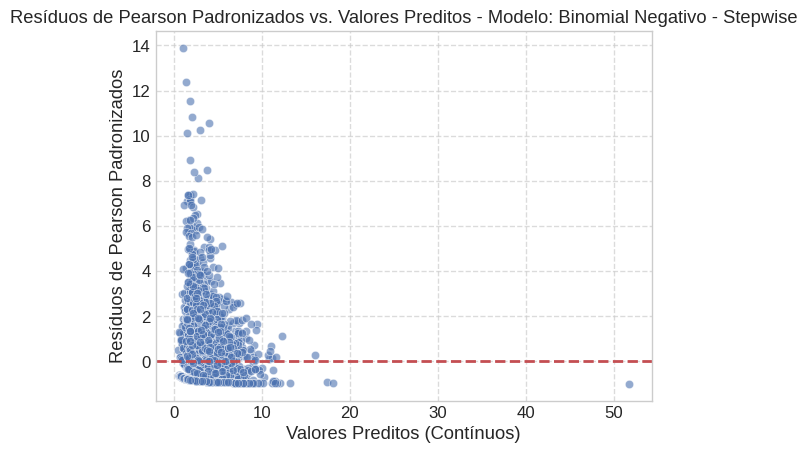

In [54]:
overdisp_plot(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

In [55]:
diagnosticar_dispersao_ct(modelo_binomial_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(35.891378755370134),
 'p_valor': np.float64(3.755643786405286e-244)}

O modelo stepwise apresenta o mesmo comportamento em relação ao modelo completo.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.

#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [56]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

##### Completo

In [57]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()
X1 = sm.add_constant(X1)

In [65]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'] / 3600)).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3899
Method:                            MLE   Df Model:                           18
Date:                 Tue, 26 Aug 2025   Pseudo R-squ.:                  -5477.
Time:                         13:33:26   Log-Likelihood:            -5.1861e+07
converged:                       False   LL-Null:                       -9466.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_const                  0.1000        nan        nan        nan         nan         nan
inflate_total_transactions     0.1000        nan        nan        nan         nan         nan
inflate_total_amount           0.1000        nan        nan        nan         nan         nan
inflate_chip_ratio             0.1000        nan        nan        nan         nan         nan
inflate_txn_velocity           0.1000        nan        nan        nan         nan         nan
inflate_avg_txn_value          0.1000        nan        nan        nan         nan         nan
inflate_geo_dispersion         0.1000        nan        nan        nan         nan         nan
inflate_merchant_entropy       0.1000        nan        nan        nan         nan         nan
inflate_avg_credit_score       0.1000        nan        nan        nan         nan         nan
inflate_error_ratio            0.1000        nan        nan        nan         nan         nan
inflate_hour_of_day            0.1000        nan        nan        nan         nan         nan
inflate_day_of_week            0.1000        nan        nan        nan         nan         nan
inflate_is_weekend             0.1000        nan        nan        nan         nan         nan
inflate_is_holiday             0.1000        nan        nan        nan         nan         nan
inflate_txn_volume_change      0.1000        nan        nan        nan         nan         nan
inflate_avg_value_change       0.1000        nan        nan        nan         nan         nan
inflate_velocity_alert         0.1000        nan        nan        nan         nan         nan
inflate_unique_clients         0.1000        nan        nan        nan         nan         nan
inflate_unique_cards           0.1000        nan        nan        nan         nan         nan
inflate_cards_per_client       0.1000        nan        nan        nan         nan         nan
const                         -1.9680        nan        nan        nan         nan         nan
total_transactions             0.0003        nan        nan        nan         nan         nan
total_amount                  -0.0365        nan        nan        nan         nan         nan
chip_ratio                     0.0010        nan        nan        nan         nan         nan
txn_velocity                   0.0010        nan        nan        nan         nan         nan
avg_txn_value                  0.0010        nan        nan        nan         nan         nan
geo_dispersion                 0.0010        nan        nan        nan         nan         nan
merchant_entropy               0.0010        nan        nan        nan         nan         nan
avg_credit_score               0.0008        nan        nan        nan         nan         nan
error_ratio                    0.0010        nan        nan        nan         nan         nan
hour_of_day                    0.0010        nan        nan        nan         nan         nan
da

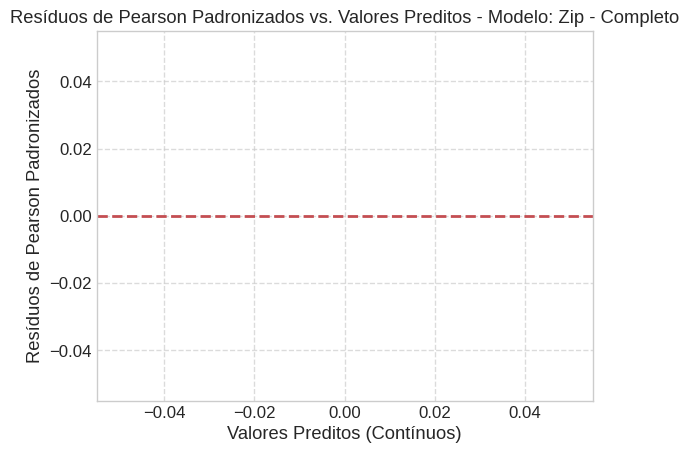

In [66]:
overdisp_plot(modelo_zip, 'Zip - Completo')

In [67]:
diagnosticar_dispersao_ct(modelo_zip, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: nan
Resultado (α = 0.05): Falha em rejeitar a hipótese nula.
Conclusão: O pressuposto de dispersão do modelo é considerado adequado.
-------------------------------------------------------------


{'estatistica_t': np.float64(nan), 'p_valor': np.float64(nan)}

Igual ao modelo Poisson, o modelo ZIP apresenta problemas de sobredispersão, quando a média é menor que a variância. O modelo tem diculdades para modelar os componentes de contagem e zeros estruturais uma vez que o presuposto do modelo Poisson não foi atendido e todos as features foram incluídas em ambos componentes.

In [68]:
vuong_test(modelo_poisson, modelo_zip)

         Current function value: 86432830101429065206923854450820899558916096.000000
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

##### Stepwise

In [69]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [70]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='LLF',
#    cov_type='HC1',
    verbose=False,
 #   method='lbfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=45
)
random_selector_zip = RandomFeatureSelector(step_wise, max_features=0.75, random_state=45)
random_selector_zip.fit(X1, y, np.log(X['duration_sec']/3600))

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=StepwiseZeroInflated(convergence_strictness='low',
                                                     selection_criterion='LLF',
                                                     verbose=False),
                      max_features=0.75, random_state=45)

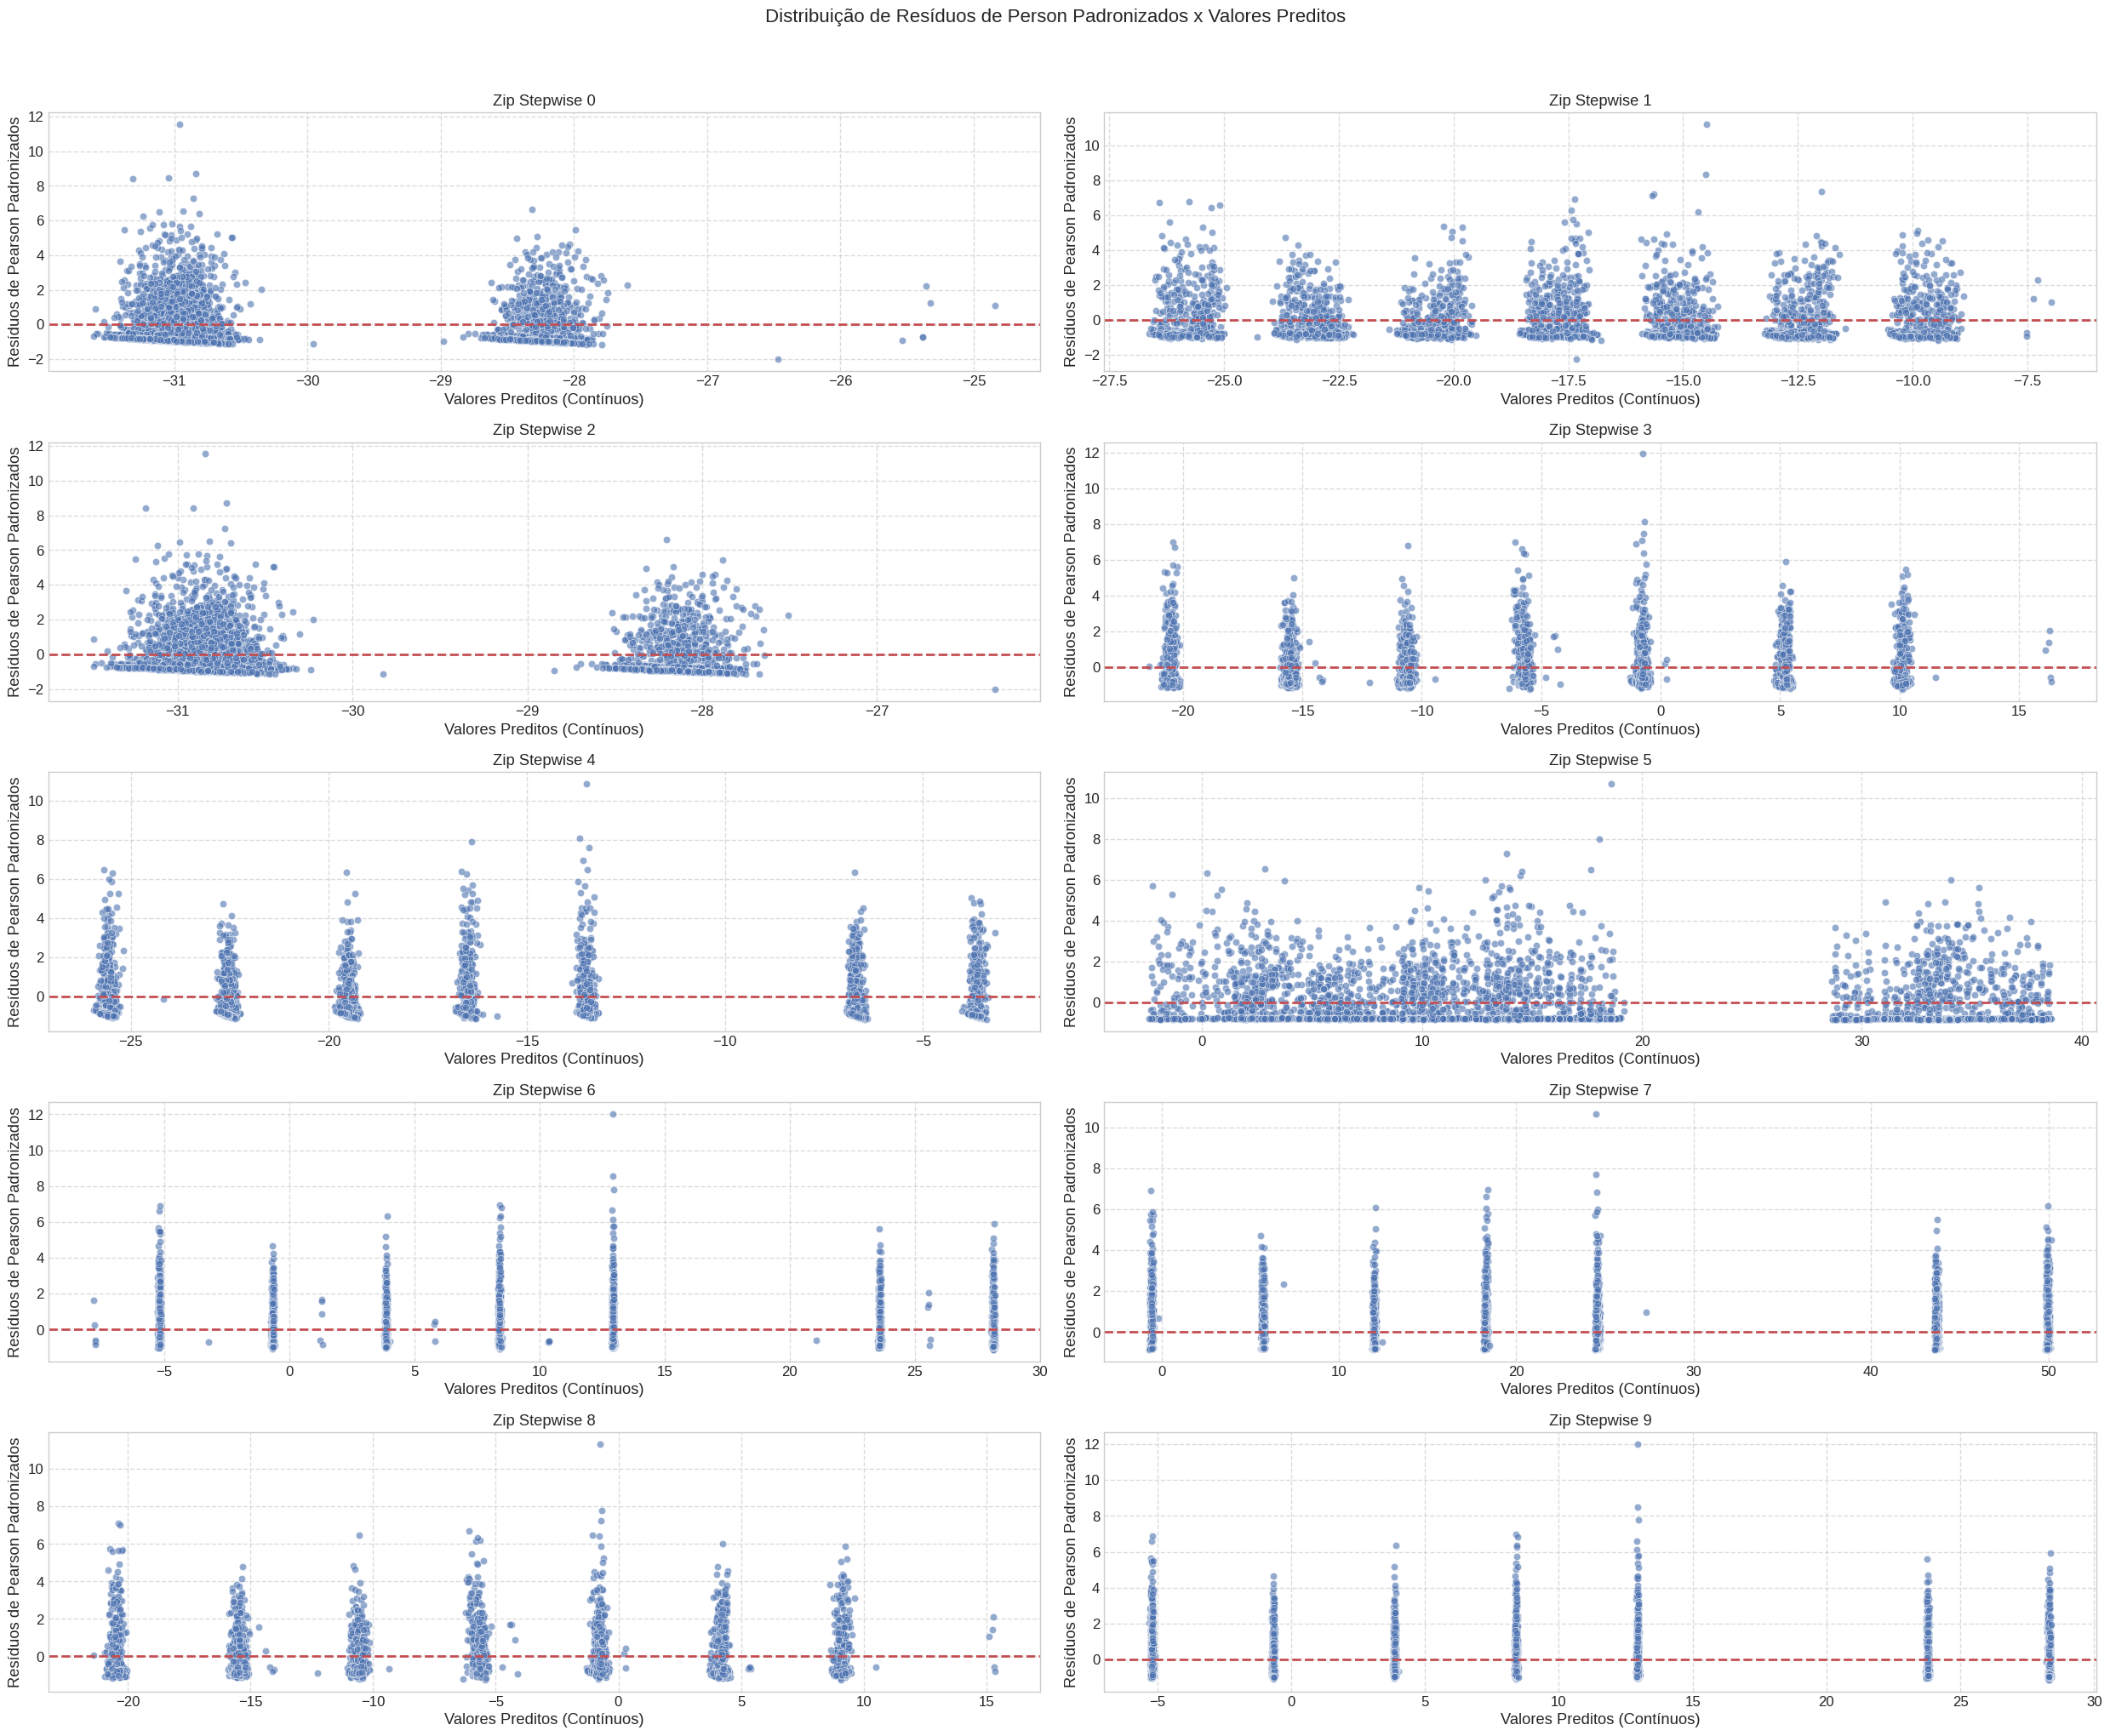

In [71]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_zip.models)):
    plt.subplot(5, 2, i+1)
    overdisp_plot(model, f'Zip Stepwise {i}', "{}")

plt.tight_layout()
plt.show()

In [72]:
df_trained_zip = pd.DataFrame(list(map(lambda x: dict(iter=x['iter'], llf=x['model'].llf, bic=x['model'].bic, aic=x['model'].aic, params=len(x['model'].params)),
        filter(lambda x: x['model'].converged,
        map(lambda x: dict(iter=x[0], model=x[1].final_model_), enumerate(random_selector_zip.models))))))
df_trained_zip = df_trained_zip.sort_values(by=['bic'], ascending=True).reset_index(drop=True)
df_trained_zip

iter          llf           bic           aic  params
0     8 -9056.075862  18211.431764  18136.151725      12
1     3 -9057.112187  18213.504413  18138.224374      12
2     9 -9072.016044  18235.038791  18166.032089      11
3     6 -9069.894433  18239.068906  18163.788867      12
4     4 -9101.128756  18268.444205  18218.257513       8
5     7 -9126.378285  18327.216599  18270.756570       9
6     5 -9148.471519  18363.129731  18312.943039       8
7     1 -9173.527551  18429.788469  18367.055103      10
8     0 -9192.022220  18458.504469  18402.044439       9
9     2 -9205.778681  18477.744055  18427.557362       8

In [84]:
best_model_index_zip = df_trained_zip.loc[0, 'iter']
best_model_index_zip

np.int64(8)

In [85]:
modelo_zip_stepwise = random_selector_zip.models[best_model_index_zip].final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3911
Method:                            MLE   Df Model:                            6
Date:                 Tue, 26 Aug 2025   Pseudo R-squ.:                 0.04334
Time:                         14:07:12   Log-Likelihood:                -9056.1
converged:                        True   LL-Null:                       -9466.4
Covariance Type:             nonrobust   LLR p-value:                5.388e-174
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const              -24.6146      3.157     -7.796      0.000     -30.803     -18.427
inflate_chip_ratio          -1.1499      0.107    -10.719      0.000      -1.360      -0.940
inflate_cards_per_client     4.9233      0.800      6.154      0.000       3.355       6.491
inflate_merchant_entropy     3.2367      0.514      6.298      0.000       2.229       4.244
inflate_avg_value_change     1.0205      0.465      2.195      0.028       0.109       1.932
const                       -1.4107      0.396     -3.558      0.000      -2.188      -0.634
txn_velocity                 6.0858      0.400     15.201      0.000       5.301       6.871
day_of_week                  0.0498      0.005     11.055      0.000       0.041       0.059
cards_per_client            -2.5026      0.398     -6.290      0.000      -3.282      -1.723
error_ratio                 12.5113      3.298      3.794      0.000       6.048      18.975
avg_value_change             0.2833      0.126      2.244      0.025       0.036       0.531
velocity_alert               0.1924      0.089      2.167      0.030       0.018       0.366
============================================================================================
"""

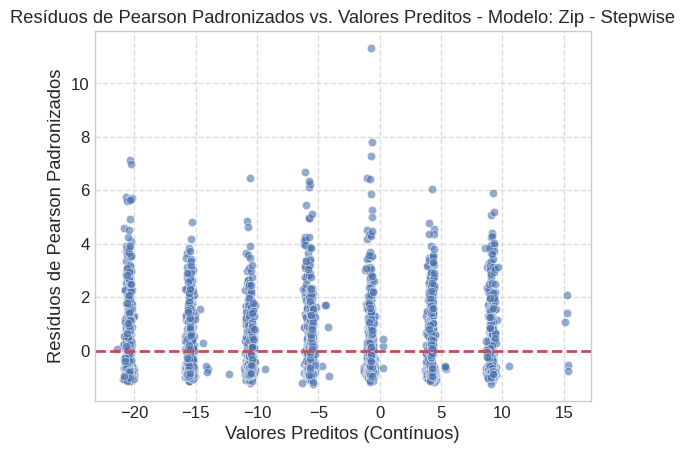

In [86]:
overdisp_plot(modelo_zip_stepwise, 'Zip - Stepwise')

In [87]:
diagnosticar_dispersao_ct(modelo_zip_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(6.719757266610463),
 'p_valor': np.float64(2.0830730048992533e-11)}

In [88]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

         Current function value: 7363867086559577896704694750374130731712512.000000
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


O modelo apresentou uma melhora significativa em relação ao modelo zip completo uma vez que agora os residuos estão bem mais espelhados em torno da linha vermelha (y=0). No entanto ainda é perceptivo uma dispersão maior ao longo que os valores preditos aumentam, indicando ainda sobredispersão.

Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância é maior que a média.

In [89]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

##### Completo

In [90]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy(deep=True)
X1 = sm.add_constant(X1)

In [91]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'] / 3600)).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zinb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3899
Method:                                      MLE   Df Model:                           18
Date:                           Tue, 26 Aug 2025   Pseudo R-squ.:                     nan
Time:                                   14:07:51   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                       nan
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_const                 -0.0007        nan        nan        nan         nan         nan
inflate_total_transactions    -1.4391        nan        nan        nan         nan         nan
inflate_total_amount         -69.9522        nan        nan        nan         nan         nan
inflate_chip_ratio            -0.0003        nan        nan        nan         nan         nan
inflate_txn_velocity          -0.0004        nan        nan        nan         nan         nan
inflate_avg_txn_value         -0.0320        nan        nan        nan         nan         nan
inflate_geo_dispersion        -0.0140        nan        nan        nan         nan         nan
inflate_merchant_entropy      -0.0036        nan        nan        nan         nan         nan
inflate_avg_credit_score      -0.4688        nan        nan        nan         nan         nan
inflate_error_ratio         -1.03e-05        nan        nan        nan         nan         nan
inflate_hour_of_day           -0.0079        nan        nan        nan         nan         nan
inflate_day_of_week           -0.0020        nan        nan        nan         nan         nan
inflate_is_weekend            -0.0002        nan        nan        nan         nan         nan
inflate_is_holiday         -1.603e-05        nan        nan        nan         nan         nan
inflate_txn_volume_change  -1.979e-05        nan        nan        nan         nan         nan
inflate_avg_value_change    1.531e-05        nan        nan        nan         nan         nan
inflate_velocity_alert     -4.872e-06        nan        nan        nan         nan         nan
inflate_unique_clients        -0.6189        nan        nan        nan         nan         nan
inflate_unique_cards          -0.9284        nan        nan        nan         nan         nan
inflate_cards_per_client      -0.0010        nan        nan        nan         nan         nan
const                        -35.7195        nan        nan        nan         nan         nan
total_transactions         -2699.2672        nan        nan        nan         nan         nan
total_amount                1031.4945        nan        nan        nan         nan         nan
chip_ratio                     0.0055        nan        nan        nan         nan         nan
txn_velocity                9.794e+06        nan        nan        nan         nan         nan
avg_txn_value                  0.4599        nan        nan        nan         nan         nan
geo_dispersion                 0.2043        nan        nan        nan         nan         nan
merchant_entropy               0.0517        nan        nan        nan         nan         nan
avg_credit_score               6.8155        nan        nan        nan         nan         nan
error_ratio                   -0.0528        nan        nan        nan         nan         nan
hour_of

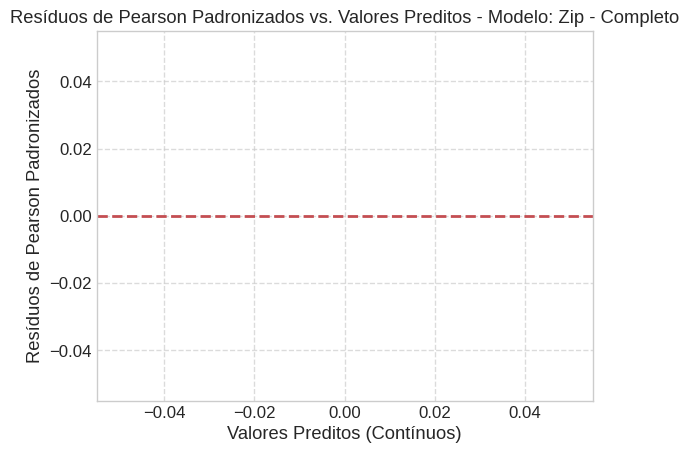

In [92]:
overdisp_plot(modelo_zinb, 'Zip - Completo')

In [93]:
diagnosticar_dispersao_ct(modelo_zinb, y)

Ocorreu um erro ao executar o teste: exog contains inf or nans


{'estatistica_t': nan, 'p_valor': nan}

O gráfico mostra que o modelo prevê quase sempre valores próximos de zero, mas quando ocorrem contagens positivas ele não consegue explicar bem, gerando erros muito grandes.
Isso significa que o modelo está superestimando zeros e subestimando casos com eventos reais.
Os resíduos deveriam se espalhar de forma equilibrada em torno de zero, mas aqui aparecem concentrados e com cauda longa para cima, sinal claro de mau ajuste.

In [94]:
vuong_test(modelo_binomial, modelo_zinb)

         Current function value: 77.021832
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


##### Stepwise

In [95]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [96]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
#     cov_type='HC1',
    verbose=False,
#    method='lbfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=40
)
random_selector_bneg = RandomFeatureSelector(step_wise, max_features=0.75, random_state=40)
random_selector_bneg.fit(X1, y, np.log(X['duration_sec']/3600))

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=StepwiseZeroInflated(convergence_strictness='low',
                                                     model_type='ZINB',
                                                     selection_criterion='LLF',
                                                     verbose=False),
                      max_features=0.75, random_state=40)

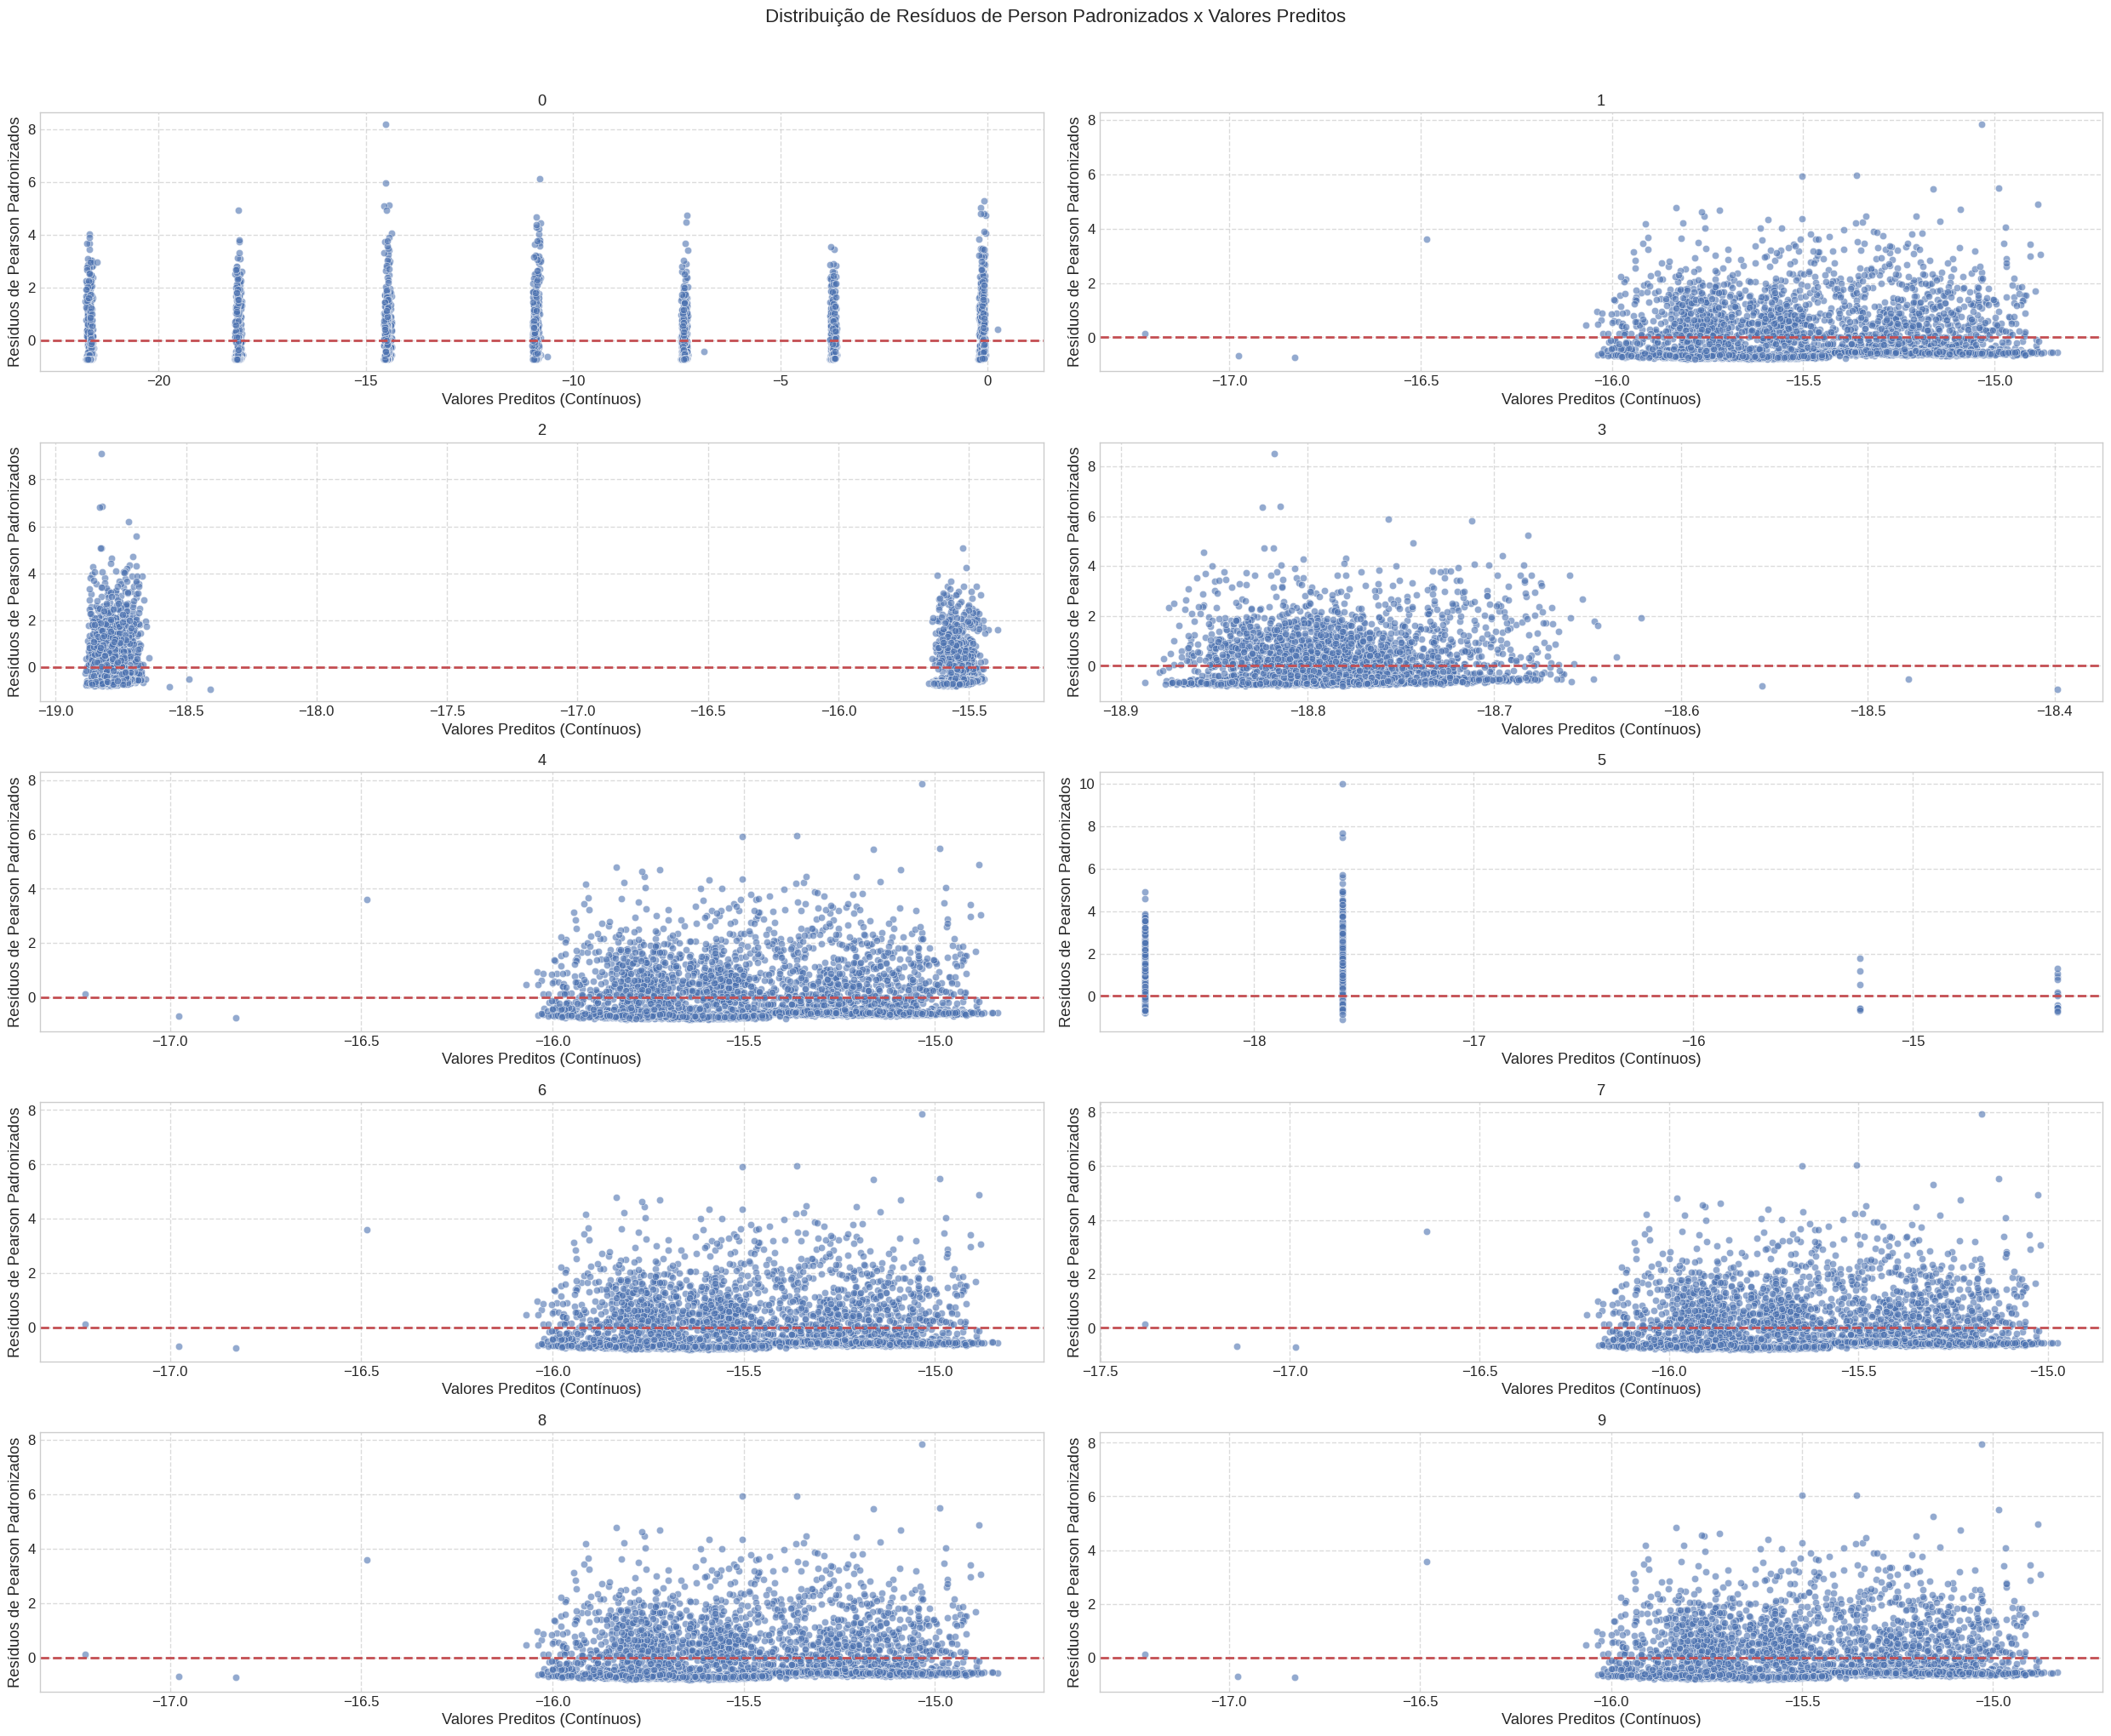

In [97]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_bneg.models)):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, str(i), "{}")

plt.tight_layout()
plt.show()

In [98]:
df_trained_zinb = pd.DataFrame(list(map(lambda x: dict(iter=x['iter'], llf=x['model'].llf, bic=x['model'].bic, aic=x['model'].aic, params=len(x['model'].params)),
        filter(lambda x: x['model'].converged,
        map(lambda x: dict(iter=x[0], model=x[1].final_model_), enumerate(random_selector_bneg.models))))))
df_trained_zinb = df_trained_zinb.sort_values(by=['bic'], ascending=True)
best_model_index_zinb = df_trained_zinb.loc[0, 'iter']
best_model_index_zinb

np.int64(0)

In [99]:
modelo_zinb_stepwise = random_selector_bneg.models[best_model_index_zinb].final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3915
Method:                                      MLE   Df Model:                            2
Date:                           Tue, 26 Aug 2025   Pseudo R-squ.:                 0.01220
Time:                                   14:35:50   Log-Likelihood:                -7718.7
converged:                                  True   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                 3.924e-42
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const          0.3533      0.050      7.095      0.000       0.256       0.451
inflate_chip_ratio    -0.8043      0.098     -8.225      0.000      -0.996      -0.613
const                 -3.5889      0.232    -15.490      0.000      -4.043      -3.135
txn_velocity           3.7297      0.379      9.848      0.000       2.987       4.472
day_of_week            0.0489      0.010      4.828      0.000       0.029       0.069
alpha                  0.5705      0.034     16.844      0.000       0.504       0.637
======================================================================================
"""

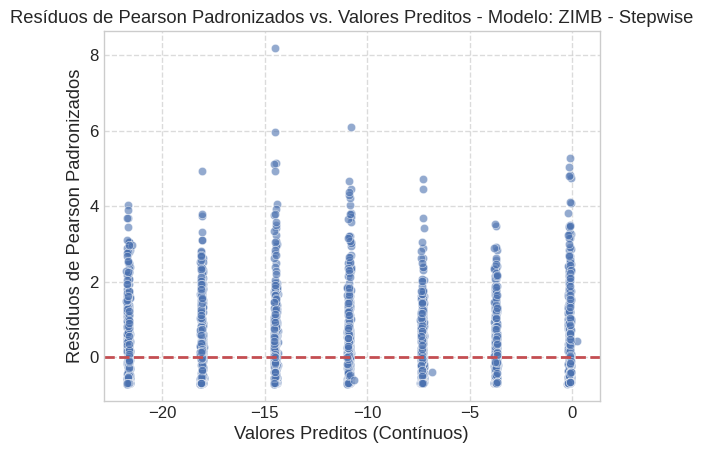

In [100]:
overdisp_plot(modelo_zinb_stepwise, 'ZIMB - Stepwise')

In [101]:
diagnosticar_dispersao_ct(modelo_zinb_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(7.677843674205138),
 'p_valor': np.float64(2.030296036580379e-14)}

O modelo stepwise apresenta previsões mais altas e consistentes, evitando o excesso de zeros visto no modelo anterior.
Os resíduos estão mais próximos de zero e com menor amplitude, sinal de um ajuste mais estável.
Ainda assim, surgem faixas verticais de pontos, indicando previsões pouco flexíveis e repetitivas.
Existem alguns resíduos acima de 5, mostrando que erros relevantes ainda ocorrem.

In [102]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

         Current function value: 74.892739
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -571.004
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


### Comparação dos modelos com base em seu Log-Likelihood Function (LLF)

## Análise do melhor modelo

In [103]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Completo'
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    modelo_zinb,
    modelo_zinb_stepwise
]

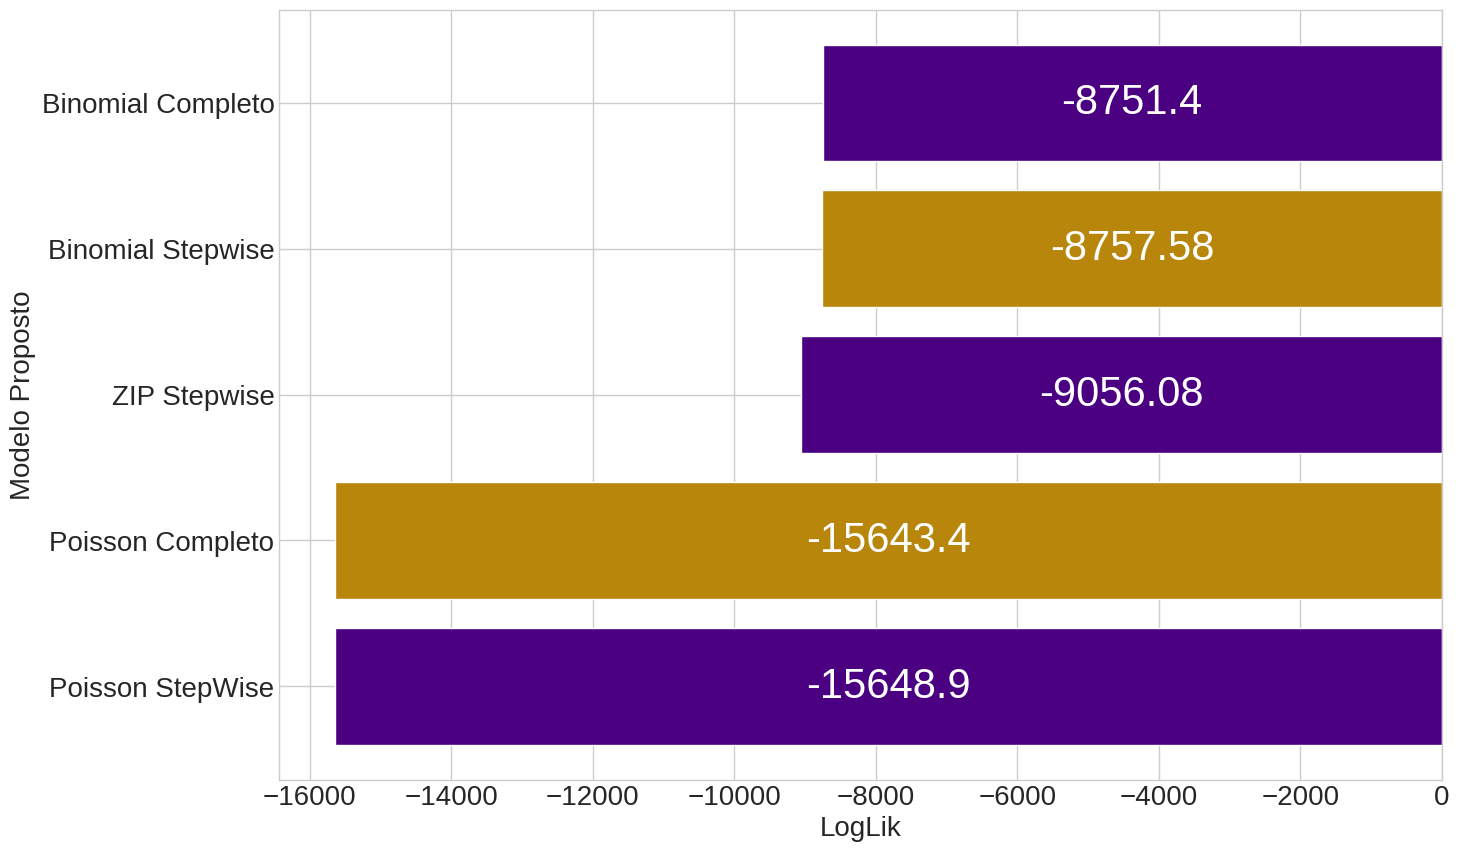

In [104]:
def print_compare_models():
  selected_models = []
  selected_names = []

  for model, name in zip(models, titles):
    if model.converged:
      selected_models.append(model)
      selected_names.append(name)

  compare_models({
    'modelo':selected_names,
    'loglik':[model.llf for model in selected_models]
  })

print_compare_models()

Analisando diretamente a métrica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto será necessário validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

### Dispersão dos residuos

IndexError: list index out of range

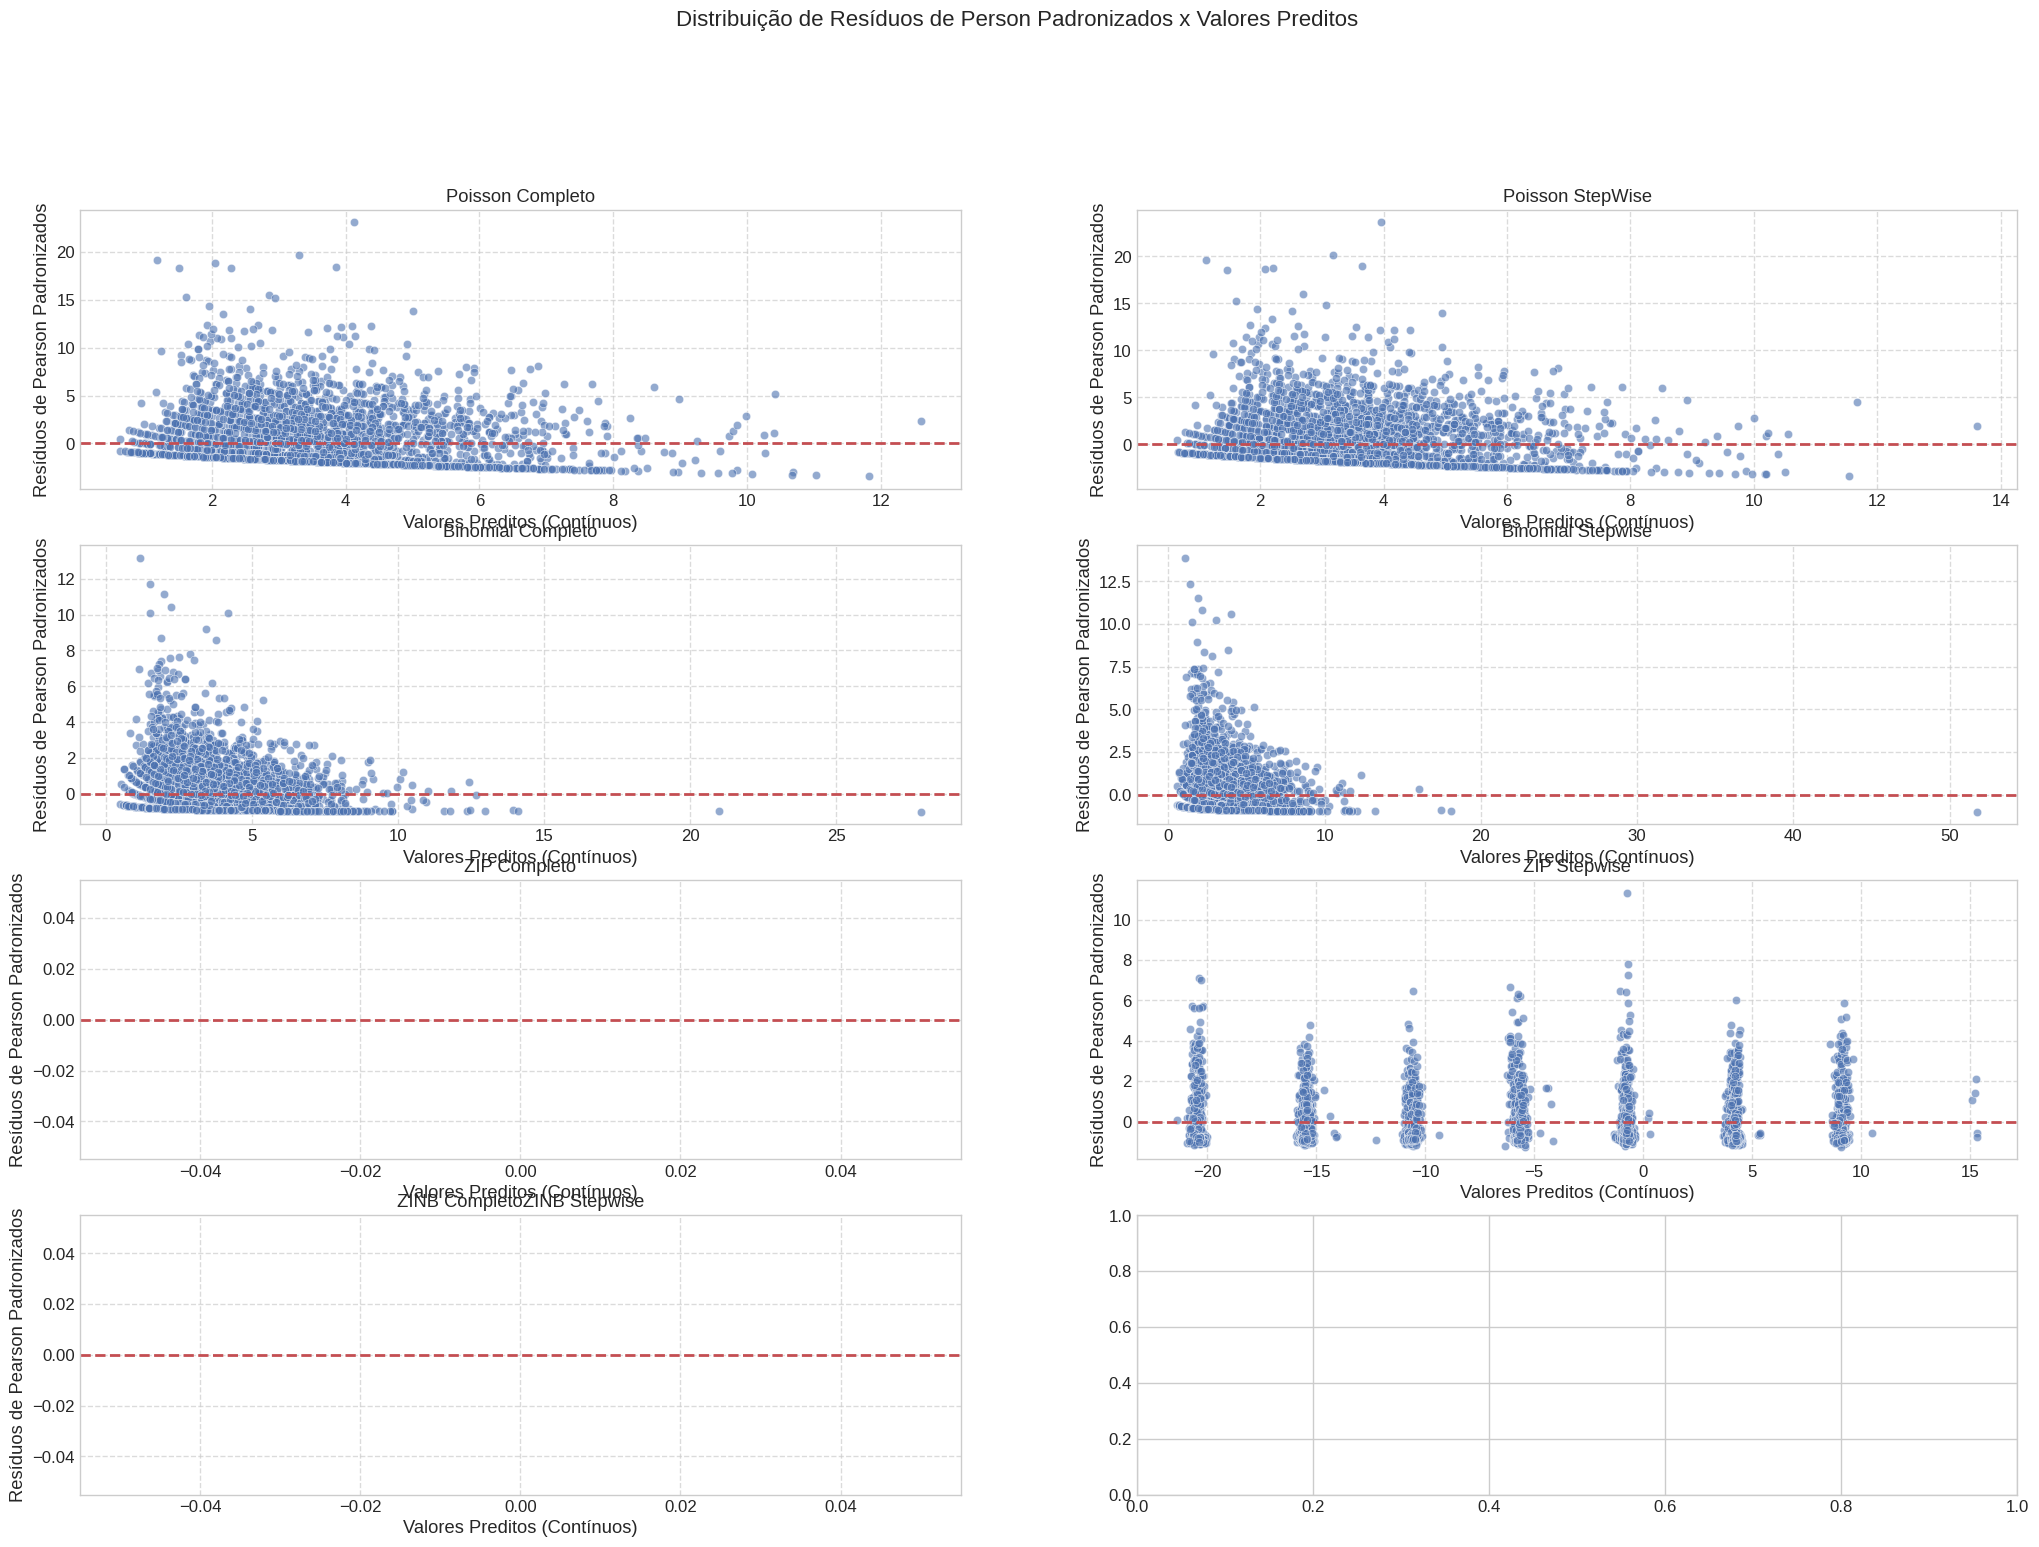

In [105]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, titles[i], "{}")

plt.tight_layout()
plt.show()

Com base nos residuos de cada modelos em relação ao valor predito, podemos observar que o modelo ZINB Stepwise apresenta uma melhor distribuição dos residuos não apresentando um padrão fixo nos dados, sua dispersão é a menor em relação aos outros modelos e com poucos pontos extremos.

### Análise das métricas dos modelos

In [106]:
import numpy as np
import pandas as pd

metrics = []
for title, res in zip(titles, models):   # renomeei 'model' -> 'res' para indicar objeto *resultado*
    metric = dict(title=title)

    # alguns objetos de resultado podem não ter llf/bic/aic
    metric['LLF'] = getattr(res, 'llf', np.nan)
    metric['BIC'] = getattr(res, 'bic', np.nan)
    metric['AIC'] = getattr(res, 'aic', np.nan)
    metric['Converged'] = getattr(res, 'converged', getattr(res, 'mle_retvals', {}).get('converged', np.nan))

    # pula resultados com LLF inválido
    if not np.isfinite(metric['LLF']):
        metrics.append(metric)   # opcional: append para manter linha do modelo (ou use `continue`)
        continue

    # --- Resíduos Pearson (fallback se não existir) ---
    if hasattr(res, 'resid_pearson') and np.asarray(getattr(res, 'resid_pearson')).size:
        resid = np.asarray(res.resid_pearson)
    else:
        # tenta computar resíduos de Pearson: (y - mu)/sqrt(var)
        try:
            endog = getattr(res.model, 'endog', None)
            mu = np.asarray(res.predict())                      # preditos do modelo
            # tentar var do modelo; se não houver, aproxima por mu (Poisson) ou usar varfunc se existir
            if hasattr(res, 'mu') and getattr(res, 'mu') is not None:
                var = np.asarray(res.mu)   # pouco comum
            elif hasattr(res.model, 'var_weights') and res.model.var_weights is not None:
                var = np.asarray(res.model.var_weights)
            else:
                var = np.maximum(mu, 1e-8)   # fallback: assume Poisson-like
            resid = (np.asarray(endog) - mu) / np.sqrt(var)
        except Exception:
            resid = np.array([])

    # se não conseguiu resíduos, guardar NaNs e seguir
    if resid.size == 0 or not np.any(np.isfinite(resid)):
        metric.update(RMSE_Pearson=np.nan, Outliers=np.nan, Dispersion=np.nan,
                      Pct_resid_gt_2=np.nan, Pct_resid_gt_3=np.nan)
        metrics.append(metric)
        continue

    # --- df_resid (cuidar de zero / não existente) ---
    df_resid = getattr(res, 'df_resid', None)
    if df_resid is None:
        # tenta inferir do modelo: nobs - params
        nobs = getattr(res, 'nobs', getattr(getattr(res, 'model', None), 'nobs', np.nan))
        params = getattr(res, 'df_modelwc', getattr(res, 'df_model', np.nan))
        try:
            df_resid = float(nobs) - float(params)
        except Exception:
            df_resid = np.nan

    # métricas simples de resíduos
    resid_finite = resid[np.isfinite(resid)]
    rmse_resid = np.sqrt(np.mean(resid_finite**2)) if resid_finite.size else np.nan
    outliers = np.sum(np.abs(resid_finite) > 2)
    pct_gt_2 = 100.0 * np.mean(np.abs(resid_finite) > 2)
    pct_gt_3 = 100.0 * np.mean(np.abs(resid_finite) > 3)

    # dispersion: cuidado com df_resid 0 ou NaN
    if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
        dispersion = np.nan
    else:
        dispersion = (resid_finite**2).sum() / df_resid

    # --- Pseudo R2: tenta vários métodos/fallbacks ---
    pseudo_r2 = np.nan
    if hasattr(res, 'prsquared'):
        pseudo_r2 = getattr(res, 'prsquared')
    else:
        # alguns objetos tem método pseudo_rsquared()
        try:
            pseudo_r2 = res.pseudo_rsquared()
        except Exception:
            # fallback manual (McFadden): 1 - llf/llnull (se existir llnull)
            llnull = getattr(res, 'llnull', getattr(res, 'llf_null', np.nan))
            if np.isfinite(llnull) and llnull != 0:
                try:
                    pseudo_r2 = 1.0 - (res.llf / llnull)
                except Exception:
                    pseudo_r2 = np.nan

    # preencher dicionário
    metric['PseudoR2'] = pseudo_r2
    metric['RMSE_Pearson'] = rmse_resid
    metric['Outliers'] = int(outliers)
    metric['Pct_resid_gt_2'] = pct_gt_2
    metric['Pct_resid_gt_3'] = pct_gt_3
    metric['Dispersion'] = dispersion
    metric['df_resid'] = df_resid

    metrics.append(metric)

# converter em DataFrame para facilitar análise
metrics_df = pd.DataFrame(metrics)


In [107]:
# metrics = []
# for title, model in zip(titles, models):
#   metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic, Converged=model.converged)

#   if np.isnan(model.llf):
#     continue

#   resid = model.resid_pearson
#   df_resid = model.df_resid

#   dispersion = (resid**2).sum() / df_resid

#   rmse_resid = np.sqrt(np.mean(model.resid_pearson**2))
#   outliers = np.sum(np.abs(model.resid_pearson) > 2)

#   if hasattr(model, 'prsquared'):
#     metric['PseudoR2'] = model.prsquared
#   else:
#     metric['PseudoR2'] = model.pseudo_rsquared()
#   metric['RMSE_Pearson'] = rmse_resid
#   metric['Outliers'] = outliers
#   metric['Dispersion'] = dispersion

#   metrics.append(metric)

In [108]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by=['LLF', 'Converged'], ascending=False).reset_index(drop=True)

title           LLF           BIC           AIC  \
0           Binomial Completo -8.751400e+03 -2.452450e+04  1.754080e+04   
1           Binomial Stepwise -8.757585e+03 -2.457832e+04  1.753717e+04   
2                ZIP Stepwise -9.056076e+03  1.821143e+04  1.813615e+04   
3            Poisson Completo -1.564343e+04 -7.196800e+03  3.132486e+04   
4            Poisson StepWise -1.564892e+04 -7.235454e+03  3.132384e+04   
5                ZIP Completo -5.186072e+07  1.037218e+08  1.037215e+08   
6  ZINB CompletoZINB Stepwise           NaN           NaN           NaN   

   Converged  PseudoR2  RMSE_Pearson  Outliers  Pct_resid_gt_2  \
0       True  0.168960      1.419545     340.0        8.677897   
1       True  0.166332      1.427066     338.0        8.626850   
2       True  0.043344      1.276316     338.0        8.626850   
3       True  0.504542      2.775958    1186.0       30.270546   
4       True  0.503151      2.781634    1184.0       30.219500   
5      False       NaN           NaN       NaN             NaN   
6      False       NaN           NaN       NaN             NaN   

   Pct_resid_gt_3  Dispersion  df_resid  
0        4.058193    2.024928    3899.0  
1        4.083716    2.042252    3907.0  
2        3.879530    1.631897    3911.0  
3       13.374170    7.743493    3899.0  
4       13.144461    7.763249    3905.0  
5             NaN         NaN       NaN  
6             NaN         NaN       NaN

In [109]:
df_metrics = df_metrics.query('Converged == True').sort_values(by=['Dispersion'], ascending=True).reset_index(drop=True)
df_metrics

title           LLF           BIC           AIC  Converged  \
0       ZIP Stepwise  -9056.075862  18211.431764  18136.151725       True   
1  Binomial Completo  -8751.400476 -24524.500665  17540.800953       True   
2  Binomial Stepwise  -8757.584537 -24578.319237  17537.169074       True   
3   Poisson Completo -15643.427593  -7196.799973  31324.855187       True   
4   Poisson StepWise -15648.920813  -7235.453554  31323.841625       True   

   PseudoR2  RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  \
0  0.043344      1.276316     338.0        8.626850        3.879530   
1  0.168960      1.419545     340.0        8.677897        4.058193   
2  0.166332      1.427066     338.0        8.626850        4.083716   
3  0.504542      2.775958    1186.0       30.270546       13.374170   
4  0.503151      2.781634    1184.0       30.219500       13.144461   

   Dispersion  df_resid  
0    1.631897    3911.0  
1    2.024928    3899.0  
2    2.042252    3907.0  
3    7.743493    3899.0  
4    7.763249    3905.0

Percebemos que o modelo com maior LLF não convergiu durante o treinamento, o que invalida sua escolha uma vez que os pesos obtidos não refletem a correta relação dos dados com o modelo escohido.

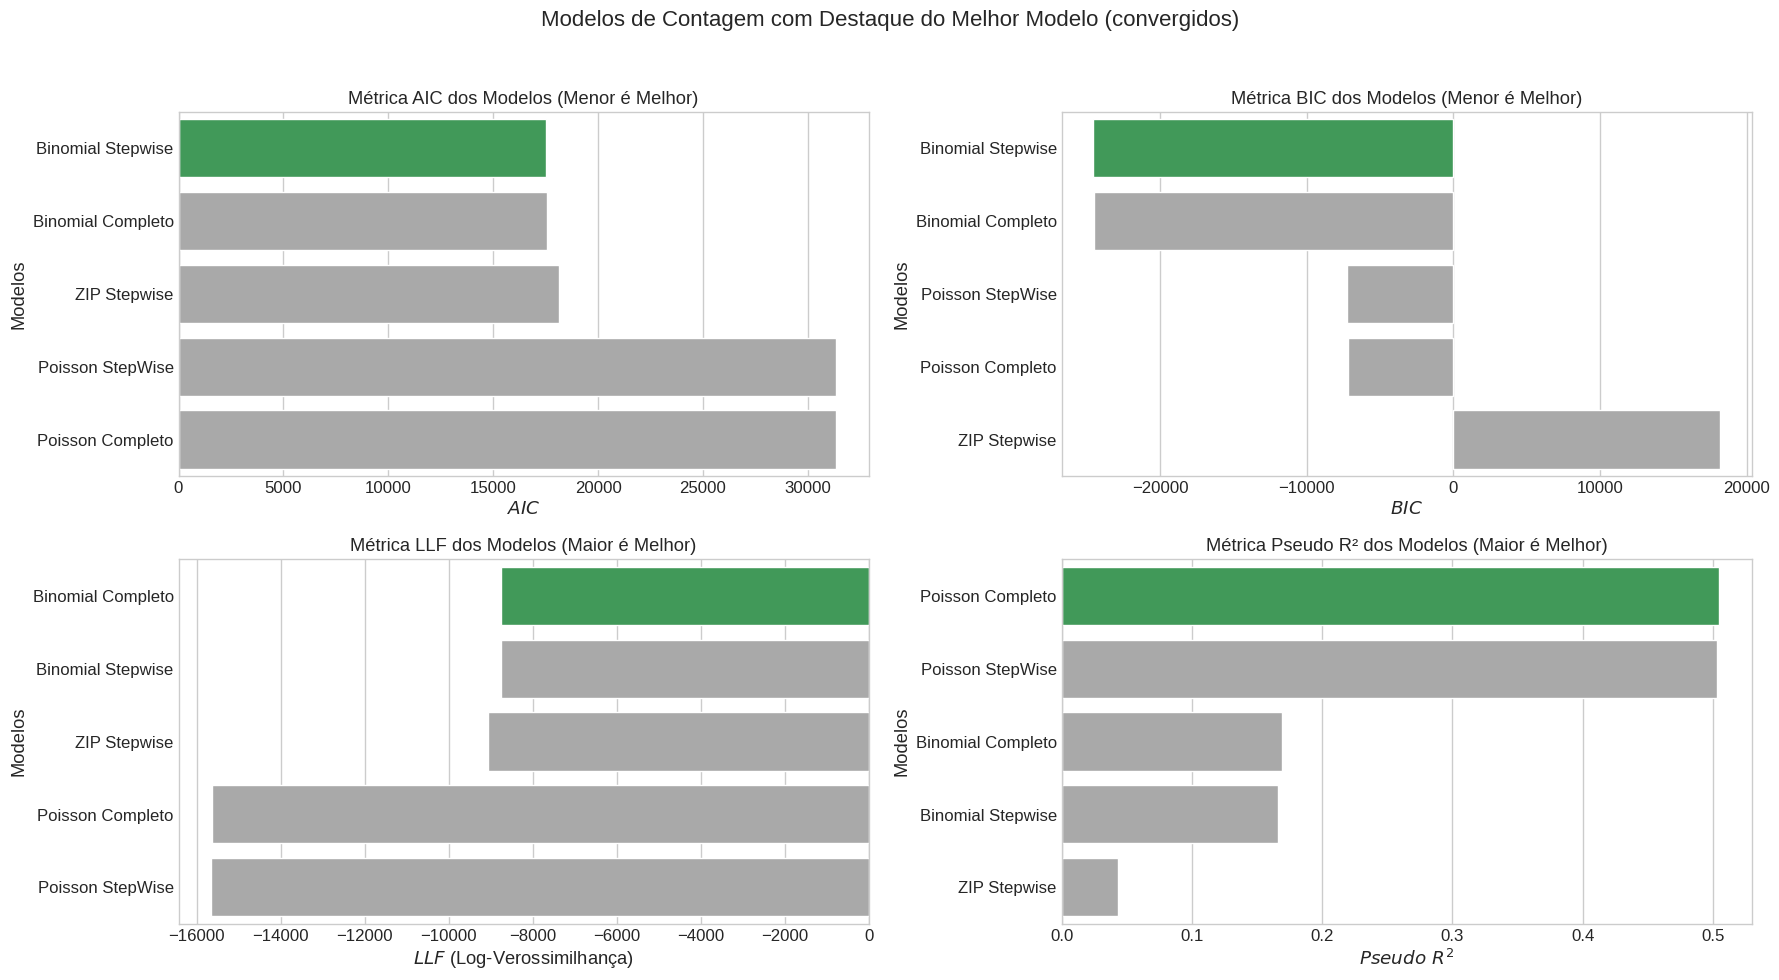

In [110]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['title']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['title']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='title', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['title']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['title']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['title']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

Podemos perceber que o modelo ZINB Stepwise se demonstra melhor em duas métricas, LLF e AIC, sendo assim a melhor escolha.

#### Seleção do melhor modelo

In [111]:
best_model = df_metrics.loc[0, 'title']
best_model

'ZIP Stepwise'

In [112]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: ZeroInflatedPoisson
============================================================================
Model:                 ZeroInflatedPoisson   Pseudo R-squared:   0.043      
Dependent Variable:    y                     AIC:                18136.1517 
Date:                  2025-08-26 14:37      BIC:                18211.4318 
No. Observations:      3918                  Log-Likelihood:     -9056.1    
Df Model:              6                     LL-Null:            -9466.4    
Df Residuals:          3911                  LLR p-value:        5.3879e-174
Converged:             1.0000                Scale:              1.0000     
Method:                MLE                                                  
----------------------------------------------------------------------------
                          Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------
inflate_const            -24.6146   3.1572  -7.7963 0.0000 -30.8027 -18.4266
inflate_chip_ratio        -1.1499   0.1073 -10.7191 0.0000  -1.3601  -0.9396
inflate_cards_per_client   4.9233   0.8000   6.1538 0.0000   3.3553   6.4914
inflate_merchant_entropy   3.2367   0.5139   6.2982 0.0000   2.2294   4.2439
inflate_avg_value_change   1.0205   0.4649   2.1953 0.0281   0.1094   1.9317
const                     -1.4107   0.3964  -3.5585 0.0004  -2.1877  -0.6337
txn_velocity               6.0858   0.4004  15.2008 0.0000   5.3011   6.8705
day_of_week                0.0498   0.0045  11.0550 0.0000   0.0410   0.0586
cards_per_client          -2.5026   0.3979  -6.2900 0.0000  -3.2824  -1.7228
error_ratio               12.5113   3.2978   3.7938 0.0001   6.0478  18.9749
avg_value_change           0.2833   0.1262   2.2445 0.0248   0.0359   0.5307
velocity_alert             0.1924   0.0888   2.1670 0.0302   0.0184   0.3665
============================================================================

"""

#### Tabela de features

In [113]:
df_exog_inf = pd.DataFrame()
if hasattr(best_model.model, 'exog_infl'):
  df_exog_inf = best_model.model.exog_infl
  feature_exog_inf = [column for column in best_model.model.exog_names if ('inflate_' in column)]
  df_exog_inf = pd.DataFrame(df_exog_inf, columns=feature_exog_inf)

In [114]:
df_exog = best_model.model.exog
features_exog = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
df_exog = pd.DataFrame(df_exog, columns=features_exog)

In [115]:
df_features = pd.concat([df_exog, df_exog_inf], axis=1)
df_features['residuos'] = best_model.resid_pearson
df_features['fitted'] = best_model.fittedvalues.values
df_features['target'] = y.values
df_features

const  txn_velocity  day_of_week  cards_per_client  error_ratio  \
0       1.0      0.576111          4.0          1.428405     0.014465   
1       1.0      0.493333          4.0          1.358788     0.016329   
2       1.0      0.545278          5.0          1.393904     0.012736   
3       1.0      0.538889          6.0          1.380298     0.016495   
4       1.0      0.512778          0.0          1.387173     0.010834   
...     ...           ...          ...               ...          ...   
3913    1.0      0.652500          6.0          1.535961     0.014049   
3914    1.0      0.584167          0.0          1.484310     0.013790   
3915    1.0      0.553056          1.0          1.466377     0.016575   
3916    1.0      0.623333          2.0          1.511868     0.016043   
3917    1.0      0.265556          3.0          1.235690     0.019874   

      avg_value_change  velocity_alert  inflate_const  inflate_chip_ratio  \
0             0.000000             0.0            1.0            0.000000   
1             0.167652             0.0            1.0            0.000000   
2            -0.075290             0.0            1.0            0.000000   
3            -0.013036             0.0            1.0            0.000000   
4             0.049766             0.0            1.0            0.000000   
...                ...             ...            ...                 ...   
3913         -0.050405             0.0            1.0            0.702427   
3914          0.257229             0.0            1.0            0.676652   
3915         -0.079709             0.0            1.0            0.696133   
3916         -0.073623             0.0            1.0            0.696078   
3917          0.142449             0.0            1.0            0.702929   

      inflate_cards_per_client  inflate_merchant_entropy  \
0                     1.428405                  5.347912   
1                     1.358788                  5.446203   
2                     1.393904                  5.430923   
3                     1.380298                  5.396481   
4                     1.387173                  5.427792   
...                        ...                       ...   
3913                  1.535961                  5.548957   
3914                  1.484310                  5.438515   
3915                  1.466377                  5.646137   
3916                  1.511868                  5.609006   
3917                  1.235690                  5.215418   

      inflate_avg_value_change  residuos     fitted  target  
0                     0.000000 -0.999157  -0.945661     0.0  
1                     0.167652 -0.605834  -1.310407     1.0  
2                    -0.075290 -0.978254   4.005911     0.0  
3                    -0.013036 -0.804670   8.808577     1.0  
4                     0.049766  0.232977 -20.773568     3.0  
...                        ...       ...        ...     ...  
3913                 -0.050405 -0.890195   9.231989     0.0  
3914                  0.257229 -0.948730 -20.830904     0.0  
3915                 -0.079709 -0.846145 -15.451676     0.0  
3916                 -0.073623 -0.842526 -10.471035     0.0  
3917                  0.142449 -1.215381  -6.331089     0.0  

[3918 rows x 15 columns]

#### Análises de resíduos padronizados

##### Histograma

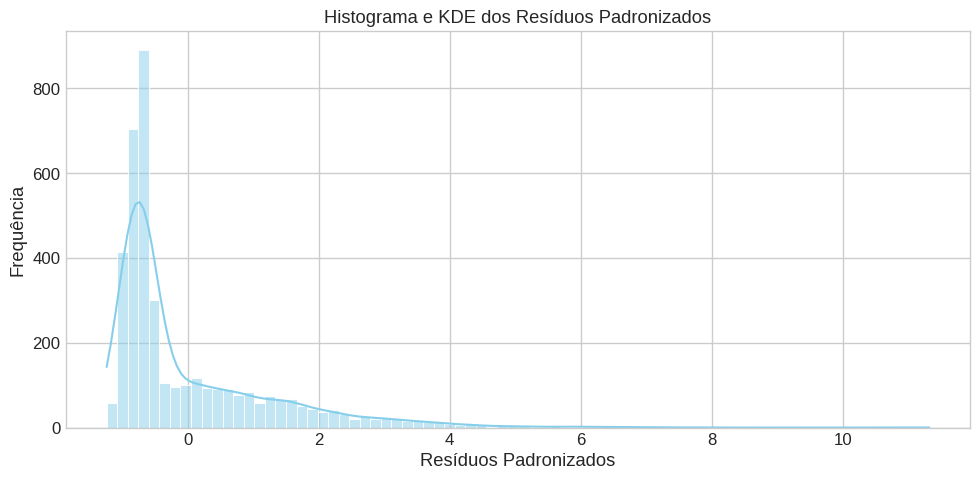

In [116]:
plt.figure(figsize=(10, 5))
sns.histplot(df_features["residuos"], kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos Padronizados")
plt.xlabel("Resíduos Padronizados")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

##### Análise dos residuos com um quantis teóricos

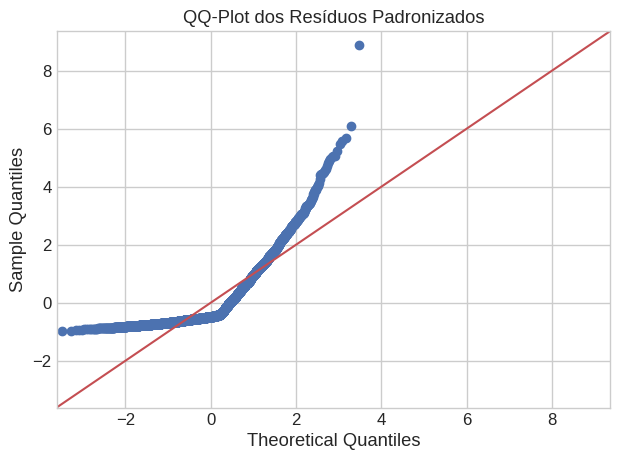

In [117]:
sm.qqplot(df_features["residuos"], line='45', fit=True)
plt.title("QQ-Plot dos Resíduos Padronizados")
plt.tight_layout()
plt.show()

##### Testes de normalidades de resíduos

In [118]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df_features["residuos"])
print(f"[Shapiro-Wilk] Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")

alpha = 0.05
if shapiro_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[Shapiro-Wilk] Estatística: 0.7475 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


In [119]:
# D’Agostino and Pearson's test
dagostino_stat, dagostino_p = stats.normaltest(df_features["residuos"])
print(f"[D’Agostino] Estatística: {dagostino_stat:.4f} | p-valor: {dagostino_p:.4f}")

alpha = 0.05  # nível de significância
if dagostino_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[D’Agostino] Estatística: 1675.4805 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


##### Teste de validação de homocedasticidade

In [120]:
X = sm.add_constant(df_features["fitted"])
model_bp = sm.OLS(df_features["residuos"], X).fit()
bp_test = het_breuschpagan(model_bp.resid, X)
bp_labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']

print("\n[Breusch-Pagan]")
for label, val in zip(bp_labels, bp_test):
    print(f"{label}: {val:.4f}")

# Define o nível de significância (alpha)
alpha = 0.05
p_valor_lm = bp_test[1] # p-valor da estatística LM é o mais comum

print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
print("H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).")
print("Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).")

if p_valor_lm < alpha:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MENOR que {alpha}.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo APRESENTA HETEROCEDASTICIDADE.")
else:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MAIOR ou IGUAL a {alpha}.")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.")



[Breusch-Pagan]
LM Stat: 0.0667
LM p-val: 0.7962
F Stat: 0.0667
F p-val: 0.7962

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).
Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).

Resultado: O p-valor (0.7962) é MAIOR ou IGUAL a 0.05.
Decisão: Não Rejeitamos a Hipótese Nula (H₀).
Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.


##### Teste de autocorrelação de resíduos

In [121]:
# Teste de Autocorrelação (Durbin-Watson)
dw_stat = durbin_watson(df_features["residuos"])

print(f"\n--- Resultado do Teste de Durbin-Watson ---")
print(f"Estatística d: {dw_stat:.4f}")

# --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
print(f"\n--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---")
print("H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.")
print("Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.")

if dw_stat < 1.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MENOR que 1.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.")

elif dw_stat > 2.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MAIOR que 2.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO NEGATIVA.")

else: # A estatística está entre 1.5 e 2.5
    print(f"\nResultado: A estatística ({dw_stat:.4f}) está dentro da faixa segura [1.5, 2.5].")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste NÃO indica a presença de autocorrelação de primeira ordem.")



--- Resultado do Teste de Durbin-Watson ---
Estatística d: 1.4723

--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---
H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.
Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.

Resultado: A estatística (1.4723) é MENOR que 1.5.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.


In [122]:
validar_autocorrelacao_ljung_box(best_model.resid_pearson)


--- Resultados do Teste de Ljung-Box ---
        lb_stat  lb_pvalue
20  6112.770248        0.0

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).
Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.

Resultado: O p-valor (0.0000) é MENOR que 0.05.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.


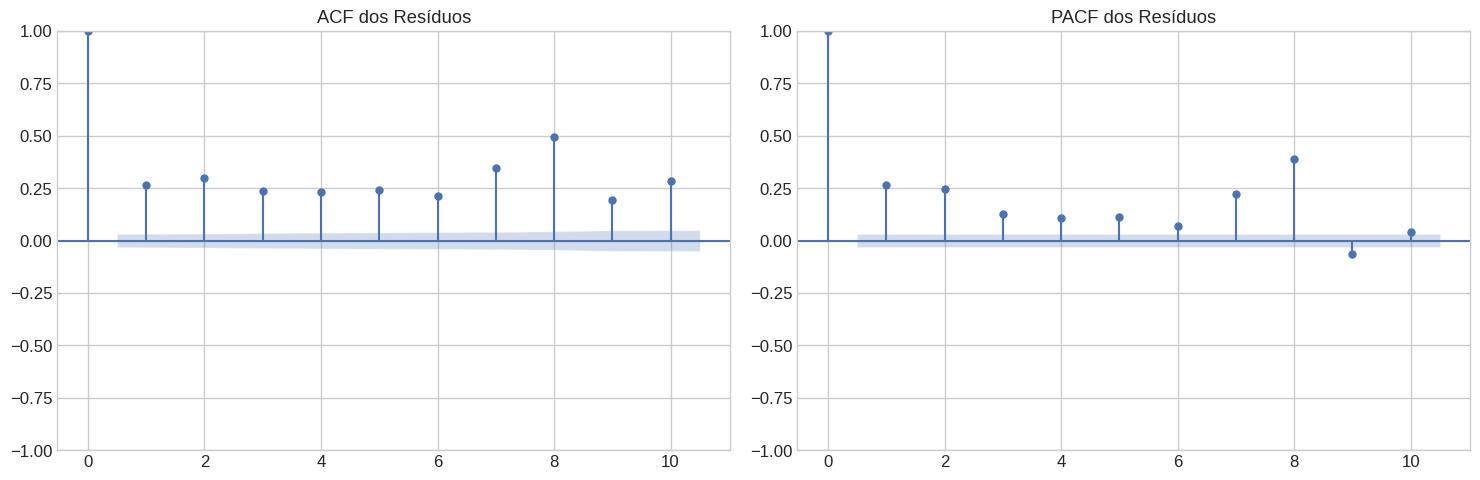

In [123]:
plot_acf_pacf(best_model.resid_pearson, 10)

## Inferência Estatistica

In [124]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3911
Method:                            MLE   Df Model:                            6
Date:                 Tue, 26 Aug 2025   Pseudo R-squ.:                 0.04334
Time:                         14:37:40   Log-Likelihood:                -9056.1
converged:                        True   LL-Null:                       -9466.4
Covariance Type:             nonrobust   LLR p-value:                5.388e-174
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const              -24.6146      3.157     -7.796      0.000     -30.803     -18.427
inflate_chip_ratio          -1.1499      0.107    -10.719      0.000      -1.360      -0.940
inflate_cards_per_client     4.9233      0.800      6.154      0.000       3.355       6.491
inflate_merchant_entropy     3.2367      0.514      6.298      0.000       2.229       4.244
inflate_avg_value_change     1.0205      0.465      2.195      0.028       0.109       1.932
const                       -1.4107      0.396     -3.558      0.000      -2.188      -0.634
txn_velocity                 6.0858      0.400     15.201      0.000       5.301       6.871
day_of_week                  0.0498      0.005     11.055      0.000       0.041       0.059
cards_per_client            -2.5026      0.398     -6.290      0.000      -3.282      -1.723
error_ratio                 12.5113      3.298      3.794      0.000       6.048      18.975
avg_value_change             0.2833      0.126      2.244      0.025       0.036       0.531
velocity_alert               0.1924      0.089      2.167      0.030       0.018       0.366
============================================================================================
"""

In [125]:
params = best_model.params
conf = best_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'IRR/Odds Ratio']
conf = np.exp(conf)
conf

2.5%         97.5%  IRR/Odds Ratio
inflate_const             4.193412e-14  9.941131e-09    2.041746e-11
inflate_chip_ratio        2.566293e-01  3.907761e-01    3.166775e-01
inflate_cards_per_client  2.865354e+01  6.594508e+02    1.374613e+02
inflate_merchant_entropy  9.294718e+00  6.968022e+01    2.544913e+01
inflate_avg_value_change  1.115615e+00  6.901020e+00    2.774686e+00
const                     1.121786e-01  5.306312e-01    2.439784e-01
txn_velocity              2.005643e+02  9.634576e+02    4.395852e+02
day_of_week               1.041831e+00  1.060395e+00    1.051072e+00
cards_per_client          3.753716e-02  1.785646e-01    8.187067e-02
error_ratio               4.231702e+02  1.740589e+08    2.713974e+05
avg_value_change          1.036565e+00  1.700100e+00    1.327503e+00
velocity_alert            1.018553e+00  1.442660e+00    1.212199e+00

In [126]:
# Calculando a estatística Qui-quadrado de Pearson
chi2_stat = np.sum(best_model.resid_pearson**2)
dof = best_model.df_resid # Graus de liberdade (observações - número de parâmetros)
p_value_gof = stats.chi2.sf(chi2_stat, dof)

print("\n--- Diagnóstico do Modelo ---")
print(f"Estatística Qui-quadrado de Pearson: {chi2_stat:.2f}")
print(f"Graus de Liberdade: {dof}")
print(f"P-valor do Teste de Goodness-of-Fit: {p_value_gof:.4f}")

if p_value_gof > 0.05:
    print("Conclusão: Não há evidência para rejeitar a hipótese nula. O modelo parece se ajustar bem aos dados (p > 0.05).")
else:
    print("Conclusão: O p-valor é baixo (p <= 0.05), o que sugere um possível mau ajuste do modelo.")



--- Diagnóstico do Modelo ---
Estatística Qui-quadrado de Pearson: 6382.35
Graus de Liberdade: 3911.0
P-valor do Teste de Goodness-of-Fit: 0.0000
Conclusão: O p-valor é baixo (p <= 0.05), o que sugere um possível mau ajuste do modelo.
